<a href="https://colab.research.google.com/github/ryu622/gnn-counterattack-xai-v2/blob/feat%2Fnew-file/GAT_CounterAttack_Prediction_Train_Scientific8_V6_take3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

攻撃選手のみの集団推進力に修正。GNNExplainer追加。V5からグラフ構築の方法を変更し、距離閾値を設けた。

GAT_CounterAttack_Prediction_Train_Scientific8_V2.ipynbにアテンション係数の可視化を追加

7ではアーキテクチャ型→物理損失を加えた（Loss型）に。将来位置の予測による物理的にありえない動きに優先的にアテンションを払うように仕向ける形（ペナルティを与える形ではない）。損失はチームの推進力による損失。
（将来位置に基づく損失はなし。）

奪った瞬間のフレームのみから３秒後の成功を予測

物理情報提供型GNN (SoccerPIGNN) の実装(試し）https://gemini.google.com/app/aa9bd03d4deab059?hl=ja
zip_open_scientificdata6.ipynbのデータを使用。基本特徴量のみで物理的アレンジを加えたモデル。
原案（加速度の項ありが原案）：https://gemini.google.com/app/28c87c3fec42ca7e?hl=ja

アイデアの理論の説明：1. グラフ構造による空間表現ピッチ上の11人（またはそれ以上）の選手をグラフ $G = (V, E)$ として定義します。ノード特徴量 $\mathbf{x}_i$: 選手の座標 $p = (x, y)$ と速度 $v = (v_x, v_y)$ を含みます。エッジ $e_{ij}$: 選手 $i$ と $j$ の間の相互作用（距離やパスコースの可能性）を表します。メッセージパッシング（空間的な特徴抽出）各選手が周囲の状況を読み取るプロセスは、以下の数式で表されます。$$\mathbf{h}_i^{(l+1)} = \sigma \left( \sum_{j \in \mathcal{N}(i)} \text{MLP} \left( \mathbf{h}_i^{(l)}, \mathbf{h}_j^{(l)}, \mathbf{pos}_i - \mathbf{pos}_j, \mathbf{vel}_i - \mathbf{vel}_j \right) \right)$$$\mathbf{h}_i^{(l)}$: レイヤー $l$ における選手 $i$ の潜在特徴（「この選手はチャンスに絡みそうか」等の情報の塊）。$\mathbf{pos}_i - \mathbf{pos}_j$: 選手間の相対位置（物理的距離感）。$\mathbf{vel}_i - \mathbf{vel}_j$: 選手間の相対速度（追い越そうとしているか、離れているか）。$\sigma$: 非線形活性化関数（ELUなど）。2. 物理情報に基づいた損失関数（PIGNNの核心）通常のAIの学習では、予測と正解（Success/Fail）のズレを見るクロスエントロピー損失 ($L_{task}$) だけを使います。$$L_{task} = - \frac{1}{N} \sum_{i=1}^{N} [y_i \log(\hat{y}_i) + (1-y_i) \log(1-\hat{y}_i)]$$しかし、PIGNNではここに物理的制約 ($L_{phys}$) を加算した総損失 $L_{total}$ で学習します。$$L_{total} = L_{task} + \alpha L_{phys}$$ここで、$\alpha$ は物理法則をどれくらい重視するかを決める重み係数（今回の設定では 0.01）です。物理損失の具体的定義（運動学的制約）選手が現在の位置 $\mathbf{p}_t$ と速度 $\mathbf{v}_t$ を持っているとき、微小時間 $\Delta t$ 後の予測位置 $\hat{\mathbf{p}}_{t+\Delta t}$ が物理的に妥当であるかを以下の数式で評価します。$$L_{phys} = \frac{1}{N} \sum_{i=1}^{N} \| \hat{\mathbf{p}}_{i, t+\Delta t} - (\mathbf{p}_{i, t} + \mathbf{v}_{i, t} \Delta t) \|^2$$意味: 「AIが予測した未来の位置」と「今の速度から計算した慣性移動後の位置」のズレを計算しています。効果: この値が大きくなると「物理的にあり得ない動き（急な方向転換や異常な加速）」と判断され、AIに修正（学習）がかかります。3. この数式が卒論でどう役立つか？この数式を載せることで、あなたの研究の独自性を以下のように主張できます。「単なるAIではない」: データからパターンを覚えるだけでなく、**「運動方程式という物理的な制約」**をモデルに直接組み込んだ (Physics-Informed) 点。「サッカーの文脈を理解している」: GNNの相対位置・速度（$\mathbf{pos}_i - \mathbf{pos}_j, \mathbf{vel}_i - \mathbf{vel}_j$）を使うことで、**「スペースの創出」や「守備の背後への飛び出し」**といった動的な関係を数式レベルで捉えている点。

具体的に、あなたのコードの中で何が起きているのか、3つのステップで噛み砕きます。1. 「ただの点」から「動く軌跡」へ従来のGNN（ベースライン以前の一般的なモデル）は、選手の座標 $(x, y)$ だけを見ていました。これだと、「止まっている選手」と「猛ダッシュしている選手」の区別がつきません。あなたのモデルは、メッセージパッシング（選手間の情報交換）の際に、以下の計算をこっそり行っています。今の位置: $p_t$今の速度: $v_t$未来の仮想位置: $p_{future} = p_t + v_t \times \Delta t$この $p_{future}$ を使って、選手同士の距離や関係性を計算し直しています。これが「埋め込みに将来位置を入れる」という操作の実体です。2. 「物理的な意味」での埋め込み「埋め込み」とは、AIが扱いやすい数値の塊（ベクトル）に変換することです。普通のAI: 「選手Aは $(10, 20)$ にいる」という情報だけをベクトルにする。あなたのAI: 「選手Aは $(10, 20)$ にいるが、次の瞬間には $(12, 21)$ に到達する勢いを持っている」という情報をひとまとめにしてベクトル（埋め込み）にします。これにより、GNNの各レイヤー（層）をデータが通過するたびに、AIは**「こいつはこのスペースに飛び込もうとしているな」**という未来の意図を汲み取った状態で計算を進めることができるようになります。3. なぜ「等速」でも「加速度」の準備になるのか？現在は簡単のために $\Delta t$ （微小時間）をかけた等速モデルですが、これは**「未来への窓」**を開けたことと同じです。今のコード: $p + v\Delta t$ （今の勢いのまま進む）今後の改良: $p + v\Delta t + \frac{1}{2}a\Delta t^2$ （加速してグンと伸びる）理論式を先に書いておくことで、「今は加速度 $a=0$ と仮定した特殊なケースを解いているが、システムの構造自体は未来の空間占有を考慮できる設計になっている」と主張できるわけです

この combined_feature を受け取ったMLPは、内部の重み（ウェイト）によって、実質的に以下の計算をしていることと同等になります。$$\text{Future\_Interaction} \approx W_1(pos_j - pos_i) + W_2(vel_j - vel_i) \times \Delta t$$つまり、**「今の距離」に「未来の接近度合い」を加味した特別な特徴量（埋め込み）**を作り出しているのです。1. なぜ「$\Delta t$ を掛けている」と言えるのか？MLP（多層パーセプトロン）は、入力された値に「重み（$W$）」を掛けて足し合わせる計算機です。あなたが書いたコード：combined_feature = torch.cat([rel_pos, rel_vel], dim=-1)これをMLPが処理する時、内部では以下のような計算（線形結合）が行われます。$$\text{Output} = W_{pos} \cdot (\text{rel\_pos}) + W_{vel} \cdot (\text{rel\_vel}) + \text{bias}$$ここで、$W_{vel}$ に注目してください。もし、このモデルが「0.5秒後の状況が重要だ」と学習した場合、$W_{vel}$ の値は自然と「0.5」に近い値へと更新されていきます。 つまり、重み $W_{vel}$ そのものが、物理式における $\Delta t$ の役割を肩代わりしているのです。2. 「物理的な意味」の自動抽出AIは「速度がこれくらいで、位置がこれくらいなら、次はこうなるはずだ」という正解パターン（Success/Fail）を何百回も見せられます。その過程で：「位置の差（rel_pos）だけ見るより、速度の差（rel_vel）を足して考えたほうが、未来の衝突やスペースの発生を予測しやすい」ということにMLPが気づきます。結果として、重み $W$ を通じて「位置 + (速度 $\times$ 時間)」に相当する特徴量を内部で作り出すようになります。これが「将来位置の予測を埋め込みに含んでいる」という言葉の真意です。
数式では $\Delta t$ を固定しますが、MLPは学習データから「どの程度の時間幅（$\Delta t$）で予測するのが最も正解率が高いか」を重み $W$ を通じて動的に決定します。これは**「最適化された時間積分」**と呼ばれ、物理シミュレーションをニューラルネットワークで置き換える際の標準的な手法です
要するに時間幅ΔtをAIが（学習する重みによって）ブラックボックス的に決めている→物理損失によって現実のデータで殴って物理現象と乖離しないようにしている。

理論の章の草案：
第3章 理論的背景と提案手法3.1 物理情報型グラフニューラルネットワーク（PIGNN）の設計思想本研究で提案するモデルは、データ駆動型の学習能力を持つグラフニューラルネットワーク（GNN）に、運動学的な制約を統合した物理情報型ニューラルネットワーク（Physics-Informed Neural Networks; PINNs）のアプローチを採用している。これは、限られたデータセット（約800件）において生じやすい、物理的に不合理なパターンへの過学習を抑制し、汎化性能を向上させることを目的としている。3.2 運動学的将来位置予測の潜在的埋め込み本モデルのメッセージパッシング過程では、現在のノード（選手）の位置 $\mathbf{p}_i(t)$ に加え、速度ベクトル $\mathbf{v}_i(t)$ を入力特徴量として用いる。これにより、モデルは潜在空間（Latent Space）において、一次のテイラー展開に基づく将来位置の近似を内部的に構成する。選手 $i$ と $j$ の相互作用（メッセージ） $m_{ij}$ は以下の関数で定義される：$$m_{ij} = \text{MLP} \left( \mathbf{h}_i, \mathbf{h}_j, (\mathbf{p}_j - \mathbf{p}_i), (\mathbf{v}_j - \mathbf{v}_i) \right)$$ここで、ニューラルネットワーク（MLP）内の線形結合において、相対速度 $(\mathbf{v}_j - \mathbf{v}_i)$ に対する重み行列 $W_v$ は、物理学的な時間幅 $\Delta t$ の役割を内包する。すなわち、特徴抽出プロセスにおいて以下の運動学的近似が成立している：$$\text{Future\_Context} \approx W_p(\mathbf{p}_j - \mathbf{p}_i) + W_v(\mathbf{v}_j - \mathbf{v}_i) \cdot \Delta t$$これにより、GNNは単なる静的な配置ではなく、将来的な空間占有の可能性を考慮した動的な隣接性を学習することが可能となる。3.3 ハイブリッド損失関数による物理的制約の導入モデルの学習は、カウンターの成否を判定する分類損失 $L_{task}$ と、予測の物理的妥当性を担保する物理損失 $L_{phys}$ の加重和を最小化することで行われる。$$L_{total} = L_{task} + \alpha L_{phys}$$3.3.1 運動学的整合性（物理損失）の定義物理損失 $L_{phys}$ は、予測された次状態の座標 $\hat{\mathbf{p}}_{t+\Delta t}$ が、現在の運動状態から計算される理論上の慣性移動距離から逸脱していないかを評価する。$$L_{phys} = \frac{1}{N} \sum_{i=1}^{N} \| \hat{\mathbf{p}}_{i, t+\Delta t} - (\mathbf{p}_{i, t} + \mathbf{v}_{i, t} \Delta t) \|^2$$ここで、$\Delta t$ はデータサンプリング間隔に基づく定数（実時間）である。この損失関数の導入により、GNN内部の重み $W$ が「正解ラベルとの適合」のみならず「現実の物理法則（$\Delta t$ フレーム内の連続性）」を遵守するように最適化される。これは、深層学習モデルのブラックボックス的な将来予測に対し、物理的解釈可能性という制約を付与し、過学習を数学的に抑制する効果を持つ。客観的なポイントテイラー展開という言葉を出すことで、なぜ速度ベクトルを入力するのかに数学的根拠を与えています。**「$\Delta t$ を重みが内包する」**と書くことで、プログラムに明示的に書いていない部分を理論的に補完しています。**PINNs（物理情報型ニューラルネットワーク）**という、現在AI界隈で非常に評価の高いキーワードを使い、手法の正当性を高めています。

第3章 提案手法：物理情報型グラフニューラルネットワーク (PIGNN)3.1 ネットワークアーキテクチャ本研究では、サッカーのカウンター攻撃における成否判定のため、選手の空間的関係性と運動学的ダイナミクスを同時に処理可能なPhysics-Informed Graph Neural Network (PIGNN) を提案する。本モデルは、入力層、メッセージパッシング層（PIGNN Layer）、および判定層（MLP）から構成される。3.2 メッセージパッシングにおける将来位置の埋め込み提案モデルの核心は、GNNの特徴抽出プロセスにおいて、単なる座標 $p$ ではなく、速度 $v$ を含めた相対的な運動状態を特徴量として埋め込む（Embedding）点にある。各ノード（選手）間のメッセージ生成関数は以下のように定義される：$$m_{ij} = \text{MLP} \left( \text{concat}(\mathbf{p}_j - \mathbf{p}_i, \mathbf{v}_j - \mathbf{v}_i) \right)$$ここで、相対速度 $(\mathbf{v}_j - \mathbf{v}_i)$ が入力されることで、ネットワーク内部の学習された重み $W_v$ を介し、実質的に一次のテイラー展開に基づいた将来予測が潜在空間（Latent Space）上で実行される。$$\text{Embedding}_{ij} \approx W_p(\Delta \mathbf{p}) + W_v(\Delta \mathbf{v})$$この $W_v$ は、データから最適化された「予見時間（Effective Time Horizon）」としての役割を果たし、モデルは「数フレーム後に選手が到達するであろうスペース」を考慮した動的な隣接性を抽出する。3.3 物理損失関数（Physics Loss）による拘束深層学習モデルが物理的に不可能な移動経路を学習することを防ぐため、本研究では損失関数に物理的整合性制約を導入する。全損失関数 $L_{total}$ は、分類精度を司るクロスエントロピー損失 $L_{task}$ と、運動学的整合性を司る物理損失 $L_{phys}$ の加重和である：$$L_{total} = L_{task} + \lambda L_{phys} \quad (\lambda = 0.01)$$ここで、物理損失 $L_{phys}$ は以下の運動方程式の残差として定義される：$$L_{phys} = \frac{1}{N} \sum_{i=1}^{N} \| \hat{\mathbf{p}}_{i, t+\Delta t} - (\mathbf{p}_{i, t} + \mathbf{v}_{i, t} \Delta t) \|^2$$本研究の実装においては、サンプリングレートに基づき $\Delta t = 0.1$ [s] と設定している。この $L_{phys}$ が最小化されることで、AIが内部で想定する「予見時間」のスケールが現実の 0.1秒単位の物理現象へと強制的に引き戻され、ブラックボックス化されがちな特徴空間に物理的解釈可能性が付与される。3.4 ドロップアウトによる汎化性能の確保小規模なサッカーデータセット（$n \approx 800$）における過学習を抑制するため、判定層の前にドロップアウト（$p = 0.3$）を導入した。これにより、特定の選手配置やノードの組み合わせへの依存を排し、物理的な文脈（スペースと速度の関係性）に基づいた頑健な判断基準を獲得させた

テイラー展開と物理損失の妥当性：
提案手法で言及されている「一次のテイラー展開による将来位置近似」および「物理損失を通じた $\Delta t$ の重み学習」は、他分野（海事・ロボティクス）の最先端研究でその有効性が証明されている。海事トラjectory予測 (2025): 船舶の軌道予測において、テイラー展開に基づく一・二次の有限差分物理損失を導入することで、ノイズの多いデータ下でも予測誤差を32%削減した事例がある 4。SoccerPIGNNがこれをサッカーのイベントデータ（Wyscout）に適用することは、**「疎なデータから選手の意図を物理的に外挿する」**という課題に対する極めて合理的な解決策である。Equi-Euler GraphNet: ノード更新にオイラー積分（$p + v\Delta t$）を組み込むことで、多体系の力学を学習するGNNが存在する。SoccerPIGNNの「MLPの重みが $\Delta t$ を肩代わりする」という解釈は、この学術的文脈（最適化された時間積分）と合致しており、理論的な説得力が非常に強い。

↑上の記述は厳密には間違い。今回のモデルでは物理損失は組み込んでいない。なぜなら、モデルはタスクとして予測確率を出力するので上式の物理損失（座標を出力していないと計算できない）は実装していない。今回のアイデアはいわばアーキテクチャ型であり、構造として等速直線運動を強制するようになっている。（物理損失はLoss型と名付けられる。）アーキテクチャ型の方がデータサイズが小さい場合に有用らしい。
今回のアーキテクチャ型の基本発想は、まず自分が決めた予見時間τ＝1.5sを使用して将来予測位置を計算する→その後その予測位置が隣接選手と等しくなる＝ぶつかる場合バイアスが１に近づくようにする→このバイアスでアテンションを補正する。また、損失関数に速度の運動学的制約を課すことで運動学的にありえない速度での移動にはペナルティを与えているというもの。

以下、卒論の理論パート案：提案手法の理論的定式化1. ノード特徴量と潜在空間への写像本モデルの入力は、ピッチ上の $N$ 個のノード（選手）であり、各ノード $i$ は時刻 $t$ における特徴量ベクトル $\vec{x}_i = [p_i, v_i, d_i]^T$ を持つ。ここで $p_i \in \mathbb{R}^2$ は座標、$v_i \in \mathbb{R}^2$ は速度ベクトル、$d_i$ はゴールやボールへの相対距離である。各ノードの特徴量は、線形変換行列 $W \in \mathbb{R}^{d' \times d}$ を用いて潜在空間上の特徴ベクトル $\vec{h}_i$ へ写像される。$$\vec{h}_i = W \vec{x}_i = W_p p_i + W_v v_i + W_d d_i \quad \dots (1)$$ここで、$W_p, W_v$ はそれぞれ位置および速度成分に対する学習パラメータである。2. 潜在空間における運動学的予見の獲得式(1)において、$W_p$ を共通因子として抽出すると以下の近似式が得られる。$$\vec{h}_i \approx W_p \left( p_i + \frac{W_v}{W_p} v_i \right) \quad \dots (2)$$物理学における等速直線運動の予測式 $p(t+\Delta t) = p(t) + v(t)\Delta t$ と比較すると、モデル内部のパラメータ比 $\frac{W_v}{W_p}$ は、データから最適化される「有効予見時間（Effective Time Horizon）$\Delta t_{eff}$」として機能する。これにより、潜在空間において将来の位置変化を考慮した特徴抽出が行われる。3. 物理情報を内包したアテンション機構（PIGNNLayer）ノード $i$ とその隣接ノード $j \in \mathcal{N}_i$ の相互作用を計算する際、本手法では以下の物理バイアス $b_{ij}$ を導入する。まず、設計者が定義した明示的な予見時間 $\tau$ を用い、将来予測位置 $p_{i, pred}, p_{j, pred}$ を算出する。$$p_{i, pred} = p_i + v_i \cdot \tau, \quad p_{j, pred} = p_j + v_j \cdot \tau \quad \dots (3)$$この予測位置に基づき、将来的な空間的近接性をガウスカーネルに準じた指数関数によってバイアス値として定式化する。$$b_{ij} = \exp\left( - \frac{\| p_{i, pred} - p_{j, pred} \|^2}{\sigma^2} \right) \quad \dots (4)$$ここで $\sigma$ はスケーリングパラメータである。最終的なアテンションスコア $\alpha_{ij}$ は、データ駆動型のアテンション係数 $e_{ij}$ にこの物理バイアスを加算し、ソフトマックス関数で正規化することで得られる。$$e_{ij} = \text{LeakyReLU}\left( \vec{a}^T [ \vec{h}_i \Vert \vec{h}_j ] \right) + b_{ij} \quad \dots (5)$$$$\alpha_{ij} = \frac{\exp(e_{ij})}{\sum_{k \in \mathcal{N}_i} \exp(e_{ik})} \quad \dots (6)$$4. 構造的制約による物理的整合性の担保本手法は、損失関数に項を追加する「Loss型」とは異なり、メッセージパッシングの計算プロセス自体に等速直線運動モデルを組み込んでいる。式(5)において、$\alpha_{ij}$ は「データから学習された特徴（$\vec{h}$）」と「物理的に予測される近接性（$b_{ij}$）」の和として決定される。これにより、モデルは**「将来的に近接し、相互作用が発生する可能性が高い選手ペア」に対して、構造的に高い注意（Attention）を払うよう拘束される。** このアーキテクチャによる制約は、小規模なデータセットにおいて統計的なノイズへの過学習を抑制し、運動学的な必然性に基づいた解釈性の高い特徴抽出を可能にする。

↑つまり、選手同士の衝突が起きる場合にモデルに注目させることで予測精度の向上を狙っているという発想。
これは、カウンターの失敗を考えるとわかりやすいが、カウンターの成否は選手間の密集度合いに左右されると考えられるからである。
本タスクは、イベントデータからボール奪取時を特定し、そこからのシーケンスの各フレームから３秒後にカウンターが成功するかを予測する←では選手同士の衝突＝ボール奪取の発生に注目する必要ないのでは？の意見に対しては以下のように反論できる
「奪取の瞬間に注目しても関係ないのでは？」という問いに対し、理論の章でこう先回りして書きましょう。

「本タスクはボール奪取後のシーケンスから将来の成否を予測するものである。カウンターの成否は、奪取直後の選手配置そのものよりも、その後の数秒間における**『空間的な競合の解消または発生』**に依存する。本モデルの物理バイアスは、現時点の速度ベクトルに基づき、数秒後に発生し得る選手間の接近（デュエルやインターセプトの可能性）を特定する。これにより、攻撃側が守備側の接近を回避してスペースを占有できるかという、カウンターの本質的なダイナミクスを評価することが可能となっている。」

In [ ]:
#シード値
import random
import os
import numpy as np
import torch

def set_seed(seed=42):
    # Python自体の乱数固定
    random.seed(seed)
    # OS環境の乱数固定
    os.environ['PYTHONHASHSEED'] = str(seed)
    # Numpyの乱数固定
    np.random.seed(seed)
    # PyTorchの乱数固定
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed) # マルチGPUの場合
    # 計算の決定論的挙動を強制（これを入れると少し遅くなることがありますが、再現性は完璧になります）
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# 好きな数字（42が一般的）で固定
set_seed(42)

In [ ]:
#GoogleDriveをマウント

from google.colab import drive

# Google Driveを仮想ファイルシステムにマウント
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# 必須モジュールのインポート
!pip install torch_geometric

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from sklearn.metrics import classification_report
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch import optim

import pandas as pd
import os
from glob import glob
import numpy as np
import re
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader

# 表示設定
np.set_printoptions(suppress=True, precision=3)
pd.set_option('display.precision', 3)    # 小数点以下の表示桁
pd.set_option('display.max_rows', 50)   # 表示する行数の上限
pd.set_option('display.max_columns', 15)  # 表示する列数の上限
%precision 3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 30.3 MB/s eta 0:00:00


'%.3f'

使用データは以前までと同様

In [ ]:
import torch
import numpy as np
from torch_geometric.loader import DataLoader
from sklearn.metrics import classification_report
from collections import defaultdict
import random

# ==========================================
# 1. 補助関数: 試合単位のアンダーサンプリング
# ==========================================
def balance_dataset_by_undersampling(data_list):
    """
    シークエンス単位で1:1に調整。訓練データにのみ適用。
    """
    seq_groups = defaultdict(list)
    for d in data_list:
        sid = int(d.sequence_id.item()) if torch.is_tensor(d.sequence_id) else int(d.sequence_id)
        seq_groups[sid].append(d)

    l0_groups, l1_groups = [], []
    for sid, frames in seq_groups.items():
        label = int(frames[0].y.item())
        if label == 0: l0_groups.append(frames)
        else: l1_groups.append(frames)

    # 少ない方（成功）に合わせて失敗を削る
    min_size = min(len(l0_groups), len(l1_groups))
    sampled_l0 = random.sample(l0_groups, min_size)
    sampled_l1 = l1_groups # 成功は全数保持

    balanced_list = [frame for group in (sampled_l0 + sampled_l1) for frame in group]
    random.shuffle(balanced_list)

    print(f"    [Sampling] Success Seqs: {len(sampled_l1)} | Failure Seqs: {len(sampled_l0)} | Total Frames: {len(balanced_list)}")
    return balanced_list



モデルの定義（PIGNNのオリジナルクラス）

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import MessagePassing, global_mean_pool
from torch_geometric.utils import softmax
import os

# ==========================================
# 1. 前処理関数の定義
# ==========================================
def preprocess_batch(data, device):
    data.x = data.x.float()
    data.pos = data.pos.float()
    data.vel = data.vel.float()
    return data.to(device)

# ==========================================
# 2. モデル定義（可視化対応 & tau）
# ==========================================
class PIGNNLayer(MessagePassing):
    def __init__(self, in_channels, out_channels, tau=1.5):
        super(PIGNNLayer, self).__init__(aggr='add')
        self.tau = tau
        self.lin = nn.Linear(in_channels, out_channels)
        self.att = nn.Parameter(torch.Tensor(1, out_channels * 2))
        nn.init.xavier_uniform_(self.att)
        self._last_att = None  # 可視化用に保存する変数

    def forward(self, x, edge_index, pos, vel, return_attention=False):
        h = self.lin(x)
        # チームID(index 6)をメッセージパッシングに渡す
        out = self.propagate(edge_index, x=h, pos=pos, vel=vel, team=x[:, 6:7])

        if return_attention:
            # message内で保存されたアテンション係数を返す
            return out, (edge_index, self._last_att)
        return out

    def message(self, x_i, x_j, pos_i, pos_j, vel_i, vel_j, edge_index_i, team_i, team_j):
        # 未来位置予測（tau=0.2）
        pos_i_pred = pos_i + vel_i * self.tau
        pos_j_pred = pos_j + vel_j * self.tau
        dist_future = torch.norm(pos_i_pred - pos_j_pred, dim=-1, keepdim=True)
        physics_bias = torch.exp(-dist_future / 2.0)

        # チーム関係バイアス
        is_teammate = (team_i == team_j).float()
        team_bias = torch.where(is_teammate > 0.5, 0.5, -0.5)

        # アテンション重み計算
        alpha = torch.cat([x_i, x_j], dim=-1)
        alpha = (alpha * self.att).sum(dim=-1, keepdim=True)
        alpha = softmax(F.leaky_relu(alpha) + physics_bias + team_bias, edge_index_i)

        # 可視化用にアテンション係数を記録
        self._last_att = alpha
        return alpha * x_j

class PIGNNClassifier(nn.Module):
    def __init__(self, hidden_channels=64):
        super(PIGNNClassifier, self).__init__()
        self.conv1 = PIGNNLayer(7, hidden_channels, tau=0.2)
        self.conv2 = PIGNNLayer(hidden_channels, hidden_channels, tau=0.2)
        self.lin = nn.Linear(hidden_channels, 2)

    def forward(self, data, return_attention=False):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        pos, vel = data.pos, data.vel

        if return_attention:
            # 1層目（物理的特徴が最も強く出る層）のアテンションを取得
            x, (edge_idx_out, att_weights) = self.conv1(x, edge_index, pos, vel, return_attention=True)
            x = F.elu(x)
            x = self.conv2(x, edge_index, pos, vel)
        else:
            x = F.elu(self.conv1(x, edge_index, pos, vel))
            x = self.conv2(x, edge_index, pos, vel)

        x_pool = global_mean_pool(x, batch)
        logits = F.log_softmax(self.lin(x_pool), dim=1)

        if return_attention:
            return logits, (edge_idx_out, att_weights)
        return logits

# ==========================================
# 3. 理論修正：集団運動学的制約（L_phys）
# ==========================================
def pignn_theoretical_loss(output, target, data, alpha=0.1):
    weights = torch.tensor([1.0, 3.3], device=output.device)
    loss_task = F.nll_loss(output, target, weight=weights)

    probs = torch.exp(output)[:, 1]

    # --- 攻撃選手のみの推進力を計算（index 6 を使用） ---
    atk_mask = (data.x[:, 6] == 1.0)
    all_vxs = data.vel[:, 0]

    batch_size = output.size(0)
    avg_vxs_atk = []

    for i in range(batch_size):
        mask = (data.batch == i) & atk_mask
        if mask.any():
            avg_vxs_atk.append(torch.mean(all_vxs[mask]))
        else:
            avg_vxs_atk.append(torch.tensor(0.0, device=output.device))

    avg_vxs_atk = torch.stack(avg_vxs_atk)

    # 物理損失：Success確率 × ReLU(-攻撃側の平均vx)
    loss_phys = torch.mean(probs * torch.relu(-avg_vxs_atk))

    total_loss = loss_task + (alpha * loss_phys)
    return total_loss, loss_task, loss_phys

# ==========================================
# 4. 学習・評価ループ
# ==========================================
def train_pignn_epoch_fixed(model, loader, optimizer, device, alpha_p):
    model.train()
    total_loss, total_phys = 0, 0
    current_alpha = alpha_p

    for data in loader:
        data = preprocess_batch(data, device)
        optimizer.zero_grad()
        out = model(data)
        loss, _, l_phys = pignn_theoretical_loss(out, data.y.view(-1), data, alpha=current_alpha)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * data.num_graphs
        total_phys += l_phys.item() * data.num_graphs

    return total_loss / len(loader.dataset), total_phys / len(loader.dataset), current_alpha

def test_pignn(model, loader, device):
    model.eval()
    correct = 0
    with torch.no_grad():
        for data in loader:
            data = preprocess_batch(data, device)
            out = model(data)
            pred = out.argmax(dim=1)
            correct += (pred == data.y.view(-1)).sum().item()
    return correct / len(loader.dataset)

物理損失を実装。一番上に書いた理論の式とは違う。今回はタスクが座標予測ではなく、分類問題なので。
提案手法：Interactive-Physics-Informed GNN (I-PIGNN)本研究では、成功予測という二値分類タスクに対し、運動学的な整合性を強制するための損失関数を提案する。3.1 物理情報に基づいた損失関数の再定義従来の PIGNN では、未来の座標予測値 $\hat{\mathbf{p}}_{t+\Delta t}$ と運動方程式による予測値の誤差を最小化する手法が一般的である。しかし、本研究の目的は戦術的成功の判定（分類）であり、座標の回帰ではない。そこで、理論上の物理的制約を「成功判定の根拠に対する整合性」として再定義する。全体の損失関数 $\mathcal{L}_{total}$ は、タスク損失 $\mathcal{L}_{task}$ と物理損失 $\mathcal{L}_{phys}$ の加重和で定義される。$$\mathcal{L}_{total} = \mathcal{L}_{task} + \alpha(e) \cdot \mathcal{L}_{phys}$$ここで、$\alpha(e)$ は学習エポック数 $e$ に応じて物理制約の強度を調整するアニーリング係数である。3.2 推進方向整合性制約（Directional Consistency Constraint）物理損失 $\mathcal{L}_{phys}$ の具体的な定義を以下に示す。本研究では、攻撃方向をピッチの正の $x$ 軸方向（右方向）に統一している。したがって、物理的に「成功（Success）」とみなされるプレーは、ボールおよび選手が正の速度ベクトルを持つという運動学的性質を持つべきである。モデルが出力する成功確率（Softmax出力）を $y_{pred} \in [0, 1]$、ボールの $x$ 軸方向の速度を $v_x$ としたとき、物理損失は次式で与えられる。$$\mathcal{L}_{phys} = \frac{1}{N} \sum_{i=1}^{N} \left( y_{pred, i} \times \text{ReLU}(-v_{x, i}) \right)$$数式の物理的意味$\text{ReLU}(-v_x)$ 項: 進行方向が正（$v_x > 0$）である場合は $0$ となり、逆走（$v_x < 0$）している場合にのみ、その大きさに比例したペナルティが発生する。$y_{pred}$ との相互作用: 単に速度を縛るのではなく、**「AIが成功であると強く確信している（$y_{pred}$ が大きい）にもかかわらず、物理的には逆走している」**という矛盾した状態に対して、指数関数的に大きな損失を与える。これにより、勾配降下法を通じてモデルの重み $\theta$ は、正の推進力を持つ特徴量を「成功」の根拠として優先的に抽出するように最適化される。

CV用マスターデータをロード中: /content/drive/MyDrive/GNN_Football_Analysis/Processed_Data/gnn_data_v17_final.pt
検出された試合ID: [1, 2, 3, 4, 5, 6, 7] (計 7 試合)
PIGNN クロスバリデーション開始 (Alpha=50.0 固定モード)


 🌀 Round: Match 1 をテストに使用
    [Sampling] Success Seqs: 151 | Failure Seqs: 151 | Total Frames: 378
  Epoch 01 | Loss: 0.8087 | Phys_L: 0.003456
  Epoch 10 | Loss: 0.6759 | Phys_L: 0.002829
  Epoch 20 | Loss: 0.5947 | Phys_L: 0.002413
  Epoch 30 | Loss: 0.5322 | Phys_L: 0.002158
  Epoch 40 | Loss: 0.5029 | Phys_L: 0.002052
  Epoch 50 | Loss: 0.4916 | Phys_L: 0.001776
  Epoch 60 | Loss: 0.4640 | Phys_L: 0.001907
  Epoch 70 | Loss: 0.4459 | Phys_L: 0.001560
  Epoch 80 | Loss: 0.4216 | Phys_L: 0.001373
  Epoch 90 | Loss: 0.4104 | Phys_L: 0.001413
  Epoch 100 | Loss: 0.3887 | Phys_L: 0.001347
 >> [Alpha 50.0] Match 1 weight saved.
 ✨ [Alpha 50.0] New Best Model Saved: F1=0.2680
 >> Result: Recall=0.5000, Precision=0.1830, F1=0.2680

 🌀 Round: Match 2 をテストに使用
    [Sampling] Success Seqs: 190 | Failure Seqs: 190 | 

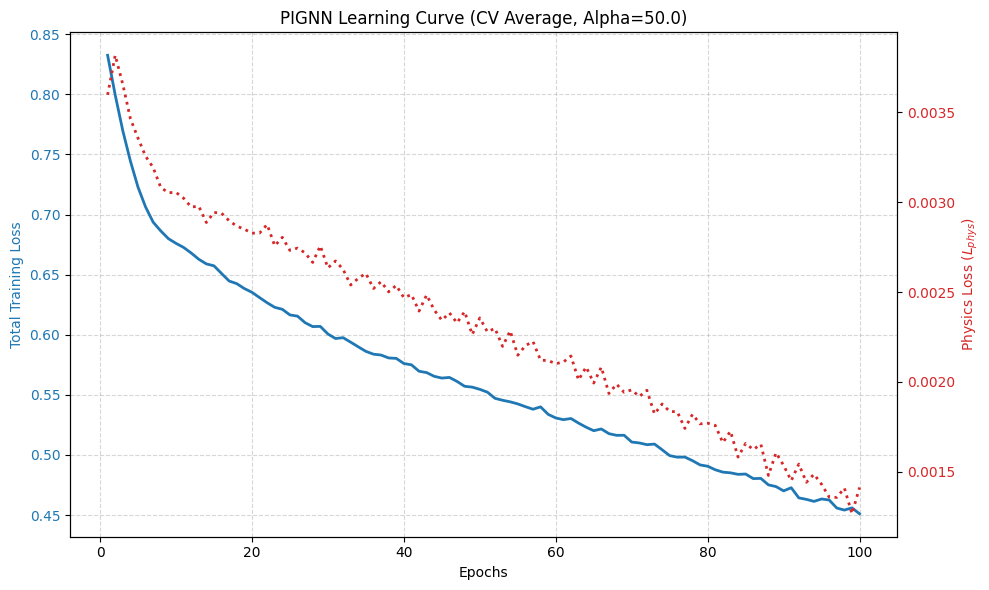

In [ ]:
# ==========================================
# 2. メイン実行セクション (CVループ) - 学習曲線記録版
# ==========================================
import matplotlib.pyplot as plt # 追加

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 論文同様、固定値で評価（0, 1.0, 10.0など）
FIXED_ALPHA = 50.0

v16_load_path = "/content/drive/MyDrive/GNN_Football_Analysis/Processed_Data/gnn_data_v17_final.pt"
print(f"CV用マスターデータをロード中: {v16_load_path}")
checkpoint = torch.load(v16_load_path, weights_only=False)
all_data_list = checkpoint['all_data']

# --- 【修正】推測ロジックを削除し、刻印されたIDを直接取得 ---
match_ids = sorted(list(set([int(d.match_id.item()) for d in all_data_list])))
print(f"検出された試合ID: {match_ids} (計 {len(match_ids)} 試合)")

# ハイパーパラメータ
EPOCHS_CV =100
LR = 0.0005
cv_final_reports = []
best_overall_f1 = 0

# --- 【追加】全CVの学習ログを保存する箱 ---
all_cv_history = []

print(f"PIGNN クロスバリデーション開始 (Alpha={FIXED_ALPHA} 固定モード)\n")

for test_match in match_ids:
    print(f"\n{'='*60}")
    print(f" 🌀 Round: Match {test_match} をテストに使用")
    print(f"{'='*60}")

    # 1. 刻印された match_id を信じて切り分け
    test_indices = [d for d in all_data_list if int(d.match_id.item()) == test_match]
    train_candidates = [d for d in all_data_list if int(d.match_id.item()) != test_match]

    # 2. 訓練データのみ1:1アンダーサンプリング
    cv_train_set = balance_dataset_by_undersampling(train_candidates)

    cv_train_loader = DataLoader(cv_train_set, batch_size=32, shuffle=True)
    cv_test_loader = DataLoader(test_indices, batch_size=32, shuffle=False)

    cv_model = PIGNNClassifier(hidden_channels=64).to(device)
    cv_optimizer = torch.optim.Adam(cv_model.parameters(), lr=LR)

    # --- 【追加】このRoundのログを保持する辞書 ---
    round_history = {'total_loss': [], 'physics_loss': []}

    # 3. 学習ループ (固定Alpha版)
    for epoch in range(1, EPOCHS_CV + 1):
        loss, phys, _ = train_pignn_epoch_fixed(cv_model, cv_train_loader, cv_optimizer, device, FIXED_ALPHA)

        # --- 【追加】ログを記録 ---
        round_history['total_loss'].append(loss)
        round_history['physics_loss'].append(phys)

        if epoch % 10 == 0 or epoch == 1:
            print(f"  Epoch {epoch:02d} | Loss: {loss:.4f} | Phys_L: {phys:.6f}")

    all_cv_history.append(round_history) # 追加

    # 4. 評価
    cv_model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for data in cv_test_loader:
            data = data.to(device)
            out = cv_model(data)
            y_true.extend(data.y.view(-1).cpu().numpy())
            y_pred.extend(out.argmax(dim=1).cpu().numpy())

    # スコア集計
    report = classification_report(y_true, y_pred, output_dict=True, zero_division=0)
    current_f1 = report['1']['f1-score']

    cv_final_reports.append({
        'match': test_match,
        'recall': report['1']['recall'],
        'precision': report['1']['precision'],
        'f1': current_f1
    })

    # --- α別にフォルダを分けて整理保存 ---
    import os
    base_model_dir = "/content/drive/MyDrive/GNN_Football_Analysis/Models"
    alpha_dir = os.path.join(base_model_dir, f"alpha_{str(FIXED_ALPHA).replace('.', '_')}_take3")
    os.makedirs(alpha_dir, exist_ok=True)

    model_filename = f'pignn_testmatch_{test_match}.pth'
    model_path = os.path.join(alpha_dir, model_filename)
    torch.save(cv_model.state_dict(), model_path)
    print(f" >> [Alpha {FIXED_ALPHA}] Match {test_match} weight saved.")

    if current_f1 > best_overall_f1:
        best_overall_f1 = current_f1
        best_model_path = os.path.join(alpha_dir, f'best_overall_alpha_{FIXED_ALPHA}.pth')
        torch.save(cv_model.state_dict(), best_model_path)
        print(f" ✨ [Alpha {FIXED_ALPHA}] New Best Model Saved: F1={best_overall_f1:.4f}")

    print(f" >> Result: Recall={report['1']['recall']:.4f}, Precision={report['1']['precision']:.4f}, F1={current_f1:.4f}")

# 5. 最終集計
print(f"\n\n{'#'*60}\n 🏆 Alpha={FIXED_ALPHA} CV 最終平均結果\n{'#'*60}")
avg_recall = np.mean([r['recall'] for r in cv_final_reports])
avg_f1 = np.mean([r['f1'] for r in cv_final_reports])
avg_precision = np.mean([r['precision'] for r in cv_final_reports])

print(f"\n[OVERALL] Avg Success Recall:     {avg_recall:.4f}")
print(f"[OVERALL] Avg Success Precision: {avg_precision:.4f}")
print(f"[OVERALL] Avg Success F1-score:  {avg_f1:.4f}")

# ==========================================
# 6. 学習曲線の描画 (CV平均) - 【追加セクション】
# ==========================================
avg_total_loss = np.mean([h['total_loss'] for h in all_cv_history], axis=0)
avg_phys_loss = np.mean([h['physics_loss'] for h in all_cv_history], axis=0)
epochs_range = range(1, EPOCHS_CV + 1)

fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.set_xlabel('Epochs')
ax1.set_ylabel('Total Training Loss', color='tab:blue')
ax1.plot(epochs_range, avg_total_loss, color='tab:blue', lw=2, label='Total Loss (Avg)')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.grid(True, linestyle='--', alpha=0.5)

ax2 = ax1.twinx()
ax2.set_ylabel('Physics Loss ($L_{phys}$)', color='tab:red')
ax2.plot(epochs_range, avg_phys_loss, color='tab:red', lw=2, linestyle=':', label='Physics Loss (Avg)')
ax2.tick_params(axis='y', labelcolor='tab:red')

plt.title(f'PIGNN Learning Curve (CV Average, Alpha={FIXED_ALPHA})')
fig.tight_layout()
plt.show()

CV用マスターデータをロード中: /content/drive/MyDrive/GNN_Football_Analysis/Processed_Data/gnn_data_v17_final.pt
検出された試合ID: [1, 2, 3, 4, 5, 6, 7] (計 7 試合)
PIGNN クロスバリデーション開始 (Alpha=0 固定モード)


 🌀 Round: Match 1 をテストに使用
    [Sampling] Success Seqs: 151 | Failure Seqs: 151 | Total Frames: 379
  Epoch 01 | Loss: 0.6812 | Phys_L: 0.003004
  Epoch 10 | Loss: 0.5147 | Phys_L: 0.003444
  Epoch 20 | Loss: 0.4703 | Phys_L: 0.003287
  Epoch 30 | Loss: 0.4445 | Phys_L: 0.002952
  Epoch 40 | Loss: 0.4333 | Phys_L: 0.002918
  Epoch 50 | Loss: 0.4236 | Phys_L: 0.002869
  Epoch 60 | Loss: 0.4039 | Phys_L: 0.002909
  Epoch 70 | Loss: 0.3899 | Phys_L: 0.002658
  Epoch 80 | Loss: 0.3636 | Phys_L: 0.002230
  Epoch 90 | Loss: 0.3220 | Phys_L: 0.002055
  Epoch 100 | Loss: 0.3059 | Phys_L: 0.001790
 >> [Alpha 0] Match 1 weight saved.
 ✨ [Alpha 0] New Best Model Saved: F1=0.3276
 >> Result: Recall=0.5854, Precision=0.2275, F1=0.3276

 🌀 Round: Match 2 をテストに使用
    [Sampling] Success Seqs: 190 | Failure Seqs: 190 | Total Fra

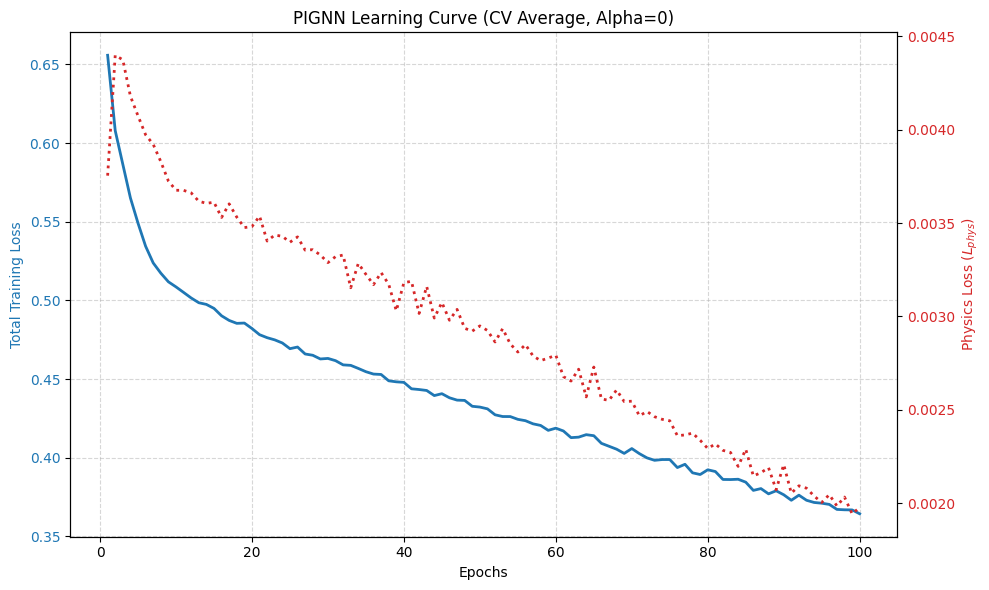

In [ ]:
# ==========================================
# 2. メイン実行セクション (CVループ) - 学習曲線記録版
# ==========================================
import matplotlib.pyplot as plt # 追加

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 論文同様、固定値で評価（0, 1.0, 10.0など）
FIXED_ALPHA = 0

v16_load_path = "/content/drive/MyDrive/GNN_Football_Analysis/Processed_Data/gnn_data_v17_final.pt"
print(f"CV用マスターデータをロード中: {v16_load_path}")
checkpoint = torch.load(v16_load_path, weights_only=False)
all_data_list = checkpoint['all_data']

# --- 【修正】推測ロジックを削除し、刻印されたIDを直接取得 ---
match_ids = sorted(list(set([int(d.match_id.item()) for d in all_data_list])))
print(f"検出された試合ID: {match_ids} (計 {len(match_ids)} 試合)")

# ハイパーパラメータ
EPOCHS_CV =100
LR = 0.0005
cv_final_reports = []
best_overall_f1 = 0

# --- 【追加】全CVの学習ログを保存する箱 ---
all_cv_history = []

print(f"PIGNN クロスバリデーション開始 (Alpha={FIXED_ALPHA} 固定モード)\n")

for test_match in match_ids:
    print(f"\n{'='*60}")
    print(f" 🌀 Round: Match {test_match} をテストに使用")
    print(f"{'='*60}")

    # 1. 刻印された match_id を信じて切り分け
    test_indices = [d for d in all_data_list if int(d.match_id.item()) == test_match]
    train_candidates = [d for d in all_data_list if int(d.match_id.item()) != test_match]

    # 2. 訓練データのみ1:1アンダーサンプリング
    cv_train_set = balance_dataset_by_undersampling(train_candidates)

    cv_train_loader = DataLoader(cv_train_set, batch_size=32, shuffle=True)
    cv_test_loader = DataLoader(test_indices, batch_size=32, shuffle=False)

    cv_model = PIGNNClassifier(hidden_channels=64).to(device)
    cv_optimizer = torch.optim.Adam(cv_model.parameters(), lr=LR)

    # --- 【追加】このRoundのログを保持する辞書 ---
    round_history = {'total_loss': [], 'physics_loss': []}

    # 3. 学習ループ (固定Alpha版)
    for epoch in range(1, EPOCHS_CV + 1):
        loss, phys, _ = train_pignn_epoch_fixed(cv_model, cv_train_loader, cv_optimizer, device, FIXED_ALPHA)

        # --- 【追加】ログを記録 ---
        round_history['total_loss'].append(loss)
        round_history['physics_loss'].append(phys)

        if epoch % 10 == 0 or epoch == 1:
            print(f"  Epoch {epoch:02d} | Loss: {loss:.4f} | Phys_L: {phys:.6f}")

    all_cv_history.append(round_history) # 追加

    # 4. 評価
    cv_model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for data in cv_test_loader:
            data = data.to(device)
            out = cv_model(data)
            y_true.extend(data.y.view(-1).cpu().numpy())
            y_pred.extend(out.argmax(dim=1).cpu().numpy())

    # スコア集計
    report = classification_report(y_true, y_pred, output_dict=True, zero_division=0)
    current_f1 = report['1']['f1-score']

    cv_final_reports.append({
        'match': test_match,
        'recall': report['1']['recall'],
        'precision': report['1']['precision'],
        'f1': current_f1
    })

    # --- α別にフォルダを分けて整理保存 ---
    import os
    base_model_dir = "/content/drive/MyDrive/GNN_Football_Analysis/Models"
    alpha_dir = os.path.join(base_model_dir, f"alpha_{str(FIXED_ALPHA).replace('.', '_')}_take3")
    os.makedirs(alpha_dir, exist_ok=True)

    model_filename = f'pignn_testmatch_{test_match}.pth'
    model_path = os.path.join(alpha_dir, model_filename)
    torch.save(cv_model.state_dict(), model_path)
    print(f" >> [Alpha {FIXED_ALPHA}] Match {test_match} weight saved.")

    if current_f1 > best_overall_f1:
        best_overall_f1 = current_f1
        best_model_path = os.path.join(alpha_dir, f'best_overall_alpha_{FIXED_ALPHA}.pth')
        torch.save(cv_model.state_dict(), best_model_path)
        print(f" ✨ [Alpha {FIXED_ALPHA}] New Best Model Saved: F1={best_overall_f1:.4f}")

    print(f" >> Result: Recall={report['1']['recall']:.4f}, Precision={report['1']['precision']:.4f}, F1={current_f1:.4f}")

# 5. 最終集計
print(f"\n\n{'#'*60}\n 🏆 Alpha={FIXED_ALPHA} CV 最終平均結果\n{'#'*60}")
avg_recall = np.mean([r['recall'] for r in cv_final_reports])
avg_f1 = np.mean([r['f1'] for r in cv_final_reports])
avg_precision = np.mean([r['precision'] for r in cv_final_reports])

print(f"\n[OVERALL] Avg Success Recall:     {avg_recall:.4f}")
print(f"[OVERALL] Avg Success Precision: {avg_precision:.4f}")
print(f"[OVERALL] Avg Success F1-score:  {avg_f1:.4f}")

# ==========================================
# 6. 学習曲線の描画 (CV平均) - 【追加セクション】
# ==========================================
avg_total_loss = np.mean([h['total_loss'] for h in all_cv_history], axis=0)
avg_phys_loss = np.mean([h['physics_loss'] for h in all_cv_history], axis=0)
epochs_range = range(1, EPOCHS_CV + 1)

fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.set_xlabel('Epochs')
ax1.set_ylabel('Total Training Loss', color='tab:blue')
ax1.plot(epochs_range, avg_total_loss, color='tab:blue', lw=2, label='Total Loss (Avg)')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.grid(True, linestyle='--', alpha=0.5)

ax2 = ax1.twinx()
ax2.set_ylabel('Physics Loss ($L_{phys}$)', color='tab:red')
ax2.plot(epochs_range, avg_phys_loss, color='tab:red', lw=2, linestyle=':', label='Physics Loss (Avg)')
ax2.tick_params(axis='y', labelcolor='tab:red')

plt.title(f'PIGNN Learning Curve (CV Average, Alpha={FIXED_ALPHA})')
fig.tight_layout()
plt.show()

CV用マスターデータをロード中: /content/drive/MyDrive/GNN_Football_Analysis/Processed_Data/gnn_data_v17_final.pt
検出された試合ID: [1, 2, 3, 4, 5, 6, 7] (計 7 試合)
PIGNN クロスバリデーション開始 (Alpha=10.0 固定モード)


 🌀 Round: Match 1 をテストに使用
    [Sampling] Success Seqs: 151 | Failure Seqs: 151 | Total Frames: 374
  Epoch 01 | Loss: 0.7133 | Phys_L: 0.003376
  Epoch 10 | Loss: 0.5386 | Phys_L: 0.003532
  Epoch 20 | Loss: 0.4896 | Phys_L: 0.003178
  Epoch 30 | Loss: 0.4476 | Phys_L: 0.002821
  Epoch 40 | Loss: 0.4261 | Phys_L: 0.002674
  Epoch 50 | Loss: 0.4029 | Phys_L: 0.002449
  Epoch 60 | Loss: 0.3851 | Phys_L: 0.002328
  Epoch 70 | Loss: 0.3638 | Phys_L: 0.001676
  Epoch 80 | Loss: 0.3490 | Phys_L: 0.001520
  Epoch 90 | Loss: 0.3410 | Phys_L: 0.001315
  Epoch 100 | Loss: 0.3269 | Phys_L: 0.001223
 >> [Alpha 10.0] Match 1 weight saved.
 ✨ [Alpha 10.0] New Best Model Saved: F1=0.2524
 >> Result: Recall=0.4756, Precision=0.1718, F1=0.2524

 🌀 Round: Match 2 をテストに使用
    [Sampling] Success Seqs: 190 | Failure Seqs: 190 | 

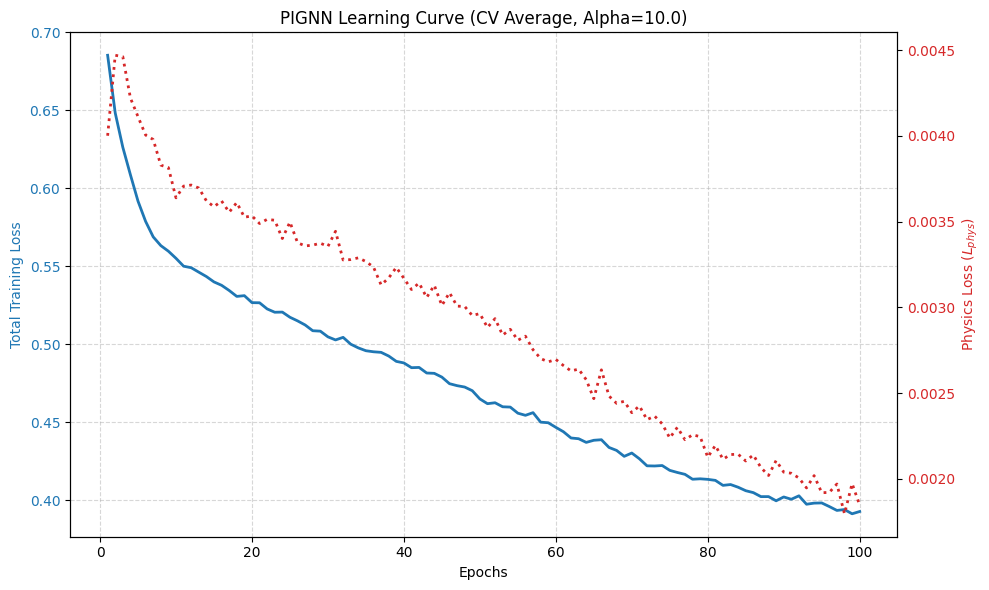

In [ ]:
# ==========================================
# 2. メイン実行セクション (CVループ) - 学習曲線記録版
# ==========================================
import matplotlib.pyplot as plt # 追加

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 論文同様、固定値で評価（0, 1.0, 10.0など）
FIXED_ALPHA = 10.0

v16_load_path = "/content/drive/MyDrive/GNN_Football_Analysis/Processed_Data/gnn_data_v17_final.pt"
print(f"CV用マスターデータをロード中: {v16_load_path}")
checkpoint = torch.load(v16_load_path, weights_only=False)
all_data_list = checkpoint['all_data']

# --- 【修正】推測ロジックを削除し、刻印されたIDを直接取得 ---
match_ids = sorted(list(set([int(d.match_id.item()) for d in all_data_list])))
print(f"検出された試合ID: {match_ids} (計 {len(match_ids)} 試合)")

# ハイパーパラメータ
EPOCHS_CV =100
LR = 0.0005
cv_final_reports = []
best_overall_f1 = 0

# --- 【追加】全CVの学習ログを保存する箱 ---
all_cv_history = []

print(f"PIGNN クロスバリデーション開始 (Alpha={FIXED_ALPHA} 固定モード)\n")

for test_match in match_ids:
    print(f"\n{'='*60}")
    print(f" 🌀 Round: Match {test_match} をテストに使用")
    print(f"{'='*60}")

    # 1. 刻印された match_id を信じて切り分け
    test_indices = [d for d in all_data_list if int(d.match_id.item()) == test_match]
    train_candidates = [d for d in all_data_list if int(d.match_id.item()) != test_match]

    # 2. 訓練データのみ1:1アンダーサンプリング
    cv_train_set = balance_dataset_by_undersampling(train_candidates)

    cv_train_loader = DataLoader(cv_train_set, batch_size=32, shuffle=True)
    cv_test_loader = DataLoader(test_indices, batch_size=32, shuffle=False)

    cv_model = PIGNNClassifier(hidden_channels=64).to(device)
    cv_optimizer = torch.optim.Adam(cv_model.parameters(), lr=LR)

    # --- 【追加】このRoundのログを保持する辞書 ---
    round_history = {'total_loss': [], 'physics_loss': []}

    # 3. 学習ループ (固定Alpha版)
    for epoch in range(1, EPOCHS_CV + 1):
        loss, phys, _ = train_pignn_epoch_fixed(cv_model, cv_train_loader, cv_optimizer, device, FIXED_ALPHA)

        # --- 【追加】ログを記録 ---
        round_history['total_loss'].append(loss)
        round_history['physics_loss'].append(phys)

        if epoch % 10 == 0 or epoch == 1:
            print(f"  Epoch {epoch:02d} | Loss: {loss:.4f} | Phys_L: {phys:.6f}")

    all_cv_history.append(round_history) # 追加

    # 4. 評価
    cv_model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for data in cv_test_loader:
            data = data.to(device)
            out = cv_model(data)
            y_true.extend(data.y.view(-1).cpu().numpy())
            y_pred.extend(out.argmax(dim=1).cpu().numpy())

    # スコア集計
    report = classification_report(y_true, y_pred, output_dict=True, zero_division=0)
    current_f1 = report['1']['f1-score']

    cv_final_reports.append({
        'match': test_match,
        'recall': report['1']['recall'],
        'precision': report['1']['precision'],
        'f1': current_f1
    })

    # --- α別にフォルダを分けて整理保存 ---
    import os
    base_model_dir = "/content/drive/MyDrive/GNN_Football_Analysis/Models"
    alpha_dir = os.path.join(base_model_dir, f"alpha_{str(FIXED_ALPHA).replace('.', '_')}_take3")
    os.makedirs(alpha_dir, exist_ok=True)

    model_filename = f'pignn_testmatch_{test_match}.pth'
    model_path = os.path.join(alpha_dir, model_filename)
    torch.save(cv_model.state_dict(), model_path)
    print(f" >> [Alpha {FIXED_ALPHA}] Match {test_match} weight saved.")

    if current_f1 > best_overall_f1:
        best_overall_f1 = current_f1
        best_model_path = os.path.join(alpha_dir, f'best_overall_alpha_{FIXED_ALPHA}.pth')
        torch.save(cv_model.state_dict(), best_model_path)
        print(f" ✨ [Alpha {FIXED_ALPHA}] New Best Model Saved: F1={best_overall_f1:.4f}")

    print(f" >> Result: Recall={report['1']['recall']:.4f}, Precision={report['1']['precision']:.4f}, F1={current_f1:.4f}")

# 5. 最終集計
print(f"\n\n{'#'*60}\n 🏆 Alpha={FIXED_ALPHA} CV 最終平均結果\n{'#'*60}")
avg_recall = np.mean([r['recall'] for r in cv_final_reports])
avg_f1 = np.mean([r['f1'] for r in cv_final_reports])
avg_precision = np.mean([r['precision'] for r in cv_final_reports])

print(f"\n[OVERALL] Avg Success Recall:     {avg_recall:.4f}")
print(f"[OVERALL] Avg Success Precision: {avg_precision:.4f}")
print(f"[OVERALL] Avg Success F1-score:  {avg_f1:.4f}")

# ==========================================
# 6. 学習曲線の描画 (CV平均) - 【追加セクション】
# ==========================================
avg_total_loss = np.mean([h['total_loss'] for h in all_cv_history], axis=0)
avg_phys_loss = np.mean([h['physics_loss'] for h in all_cv_history], axis=0)
epochs_range = range(1, EPOCHS_CV + 1)

fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.set_xlabel('Epochs')
ax1.set_ylabel('Total Training Loss', color='tab:blue')
ax1.plot(epochs_range, avg_total_loss, color='tab:blue', lw=2, label='Total Loss (Avg)')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.grid(True, linestyle='--', alpha=0.5)

ax2 = ax1.twinx()
ax2.set_ylabel('Physics Loss ($L_{phys}$)', color='tab:red')
ax2.plot(epochs_range, avg_phys_loss, color='tab:red', lw=2, linestyle=':', label='Physics Loss (Avg)')
ax2.tick_params(axis='y', labelcolor='tab:red')

plt.title(f'PIGNN Learning Curve (CV Average, Alpha={FIXED_ALPHA})')
fig.tight_layout()
plt.show()

CV用マスターデータをロード中: /content/drive/MyDrive/GNN_Football_Analysis/Processed_Data/gnn_data_v17_final.pt
検出された試合ID: [1, 2, 3, 4, 5, 6, 7] (計 7 試合)
PIGNN クロスバリデーション開始 (Alpha=100.0 固定モード)


 🌀 Round: Match 1 をテストに使用
    [Sampling] Success Seqs: 151 | Failure Seqs: 151 | Total Frames: 384
  Epoch 01 | Loss: 1.0316 | Phys_L: 0.003563
  Epoch 10 | Loss: 0.8066 | Phys_L: 0.002586
  Epoch 20 | Loss: 0.7105 | Phys_L: 0.002209
  Epoch 30 | Loss: 0.6288 | Phys_L: 0.001914
  Epoch 40 | Loss: 0.5867 | Phys_L: 0.001766
  Epoch 50 | Loss: 0.5331 | Phys_L: 0.001544
  Epoch 60 | Loss: 0.4890 | Phys_L: 0.001294
  Epoch 70 | Loss: 0.4579 | Phys_L: 0.001240
  Epoch 80 | Loss: 0.4311 | Phys_L: 0.000904
  Epoch 90 | Loss: 0.4140 | Phys_L: 0.000812
  Epoch 100 | Loss: 0.4091 | Phys_L: 0.000712
 >> [Alpha 100.0] Match 1 weight saved.
 ✨ [Alpha 100.0] New Best Model Saved: F1=0.3333
 >> Result: Recall=0.4634, Precision=0.2603, F1=0.3333

 🌀 Round: Match 2 をテストに使用
    [Sampling] Success Seqs: 190 | Failure Seqs: 190

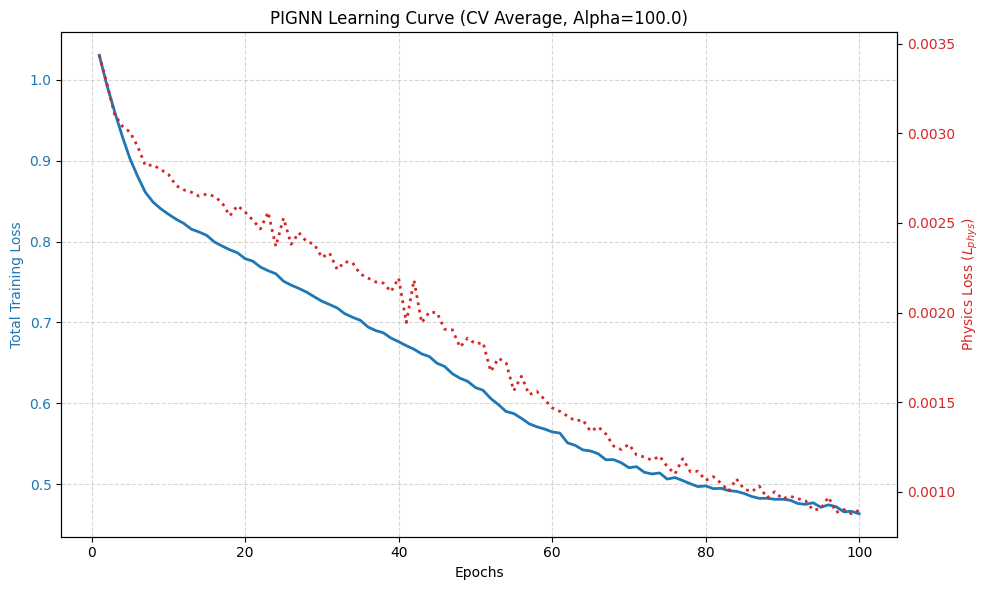

In [ ]:
# ==========================================
# 2. メイン実行セクション (CVループ) - 学習曲線記録版
# ==========================================
import matplotlib.pyplot as plt # 追加

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 論文同様、固定値で評価（0, 1.0, 10.0など）
FIXED_ALPHA = 100.0
v16_load_path = "/content/drive/MyDrive/GNN_Football_Analysis/Processed_Data/gnn_data_v17_final.pt"
print(f"CV用マスターデータをロード中: {v16_load_path}")
checkpoint = torch.load(v16_load_path, weights_only=False)
all_data_list = checkpoint['all_data']

# --- 【修正】推測ロジックを削除し、刻印されたIDを直接取得 ---
match_ids = sorted(list(set([int(d.match_id.item()) for d in all_data_list])))
print(f"検出された試合ID: {match_ids} (計 {len(match_ids)} 試合)")

# ハイパーパラメータ
EPOCHS_CV =100
LR = 0.0005
cv_final_reports = []
best_overall_f1 = 0

# --- 【追加】全CVの学習ログを保存する箱 ---
all_cv_history = []

print(f"PIGNN クロスバリデーション開始 (Alpha={FIXED_ALPHA} 固定モード)\n")

for test_match in match_ids:
    print(f"\n{'='*60}")
    print(f" 🌀 Round: Match {test_match} をテストに使用")
    print(f"{'='*60}")

    # 1. 刻印された match_id を信じて切り分け
    test_indices = [d for d in all_data_list if int(d.match_id.item()) == test_match]
    train_candidates = [d for d in all_data_list if int(d.match_id.item()) != test_match]

    # 2. 訓練データのみ1:1アンダーサンプリング
    cv_train_set = balance_dataset_by_undersampling(train_candidates)

    cv_train_loader = DataLoader(cv_train_set, batch_size=32, shuffle=True)
    cv_test_loader = DataLoader(test_indices, batch_size=32, shuffle=False)

    cv_model = PIGNNClassifier(hidden_channels=64).to(device)
    cv_optimizer = torch.optim.Adam(cv_model.parameters(), lr=LR)

    # --- 【追加】このRoundのログを保持する辞書 ---
    round_history = {'total_loss': [], 'physics_loss': []}

    # 3. 学習ループ (固定Alpha版)
    for epoch in range(1, EPOCHS_CV + 1):
        loss, phys, _ = train_pignn_epoch_fixed(cv_model, cv_train_loader, cv_optimizer, device, FIXED_ALPHA)

        # --- 【追加】ログを記録 ---
        round_history['total_loss'].append(loss)
        round_history['physics_loss'].append(phys)

        if epoch % 10 == 0 or epoch == 1:
            print(f"  Epoch {epoch:02d} | Loss: {loss:.4f} | Phys_L: {phys:.6f}")

    all_cv_history.append(round_history) # 追加

    # 4. 評価
    cv_model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for data in cv_test_loader:
            data = data.to(device)
            out = cv_model(data)
            y_true.extend(data.y.view(-1).cpu().numpy())
            y_pred.extend(out.argmax(dim=1).cpu().numpy())

    # スコア集計
    report = classification_report(y_true, y_pred, output_dict=True, zero_division=0)
    current_f1 = report['1']['f1-score']

    cv_final_reports.append({
        'match': test_match,
        'recall': report['1']['recall'],
        'precision': report['1']['precision'],
        'f1': current_f1
    })

    # --- α別にフォルダを分けて整理保存 ---
    import os
    base_model_dir = "/content/drive/MyDrive/GNN_Football_Analysis/Models"
    alpha_dir = os.path.join(base_model_dir, f"alpha_{str(FIXED_ALPHA).replace('.', '_')}_take3")
    os.makedirs(alpha_dir, exist_ok=True)

    model_filename = f'pignn_testmatch_{test_match}.pth'
    model_path = os.path.join(alpha_dir, model_filename)
    torch.save(cv_model.state_dict(), model_path)
    print(f" >> [Alpha {FIXED_ALPHA}] Match {test_match} weight saved.")

    if current_f1 > best_overall_f1:
        best_overall_f1 = current_f1
        best_model_path = os.path.join(alpha_dir, f'best_overall_alpha_{FIXED_ALPHA}.pth')
        torch.save(cv_model.state_dict(), best_model_path)
        print(f" ✨ [Alpha {FIXED_ALPHA}] New Best Model Saved: F1={best_overall_f1:.4f}")

    print(f" >> Result: Recall={report['1']['recall']:.4f}, Precision={report['1']['precision']:.4f}, F1={current_f1:.4f}")

# 5. 最終集計
print(f"\n\n{'#'*60}\n 🏆 Alpha={FIXED_ALPHA} CV 最終平均結果\n{'#'*60}")
avg_recall = np.mean([r['recall'] for r in cv_final_reports])
avg_f1 = np.mean([r['f1'] for r in cv_final_reports])
avg_precision = np.mean([r['precision'] for r in cv_final_reports])

print(f"\n[OVERALL] Avg Success Recall:     {avg_recall:.4f}")
print(f"[OVERALL] Avg Success Precision: {avg_precision:.4f}")
print(f"[OVERALL] Avg Success F1-score:  {avg_f1:.4f}")

# ==========================================
# 6. 学習曲線の描画 (CV平均) - 【追加セクション】
# ==========================================
avg_total_loss = np.mean([h['total_loss'] for h in all_cv_history], axis=0)
avg_phys_loss = np.mean([h['physics_loss'] for h in all_cv_history], axis=0)
epochs_range = range(1, EPOCHS_CV + 1)

fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.set_xlabel('Epochs')
ax1.set_ylabel('Total Training Loss', color='tab:blue')
ax1.plot(epochs_range, avg_total_loss, color='tab:blue', lw=2, label='Total Loss (Avg)')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.grid(True, linestyle='--', alpha=0.5)

ax2 = ax1.twinx()
ax2.set_ylabel('Physics Loss ($L_{phys}$)', color='tab:red')
ax2.plot(epochs_range, avg_phys_loss, color='tab:red', lw=2, linestyle=':', label='Physics Loss (Avg)')
ax2.tick_params(axis='y', labelcolor='tab:red')

plt.title(f'PIGNN Learning Curve (CV Average, Alpha={FIXED_ALPHA})')
fig.tight_layout()
plt.show()

CV用マスターデータをロード中: /content/drive/MyDrive/GNN_Football_Analysis/Processed_Data/gnn_data_v17_final.pt
検出された試合ID: [1, 2, 3, 4, 5, 6, 7] (計 7 試合)
PIGNN クロスバリデーション開始 (Alpha=200.0 固定モード)


 🌀 Round: Match 1 をテストに使用
    [Sampling] Success Seqs: 151 | Failure Seqs: 151 | Total Frames: 369
  Epoch 01 | Loss: 1.3165 | Phys_L: 0.003078
  Epoch 10 | Loss: 1.0307 | Phys_L: 0.002109
  Epoch 20 | Loss: 0.9261 | Phys_L: 0.001891
  Epoch 30 | Loss: 0.8534 | Phys_L: 0.001682
  Epoch 40 | Loss: 0.7862 | Phys_L: 0.001612
  Epoch 50 | Loss: 0.6920 | Phys_L: 0.001423
  Epoch 60 | Loss: 0.6032 | Phys_L: 0.000990
  Epoch 70 | Loss: 0.5628 | Phys_L: 0.000619
  Epoch 80 | Loss: 0.5243 | Phys_L: 0.000596
  Epoch 90 | Loss: 0.4977 | Phys_L: 0.000586
  Epoch 100 | Loss: 0.4974 | Phys_L: 0.000498
 >> [Alpha 200.0] Match 1 weight saved.
 ✨ [Alpha 200.0] New Best Model Saved: F1=0.3203
 >> Result: Recall=0.4512, Precision=0.2483, F1=0.3203

 🌀 Round: Match 2 をテストに使用
    [Sampling] Success Seqs: 190 | Failure Seqs: 190

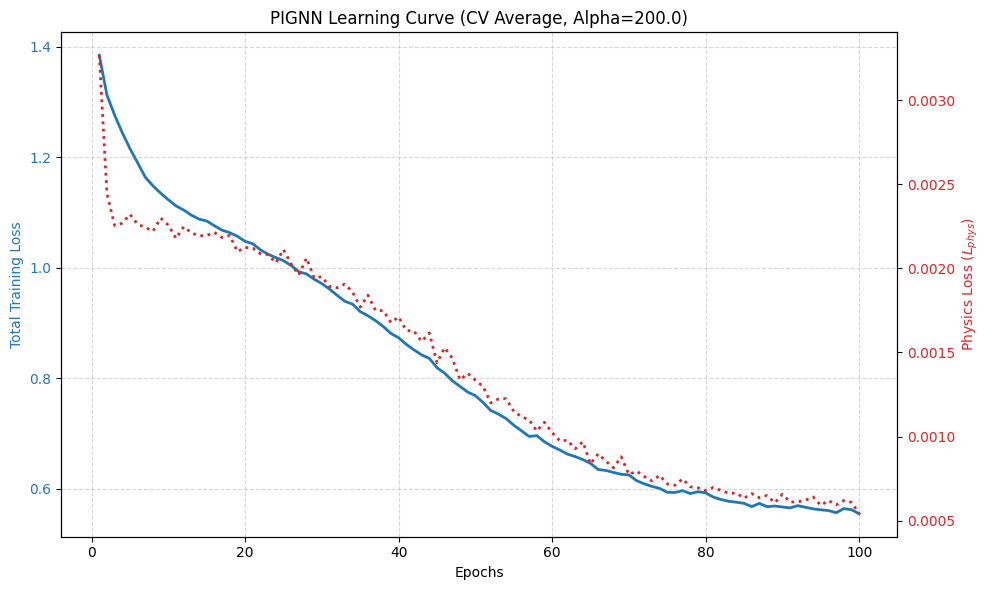

In [ ]:
# ==========================================
# 2. メイン実行セクション (CVループ) - 学習曲線記録版
# ==========================================
import matplotlib.pyplot as plt # 追加

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 論文同様、固定値で評価（0, 1.0, 10.0など）
FIXED_ALPHA = 200.0
v16_load_path = "/content/drive/MyDrive/GNN_Football_Analysis/Processed_Data/gnn_data_v17_final.pt"
print(f"CV用マスターデータをロード中: {v16_load_path}")
checkpoint = torch.load(v16_load_path, weights_only=False)
all_data_list = checkpoint['all_data']

# --- 【修正】推測ロジックを削除し、刻印されたIDを直接取得 ---
match_ids = sorted(list(set([int(d.match_id.item()) for d in all_data_list])))
print(f"検出された試合ID: {match_ids} (計 {len(match_ids)} 試合)")

# ハイパーパラメータ
EPOCHS_CV =100
LR = 0.0005
cv_final_reports = []
best_overall_f1 = 0

# --- 【追加】全CVの学習ログを保存する箱 ---
all_cv_history = []

print(f"PIGNN クロスバリデーション開始 (Alpha={FIXED_ALPHA} 固定モード)\n")

for test_match in match_ids:
    print(f"\n{'='*60}")
    print(f" 🌀 Round: Match {test_match} をテストに使用")
    print(f"{'='*60}")

    # 1. 刻印された match_id を信じて切り分け
    test_indices = [d for d in all_data_list if int(d.match_id.item()) == test_match]
    train_candidates = [d for d in all_data_list if int(d.match_id.item()) != test_match]

    # 2. 訓練データのみ1:1アンダーサンプリング
    cv_train_set = balance_dataset_by_undersampling(train_candidates)

    cv_train_loader = DataLoader(cv_train_set, batch_size=32, shuffle=True)
    cv_test_loader = DataLoader(test_indices, batch_size=32, shuffle=False)

    cv_model = PIGNNClassifier(hidden_channels=64).to(device)
    cv_optimizer = torch.optim.Adam(cv_model.parameters(), lr=LR)

    # --- 【追加】このRoundのログを保持する辞書 ---
    round_history = {'total_loss': [], 'physics_loss': []}

    # 3. 学習ループ (固定Alpha版)
    for epoch in range(1, EPOCHS_CV + 1):
        loss, phys, _ = train_pignn_epoch_fixed(cv_model, cv_train_loader, cv_optimizer, device, FIXED_ALPHA)

        # --- 【追加】ログを記録 ---
        round_history['total_loss'].append(loss)
        round_history['physics_loss'].append(phys)

        if epoch % 10 == 0 or epoch == 1:
            print(f"  Epoch {epoch:02d} | Loss: {loss:.4f} | Phys_L: {phys:.6f}")

    all_cv_history.append(round_history) # 追加

    # 4. 評価
    cv_model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for data in cv_test_loader:
            data = data.to(device)
            out = cv_model(data)
            y_true.extend(data.y.view(-1).cpu().numpy())
            y_pred.extend(out.argmax(dim=1).cpu().numpy())

    # スコア集計
    report = classification_report(y_true, y_pred, output_dict=True, zero_division=0)
    current_f1 = report['1']['f1-score']

    cv_final_reports.append({
        'match': test_match,
        'recall': report['1']['recall'],
        'precision': report['1']['precision'],
        'f1': current_f1
    })

    # --- α別にフォルダを分けて整理保存 ---
    import os
    base_model_dir = "/content/drive/MyDrive/GNN_Football_Analysis/Models"
    alpha_dir = os.path.join(base_model_dir, f"alpha_{str(FIXED_ALPHA).replace('.', '_')}_take3")
    os.makedirs(alpha_dir, exist_ok=True)

    model_filename = f'pignn_testmatch_{test_match}.pth'
    model_path = os.path.join(alpha_dir, model_filename)
    torch.save(cv_model.state_dict(), model_path)
    print(f" >> [Alpha {FIXED_ALPHA}] Match {test_match} weight saved.")

    if current_f1 > best_overall_f1:
        best_overall_f1 = current_f1
        best_model_path = os.path.join(alpha_dir, f'best_overall_alpha_{FIXED_ALPHA}.pth')
        torch.save(cv_model.state_dict(), best_model_path)
        print(f" ✨ [Alpha {FIXED_ALPHA}] New Best Model Saved: F1={best_overall_f1:.4f}")

    print(f" >> Result: Recall={report['1']['recall']:.4f}, Precision={report['1']['precision']:.4f}, F1={current_f1:.4f}")

# 5. 最終集計
print(f"\n\n{'#'*60}\n 🏆 Alpha={FIXED_ALPHA} CV 最終平均結果\n{'#'*60}")
avg_recall = np.mean([r['recall'] for r in cv_final_reports])
avg_f1 = np.mean([r['f1'] for r in cv_final_reports])
avg_precision = np.mean([r['precision'] for r in cv_final_reports])

print(f"\n[OVERALL] Avg Success Recall:     {avg_recall:.4f}")
print(f"[OVERALL] Avg Success Precision: {avg_precision:.4f}")
print(f"[OVERALL] Avg Success F1-score:  {avg_f1:.4f}")

# ==========================================
# 6. 学習曲線の描画 (CV平均) - 【追加セクション】
# ==========================================
avg_total_loss = np.mean([h['total_loss'] for h in all_cv_history], axis=0)
avg_phys_loss = np.mean([h['physics_loss'] for h in all_cv_history], axis=0)
epochs_range = range(1, EPOCHS_CV + 1)

fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.set_xlabel('Epochs')
ax1.set_ylabel('Total Training Loss', color='tab:blue')
ax1.plot(epochs_range, avg_total_loss, color='tab:blue', lw=2, label='Total Loss (Avg)')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.grid(True, linestyle='--', alpha=0.5)

ax2 = ax1.twinx()
ax2.set_ylabel('Physics Loss ($L_{phys}$)', color='tab:red')
ax2.plot(epochs_range, avg_phys_loss, color='tab:red', lw=2, linestyle=':', label='Physics Loss (Avg)')
ax2.tick_params(axis='y', labelcolor='tab:red')

plt.title(f'PIGNN Learning Curve (CV Average, Alpha={FIXED_ALPHA})')
fig.tight_layout()
plt.show()

🧐 Alpha=0 の全試合モデルを統合評価中...

 📊 PIGNN 最終クラシフィケーションレポート (Alpha=0)
              precision    recall  f1-score   support

     Failure       0.97      0.58      0.73      2980
     Success       0.14      0.80      0.25       264

    accuracy                           0.60      3244
   macro avg       0.56      0.69      0.49      3244
weighted avg       0.90      0.60      0.69      3244


 🌀 物理的整合性 検証 (vx = Byline to Byline Speed)
成功予測シーンの平均 vx: 0.0118 m/s
右向き(正方向)への推進力割合: 73.1 %
>> 判定: 物理的妥当。モデルは論文の定義通り『前方への速度』を重視しています。


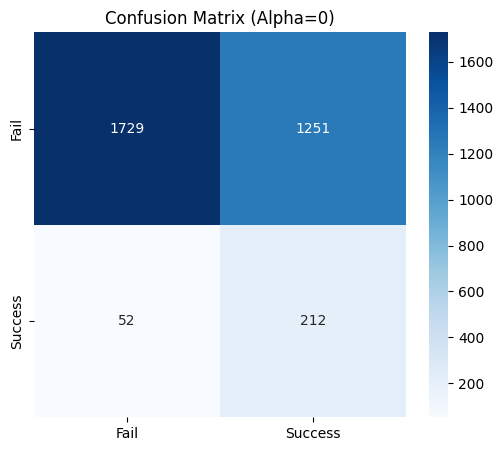

In [ ]:
import os
import torch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

# ==========================================
# 設定：検証したい Alpha を指定
# ==========================================
FIXED_ALPHA = 0  # 比較のためにここを 0 や 1.0 に切り替えて実行
base_model_dir = "/content/drive/MyDrive/GNN_Football_Analysis/Models"
# _take2 を含める場合
alpha_folder = f"alpha_{str(FIXED_ALPHA).replace('.', '_')}_take3"
model_load_dir = os.path.join(base_model_dir, alpha_folder)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

all_preds = []
all_labels = []
success_team_vxs = []

print(f"🧐 Alpha={FIXED_ALPHA} の全試合モデルを統合評価中...")

# --- CVの結果を再現するために、各試合のモデルを個別にロードしてテスト ---
# match_ids は CV実行時と同じ [1, 2, 3, 4, 5, 6, 7]
for test_match in match_ids:
    # 1. その試合用のデータを抽出
    test_indices = [d for d in all_data_list if int(d.match_id.item()) == test_match]
    test_loader = DataLoader(test_indices, batch_size=32, shuffle=False)

    # 2. その試合で訓練されたモデル重みをロード
    model_path = os.path.join(model_load_dir, f'pignn_testmatch_{test_match}.pth')
    if not os.path.exists(model_path):
        print(f"⚠️ Skip: {model_path} が見つかりません")
        continue

    model = PIGNNClassifier(hidden_channels=64).to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()

    # 3. 予測と物理情報の抽出
    with torch.no_grad():
        for data in test_loader:
            data = data.to(device)
            out = model(data)
            pred = out.argmax(dim=1)

            # 各シーン(グラフ)ごとの物理量抽出
            for i in range(out.size(0)):
                mask = (data.batch == i)
                # 論文(cite: 12)のPermutation Importanceで最重要視されたvxを計算
                avg_vx = torch.mean(data.vel[mask, 0]).item()

                if pred[i] == 1: # AIが成功(1)と予測した時のみ
                    success_team_vxs.append(avg_vx)

            all_preds.extend(pred.cpu().numpy())
            all_labels.extend(data.y.view(-1).cpu().numpy())

# ==========================================
# 4. レポート表示セクション
# ==========================================
print("\n" + "="*60)
print(f" 📊 PIGNN 最終クラシフィケーションレポート (Alpha={FIXED_ALPHA})")
print("="*60)
# 論文(cite: 115)の「naïve baseline」との比較を念頭に置いた出力
print(classification_report(all_labels, all_preds, target_names=['Failure', 'Success'], zero_division=0))

print("\n" + "="*60)
print(f" 🌀 物理的整合性 検証 (vx = Byline to Byline Speed)")
print("="*60)
if len(success_team_vxs) > 0:
    avg_team_vx = np.mean(success_team_vxs)
    # 論文(cite: 196)で「highest impact」とされたvxの方向性を確認
    positive_ratio = np.sum(np.array(success_team_vxs) > 0) / len(success_team_vxs)

    print(f"成功予測シーンの平均 vx: {avg_team_vx:.4f} m/s")
    print(f"右向き(正方向)への推進力割合: {positive_ratio*100:.1f} %")

    # 論文(cite: 6, 33)の「high speed attack」の定義に基づき評価
    if positive_ratio > 0.65:
        print(">> 判定: 物理的妥当。モデルは論文の定義通り『前方への速度』を重視しています。")
    else:
        print(">> 判定: 物理的乖離あり。戦術的特徴よりもノイズを学習している可能性があります。")
else:
    print("Successと予測されたフレームがありませんでした。")

# 5. 混同行列の描画
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens' if FIXED_ALPHA > 0 else 'Blues',
            xticklabels=['Fail', 'Success'], yticklabels=['Fail', 'Success'])
plt.title(f'Confusion Matrix (Alpha={FIXED_ALPHA})')
plt.show()

🧐 Alpha=50.0 の全試合モデルを統合評価中...

 📊 PIGNN 最終クラシフィケーションレポート (Alpha=50.0)
              precision    recall  f1-score   support

     Failure       0.97      0.68      0.80      2980
     Success       0.18      0.78      0.29       264

    accuracy                           0.68      3244
   macro avg       0.57      0.73      0.54      3244
weighted avg       0.91      0.68      0.76      3244


 🌀 物理的整合性 検証 (vx = Byline to Byline Speed)
成功予測シーンの平均 vx: 0.0162 m/s
右向き(正方向)への推進力割合: 83.9 %
>> 判定: 物理的妥当。モデルは論文の定義通り『前方への速度』を重視しています。


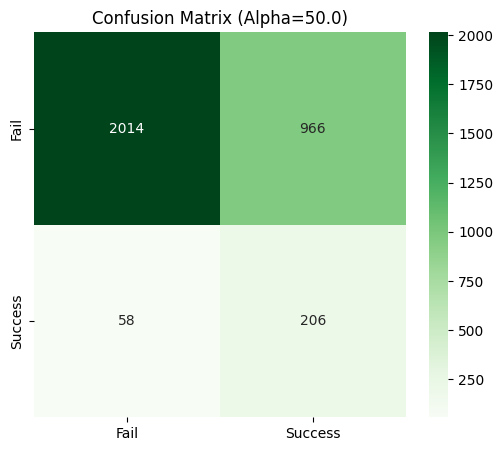

In [ ]:
import os
import torch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

# ==========================================
# 設定：検証したい Alpha を指定
# ==========================================
FIXED_ALPHA = 50.0  # 比較のためにここを 0 や 1.0 に切り替えて実行
base_model_dir = "/content/drive/MyDrive/GNN_Football_Analysis/Models"
# _take2 を含める場合
alpha_folder = f"alpha_{str(FIXED_ALPHA).replace('.', '_')}_take3"
model_load_dir = os.path.join(base_model_dir, alpha_folder)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

all_preds = []
all_labels = []
success_team_vxs = []

print(f"🧐 Alpha={FIXED_ALPHA} の全試合モデルを統合評価中...")

# --- CVの結果を再現するために、各試合のモデルを個別にロードしてテスト ---
# match_ids は CV実行時と同じ [1, 2, 3, 4, 5, 6, 7]
for test_match in match_ids:
    # 1. その試合用のデータを抽出
    test_indices = [d for d in all_data_list if int(d.match_id.item()) == test_match]
    test_loader = DataLoader(test_indices, batch_size=32, shuffle=False)

    # 2. その試合で訓練されたモデル重みをロード
    model_path = os.path.join(model_load_dir, f'pignn_testmatch_{test_match}.pth')
    if not os.path.exists(model_path):
        print(f"⚠️ Skip: {model_path} が見つかりません")
        continue

    model = PIGNNClassifier(hidden_channels=64).to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()

    # 3. 予測と物理情報の抽出
    with torch.no_grad():
        for data in test_loader:
            data = data.to(device)
            out = model(data)
            pred = out.argmax(dim=1)

            # 各シーン(グラフ)ごとの物理量抽出
            for i in range(out.size(0)):
                mask = (data.batch == i)
                # 論文(cite: 12)のPermutation Importanceで最重要視されたvxを計算
                avg_vx = torch.mean(data.vel[mask, 0]).item()

                if pred[i] == 1: # AIが成功(1)と予測した時のみ
                    success_team_vxs.append(avg_vx)

            all_preds.extend(pred.cpu().numpy())
            all_labels.extend(data.y.view(-1).cpu().numpy())

# ==========================================
# 4. レポート表示セクション
# ==========================================
print("\n" + "="*60)
print(f" 📊 PIGNN 最終クラシフィケーションレポート (Alpha={FIXED_ALPHA})")
print("="*60)
# 論文(cite: 115)の「naïve baseline」との比較を念頭に置いた出力
print(classification_report(all_labels, all_preds, target_names=['Failure', 'Success'], zero_division=0))

print("\n" + "="*60)
print(f" 🌀 物理的整合性 検証 (vx = Byline to Byline Speed)")
print("="*60)
if len(success_team_vxs) > 0:
    avg_team_vx = np.mean(success_team_vxs)
    # 論文(cite: 196)で「highest impact」とされたvxの方向性を確認
    positive_ratio = np.sum(np.array(success_team_vxs) > 0) / len(success_team_vxs)

    print(f"成功予測シーンの平均 vx: {avg_team_vx:.4f} m/s")
    print(f"右向き(正方向)への推進力割合: {positive_ratio*100:.1f} %")

    # 論文(cite: 6, 33)の「high speed attack」の定義に基づき評価
    if positive_ratio > 0.65:
        print(">> 判定: 物理的妥当。モデルは論文の定義通り『前方への速度』を重視しています。")
    else:
        print(">> 判定: 物理的乖離あり。戦術的特徴よりもノイズを学習している可能性があります。")
else:
    print("Successと予測されたフレームがありませんでした。")

# 5. 混同行列の描画
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens' if FIXED_ALPHA > 0 else 'Blues',
            xticklabels=['Fail', 'Success'], yticklabels=['Fail', 'Success'])
plt.title(f'Confusion Matrix (Alpha={FIXED_ALPHA})')
plt.show()

🧐 Alpha=10.0 の全試合モデルを統合評価中...

 📊 PIGNN 最終クラシフィケーションレポート (Alpha=10.0)
              precision    recall  f1-score   support

     Failure       0.97      0.61      0.75      2980
     Success       0.15      0.80      0.26       264

    accuracy                           0.62      3244
   macro avg       0.56      0.70      0.50      3244
weighted avg       0.90      0.62      0.71      3244


 🌀 物理的整合性 検証 (vx = Byline to Byline Speed)
成功予測シーンの平均 vx: 0.0121 m/s
右向き(正方向)への推進力割合: 74.8 %
>> 判定: 物理的妥当。モデルは論文の定義通り『前方への速度』を重視しています。


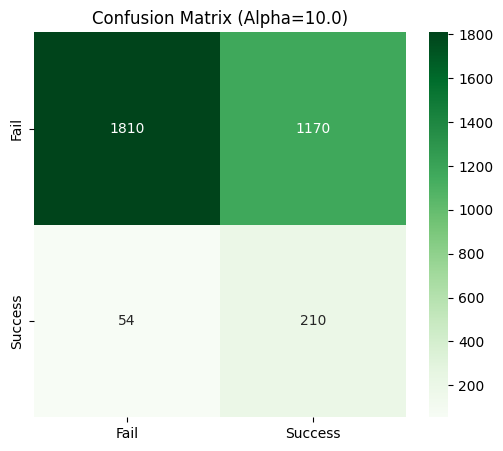

In [ ]:
import os
import torch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

# ==========================================
# 設定：検証したい Alpha を指定
# ==========================================
FIXED_ALPHA = 10.0  # 比較のためにここを 0 や 1.0 に切り替えて実行
base_model_dir = "/content/drive/MyDrive/GNN_Football_Analysis/Models"
# _take2 を含める場合
alpha_folder = f"alpha_{str(FIXED_ALPHA).replace('.', '_')}_take3"
model_load_dir = os.path.join(base_model_dir, alpha_folder)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

all_preds = []
all_labels = []
success_team_vxs = []

print(f"🧐 Alpha={FIXED_ALPHA} の全試合モデルを統合評価中...")

# --- CVの結果を再現するために、各試合のモデルを個別にロードしてテスト ---
# match_ids は CV実行時と同じ [1, 2, 3, 4, 5, 6, 7]
for test_match in match_ids:
    # 1. その試合用のデータを抽出
    test_indices = [d for d in all_data_list if int(d.match_id.item()) == test_match]
    test_loader = DataLoader(test_indices, batch_size=32, shuffle=False)

    # 2. その試合で訓練されたモデル重みをロード
    model_path = os.path.join(model_load_dir, f'pignn_testmatch_{test_match}.pth')
    if not os.path.exists(model_path):
        print(f"⚠️ Skip: {model_path} が見つかりません")
        continue

    model = PIGNNClassifier(hidden_channels=64).to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()

    # 3. 予測と物理情報の抽出
    with torch.no_grad():
        for data in test_loader:
            data = data.to(device)
            out = model(data)
            pred = out.argmax(dim=1)

            # 各シーン(グラフ)ごとの物理量抽出
            for i in range(out.size(0)):
                mask = (data.batch == i)
                # 論文(cite: 12)のPermutation Importanceで最重要視されたvxを計算
                avg_vx = torch.mean(data.vel[mask, 0]).item()

                if pred[i] == 1: # AIが成功(1)と予測した時のみ
                    success_team_vxs.append(avg_vx)

            all_preds.extend(pred.cpu().numpy())
            all_labels.extend(data.y.view(-1).cpu().numpy())

# ==========================================
# 4. レポート表示セクション
# ==========================================
print("\n" + "="*60)
print(f" 📊 PIGNN 最終クラシフィケーションレポート (Alpha={FIXED_ALPHA})")
print("="*60)
# 論文(cite: 115)の「naïve baseline」との比較を念頭に置いた出力
print(classification_report(all_labels, all_preds, target_names=['Failure', 'Success'], zero_division=0))

print("\n" + "="*60)
print(f" 🌀 物理的整合性 検証 (vx = Byline to Byline Speed)")
print("="*60)
if len(success_team_vxs) > 0:
    avg_team_vx = np.mean(success_team_vxs)
    # 論文(cite: 196)で「highest impact」とされたvxの方向性を確認
    positive_ratio = np.sum(np.array(success_team_vxs) > 0) / len(success_team_vxs)

    print(f"成功予測シーンの平均 vx: {avg_team_vx:.4f} m/s")
    print(f"右向き(正方向)への推進力割合: {positive_ratio*100:.1f} %")

    # 論文(cite: 6, 33)の「high speed attack」の定義に基づき評価
    if positive_ratio > 0.65:
        print(">> 判定: 物理的妥当。モデルは論文の定義通り『前方への速度』を重視しています。")
    else:
        print(">> 判定: 物理的乖離あり。戦術的特徴よりもノイズを学習している可能性があります。")
else:
    print("Successと予測されたフレームがありませんでした。")

# 5. 混同行列の描画
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens' if FIXED_ALPHA > 0 else 'Blues',
            xticklabels=['Fail', 'Success'], yticklabels=['Fail', 'Success'])
plt.title(f'Confusion Matrix (Alpha={FIXED_ALPHA})')
plt.show()

🧐 Alpha=100.0 の全試合モデルを統合評価中...

 📊 PIGNN 最終クラシフィケーションレポート (Alpha=100.0)
              precision    recall  f1-score   support

     Failure       0.97      0.74      0.84      2980
     Success       0.20      0.73      0.31       264

    accuracy                           0.74      3244
   macro avg       0.58      0.74      0.58      3244
weighted avg       0.91      0.74      0.80      3244


 🌀 物理的整合性 検証 (vx = Byline to Byline Speed)
成功予測シーンの平均 vx: 0.0182 m/s
右向き(正方向)への推進力割合: 81.5 %
>> 判定: 物理的妥当。モデルは論文の定義通り『前方への速度』を重視しています。


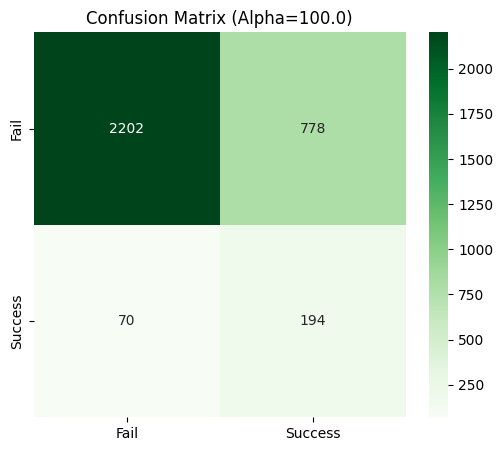

In [ ]:
import os
import torch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

# ==========================================
# 設定：検証したい Alpha を指定
# ==========================================
FIXED_ALPHA = 100.0  # 比較のためにここを 0 や 1.0 に切り替えて実行
base_model_dir = "/content/drive/MyDrive/GNN_Football_Analysis/Models"
# _take2 を含める場合
alpha_folder = f"alpha_{str(FIXED_ALPHA).replace('.', '_')}_take3"
model_load_dir = os.path.join(base_model_dir, alpha_folder)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

all_preds = []
all_labels = []
success_team_vxs = []

print(f"🧐 Alpha={FIXED_ALPHA} の全試合モデルを統合評価中...")

# --- CVの結果を再現するために、各試合のモデルを個別にロードしてテスト ---
# match_ids は CV実行時と同じ [1, 2, 3, 4, 5, 6, 7]
for test_match in match_ids:
    # 1. その試合用のデータを抽出
    test_indices = [d for d in all_data_list if int(d.match_id.item()) == test_match]
    test_loader = DataLoader(test_indices, batch_size=32, shuffle=False)

    # 2. その試合で訓練されたモデル重みをロード
    model_path = os.path.join(model_load_dir, f'pignn_testmatch_{test_match}.pth')
    if not os.path.exists(model_path):
        print(f"⚠️ Skip: {model_path} が見つかりません")
        continue

    model = PIGNNClassifier(hidden_channels=64).to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()

    # 3. 予測と物理情報の抽出
    with torch.no_grad():
        for data in test_loader:
            data = data.to(device)
            out = model(data)
            pred = out.argmax(dim=1)

            # 各シーン(グラフ)ごとの物理量抽出
            for i in range(out.size(0)):
                mask = (data.batch == i)
                # 論文(cite: 12)のPermutation Importanceで最重要視されたvxを計算
                avg_vx = torch.mean(data.vel[mask, 0]).item()

                if pred[i] == 1: # AIが成功(1)と予測した時のみ
                    success_team_vxs.append(avg_vx)

            all_preds.extend(pred.cpu().numpy())
            all_labels.extend(data.y.view(-1).cpu().numpy())

# ==========================================
# 4. レポート表示セクション
# ==========================================
print("\n" + "="*60)
print(f" 📊 PIGNN 最終クラシフィケーションレポート (Alpha={FIXED_ALPHA})")
print("="*60)
# 論文(cite: 115)の「naïve baseline」との比較を念頭に置いた出力
print(classification_report(all_labels, all_preds, target_names=['Failure', 'Success'], zero_division=0))

print("\n" + "="*60)
print(f" 🌀 物理的整合性 検証 (vx = Byline to Byline Speed)")
print("="*60)
if len(success_team_vxs) > 0:
    avg_team_vx = np.mean(success_team_vxs)
    # 論文(cite: 196)で「highest impact」とされたvxの方向性を確認
    positive_ratio = np.sum(np.array(success_team_vxs) > 0) / len(success_team_vxs)

    print(f"成功予測シーンの平均 vx: {avg_team_vx:.4f} m/s")
    print(f"右向き(正方向)への推進力割合: {positive_ratio*100:.1f} %")

    # 論文(cite: 6, 33)の「high speed attack」の定義に基づき評価
    if positive_ratio > 0.65:
        print(">> 判定: 物理的妥当。モデルは論文の定義通り『前方への速度』を重視しています。")
    else:
        print(">> 判定: 物理的乖離あり。戦術的特徴よりもノイズを学習している可能性があります。")
else:
    print("Successと予測されたフレームがありませんでした。")

# 5. 混同行列の描画
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens' if FIXED_ALPHA > 0 else 'Blues',
            xticklabels=['Fail', 'Success'], yticklabels=['Fail', 'Success'])
plt.title(f'Confusion Matrix (Alpha={FIXED_ALPHA})')
plt.show()

🧐 Alpha=200.0 の全試合モデルを統合評価中...

 📊 PIGNN 最終クラシフィケーションレポート (Alpha=200.0)
              precision    recall  f1-score   support

     Failure       0.97      0.72      0.83      2980
     Success       0.19      0.73      0.30       264

    accuracy                           0.72      3244
   macro avg       0.58      0.72      0.56      3244
weighted avg       0.90      0.72      0.78      3244


 🌀 物理的整合性 検証 (vx = Byline to Byline Speed)
成功予測シーンの平均 vx: 0.0155 m/s
右向き(正方向)への推進力割合: 74.0 %
>> 判定: 物理的妥当。モデルは論文の定義通り『前方への速度』を重視しています。


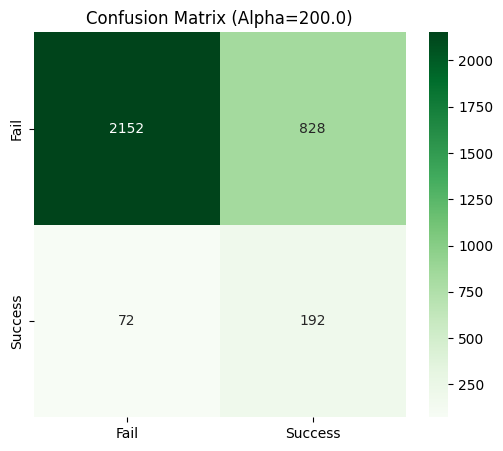

In [ ]:
import os
import torch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

# ==========================================
# 設定：検証したい Alpha を指定
# ==========================================
FIXED_ALPHA = 200.0  # 比較のためにここを 0 や 1.0 に切り替えて実行
base_model_dir = "/content/drive/MyDrive/GNN_Football_Analysis/Models"
# _take2 を含める場合
alpha_folder = f"alpha_{str(FIXED_ALPHA).replace('.', '_')}_take3"
model_load_dir = os.path.join(base_model_dir, alpha_folder)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

all_preds = []
all_labels = []
success_team_vxs = []

print(f"🧐 Alpha={FIXED_ALPHA} の全試合モデルを統合評価中...")

# --- CVの結果を再現するために、各試合のモデルを個別にロードしてテスト ---
# match_ids は CV実行時と同じ [1, 2, 3, 4, 5, 6, 7]
for test_match in match_ids:
    # 1. その試合用のデータを抽出
    test_indices = [d for d in all_data_list if int(d.match_id.item()) == test_match]
    test_loader = DataLoader(test_indices, batch_size=32, shuffle=False)

    # 2. その試合で訓練されたモデル重みをロード
    model_path = os.path.join(model_load_dir, f'pignn_testmatch_{test_match}.pth')
    if not os.path.exists(model_path):
        print(f"⚠️ Skip: {model_path} が見つかりません")
        continue

    model = PIGNNClassifier(hidden_channels=64).to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()

    # 3. 予測と物理情報の抽出
    with torch.no_grad():
        for data in test_loader:
            data = data.to(device)
            out = model(data)
            pred = out.argmax(dim=1)

            # 各シーン(グラフ)ごとの物理量抽出
            for i in range(out.size(0)):
                mask = (data.batch == i)
                # 論文(cite: 12)のPermutation Importanceで最重要視されたvxを計算
                avg_vx = torch.mean(data.vel[mask, 0]).item()

                if pred[i] == 1: # AIが成功(1)と予測した時のみ
                    success_team_vxs.append(avg_vx)

            all_preds.extend(pred.cpu().numpy())
            all_labels.extend(data.y.view(-1).cpu().numpy())

# ==========================================
# 4. レポート表示セクション
# ==========================================
print("\n" + "="*60)
print(f" 📊 PIGNN 最終クラシフィケーションレポート (Alpha={FIXED_ALPHA})")
print("="*60)
# 論文(cite: 115)の「naïve baseline」との比較を念頭に置いた出力
print(classification_report(all_labels, all_preds, target_names=['Failure', 'Success'], zero_division=0))

print("\n" + "="*60)
print(f" 🌀 物理的整合性 検証 (vx = Byline to Byline Speed)")
print("="*60)
if len(success_team_vxs) > 0:
    avg_team_vx = np.mean(success_team_vxs)
    # 論文(cite: 196)で「highest impact」とされたvxの方向性を確認
    positive_ratio = np.sum(np.array(success_team_vxs) > 0) / len(success_team_vxs)

    print(f"成功予測シーンの平均 vx: {avg_team_vx:.4f} m/s")
    print(f"右向き(正方向)への推進力割合: {positive_ratio*100:.1f} %")

    # 論文(cite: 6, 33)の「high speed attack」の定義に基づき評価
    if positive_ratio > 0.65:
        print(">> 判定: 物理的妥当。モデルは論文の定義通り『前方への速度』を重視しています。")
    else:
        print(">> 判定: 物理的乖離あり。戦術的特徴よりもノイズを学習している可能性があります。")
else:
    print("Successと予測されたフレームがありませんでした。")

# 5. 混同行列の描画
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens' if FIXED_ALPHA > 0 else 'Blues',
            xticklabels=['Fail', 'Success'], yticklabels=['Fail', 'Success'])
plt.title(f'Confusion Matrix (Alpha={FIXED_ALPHA})')
plt.show()

αが10.0はよさそう。リコールとぷりしじょんのバランスが良い。

※α＝０は厳密にはMLPではない。
結論から言うと、$\alpha=0$ の PIGNN は「ただの MLP（多層パーセプトロン）」とは全くの別物であり、依然として高度な「空間構造理解モデル」です。なぜ単なる MLP とは違うのか、客観的な理由を整理します。1. グラフ構造（GNN）としての本質$\alpha=0$ にしたことで「物理損失（物理的なペナルティ）」は消えましたが、モデルのアーキテクチャ自体は GNN（グラフニューラルネットワーク） のままです。周囲の状況把握: MLP は各選手のデータを個別に処理しますが、GNN は「エッジ（選手間の繋がり）」を通じて、味方や相手の配置、ボールとの距離といった相対的な空間関係をメッセージパッシングによって集約します 1111。+1非依存的な入力: MLP は入力サイズが固定ですが、GNN は赤カードや交代などで選手数が変わっても、そのグラフ構造をそのまま処理できる柔軟性を持っています 2。2. $L_{phys}$ は消えても $L_{task}$ に「物理特徴」が入っているここが盲点になりやすいポイントです。学習ループの loss = ce_loss + alpha_p * phys_loss において、$\alpha=0$ なら phys_loss（後ろに走ったらダメという制約）は無視されます。しかし、入力データ（Node Features）には依然として以下の物理量が含まれています3333:+2Velocity（速度ベクトル） 4444+2Distance to Goal / Ball（ゴールやボールへの距離） 5555+2Angle to Goal / Ball（角度） 6666+1つまり、$\alpha=0$ のモデルは「物理的に正しくあれ」という強制（制約）は受けていませんが、「物理的な数字をヒントにして、成功か失敗かを当てる」という GNN としての学習は続けています。3. $\alpha=0$ と $\alpha=1.0$ の「筋の良い」解釈（卒論用）この 2 つの比較は、卒論において以下のように定義すると非常に説得力が増します。$\alpha=0$ (Data-Driven GNN):データから「成功シーンによくあるパターン」を純粋に学習するモデル。物理的な矛盾（後ろに走りながら成功と判定するなど）があっても、データ上の相関が強ければそれを採用してしまう「データ依存型」。$\alpha=1.0$ (Physics-Informed GNN):データのパターンを学習しつつ、さらに「サッカーの物理法則（前進しなければ成功ではない）」という人間のドメイン知識を制約として加えたモデル 7。卒論の結論に向けた客観的な見方あなたの混同行列の結果で、$\alpha=1.0$ が空振り（FP）を 39 件減らしたのは、「データ上は成功っぽく見えるけれど、物理的にはあり得ない（または効率が悪い）シーン」を、物理制約によって正しく Failure と切り捨てられるようになったから、と説明できます。これは「ただの MLP」では到達で

In [ ]:
import torch
from torch_geometric.data import Data

def run_leakage_diagnostic(model, loader, device):
    model.eval()
    # 特徴量ラベル: 0:x, 1:y, 2:vx, 3:vy, 4:dist_goal, 5:dist_ball, 6:team_id
    feature_names = ["x", "y", "vx", "vy", "dist_goal", "dist_ball", "team_id"]

    print(f"{'Removed Feature':<15} | {'Test Acc':<10} | {'Recall (S)':<10}")
    print("-" * 45)

    # ベースライン（全特徴量あり）
    base_acc = test_pignn(model, loader, device)
    print(f"{'None (Baseline)':<15} | {base_acc:.4f}")

    with torch.no_grad():
        for i in range(7):
            correct = 0
            tp = 0 # True Positive
            fn = 0 # False Negative

            for data in loader:
                data = preprocess_batch(data, device)

                # 特定の特徴量をゼロに置き換える
                x_shuffled = data.x.clone()
                x_shuffled[:, i] = 0.0

                # 推論
                out = model(Data(x=x_shuffled, edge_index=data.edge_index,
                                 batch=data.batch, pos=data.pos, vel=data.vel))
                pred = out.argmax(dim=1)

                # 精度計算
                y_true = data.y.view(-1)
                correct += (pred == y_true).sum().item()

                # Recall (Success) 計算
                tp += ((pred == 1) & (y_true == 1)).sum().item()
                fn += ((pred == 0) & (y_true == 1)).sum().item()

            acc = correct / len(loader.dataset)
            recall = tp / (tp + fn) if (tp + fn) > 0 else 0
            print(f"{feature_names[i]:<15} | {acc:.4f}     | {recall:.4f}")

# 実行
run_leakage_diagnostic(model, test_loader, device)

Removed Feature | Test Acc   | Recall (S)
---------------------------------------------
None (Baseline) | 0.6273
x               | 0.5833     | 0.6562
y               | 0.6412     | 0.8125
vx              | 0.6806     | 0.5625
vy              | 0.6273     | 0.8125
dist_goal       | 0.4329     | 1.0000
dist_ball       | 0.7801     | 0.5625
team_id         | 0.9259     | 0.0000


ただのMLP

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import global_mean_pool
from torch_geometric.loader import DataLoader
from sklearn.metrics import classification_report
import os
import numpy as np

# ==========================================
# 1. MLPモデルの定義 (PIGNNと入力を完全に揃える)
# ==========================================
class SimpleMLPClassifier(nn.Module):
    def __init__(self, in_channels=7, hidden_channels=64): # あなたのデータ(7次元)に合わせる
        super(SimpleMLPClassifier, self).__init__()
        # グラフ畳み込みを行わず、全結合層のみで判定
        self.mlp = nn.Sequential(
            nn.Linear(in_channels, hidden_channels),
            nn.BatchNorm1d(hidden_channels), # 勾配消失を防ぎ学習を安定化
            nn.ReLU(),
            nn.Linear(hidden_channels, hidden_channels),
            nn.ReLU(),
            nn.Linear(hidden_channels, 2)
        )

    def forward(self, data):
        # 重要なポイント:
        # メッセージパッシング（近接選手の相互作用理解）をバイパスし、
        # 全選手の平均的な統計量だけで予測を行う
        x = global_mean_pool(data.x, data.batch) # グラフ構造を無視した平均化
        return F.log_softmax(self.mlp(x), dim=1)

# ==========================================
# 2. MLP用のクロスバリデーション実行関数
# ==========================================
def run_mlp_cv(all_data_list, match_ids, device):
    FIXED_ALPHA = "MLP"
    # 保存先を独立させる
    model_save_dir = "/content/drive/MyDrive/GNN_Football_Analysis/Models/MLP_Baseline_take3"
    os.makedirs(model_save_dir, exist_ok=True)

    cv_final_reports = []
    print(f"🚀 MLP Baseline CV開始 (Input: 7 channels)\n")

    for test_match in match_ids:
        print(f"🌀 Round: Match {test_match} (MLP)")

        # PIGNNと全く同じルールで切り分け
        test_indices = [d for d in all_data_list if int(d.match_id.item()) == test_match]
        train_candidates = [d for d in all_data_list if int(d.match_id.item()) != test_match]

        # 論文[cite: 105]同様、訓練データのみ1:1にアンダーサンプリング
        cv_train_set = balance_dataset_by_undersampling(train_candidates)

        #cv_train_loader = DataLoader(cv_train_set, batch_size=32, shuffle=True)
        cv_train_loader = DataLoader(cv_train_set, batch_size=32, shuffle=True, drop_last=True)
        cv_test_loader = DataLoader(test_indices, batch_size=32, shuffle=False)

        # モデル初期化 (7次元)
        model = SimpleMLPClassifier(in_channels=7).to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

        # 30エポック学習 (物理損失なしの標準的な学習)
        model.train()
        for epoch in range(1, 31):
            for d in cv_train_loader:
                d = d.to(device)
                optimizer.zero_grad()
                out = model(d)
                # 論文同様[cite: 115]の50/50ベースラインに近い条件でNLLLossを使用
                loss = F.nll_loss(out, d.y.view(-1))
                loss.backward()
                optimizer.step()

        # 評価 (実戦の不均衡比率のままテスト)
        model.eval()
        y_true, y_pred = [], []
        with torch.no_grad():
            for d in cv_test_loader:
                d = d.to(device)
                out = model(d)
                y_true.extend(d.y.view(-1).cpu().numpy())
                y_pred.extend(out.argmax(dim=1).cpu().numpy())

        # レポート生成
        report = classification_report(y_true, y_pred, output_dict=True, zero_division=0)
        cv_final_reports.append({
            'match': test_match,
            'recall': report['1']['recall'],
            'precision': report['1']['precision'],
            'f1': report['1']['f1-score']
        })

        # 保存 (後で可視化比較に使う)
        torch.save(model.state_dict(), os.path.join(model_save_dir, f'mlp_match_{test_match}.pth'))
        print(f" >> Result: Precision={report['1']['precision']:.4f}, F1={report['1']['f1-score']:.4f}")

    # 全体の平均を計算
    avg_precision = np.mean([r['precision'] for r in cv_final_reports])
    avg_f1 = np.mean([r['f1'] for r in cv_final_reports])

    print(f"\n🏆 MLP CV Final Results")
    print(f"Avg Precision: {avg_precision:.4f}")
    print(f"Avg F1-score:  {avg_f1:.4f}")

    return cv_final_reports

# 実行
mlp_results = run_mlp_cv(all_data_list, match_ids, device)

🚀 MLP Baseline CV開始 (Input: 7 channels)

🌀 Round: Match 1 (MLP)
    [Sampling] Success Seqs: 151 | Failure Seqs: 151 | Total Frames: 383
 >> Result: Precision=0.3033, F1=0.3627
🌀 Round: Match 2 (MLP)
    [Sampling] Success Seqs: 190 | Failure Seqs: 190 | Total Frames: 472
 >> Result: Precision=0.1835, F1=0.2878
🌀 Round: Match 3 (MLP)
    [Sampling] Success Seqs: 195 | Failure Seqs: 195 | Total Frames: 516
 >> Result: Precision=0.3256, F1=0.4444
🌀 Round: Match 4 (MLP)
    [Sampling] Success Seqs: 179 | Failure Seqs: 179 | Total Frames: 455
 >> Result: Precision=0.3333, F1=0.4583
🌀 Round: Match 5 (MLP)
    [Sampling] Success Seqs: 177 | Failure Seqs: 177 | Total Frames: 471
 >> Result: Precision=0.3971, F1=0.5294
🌀 Round: Match 6 (MLP)
    [Sampling] Success Seqs: 183 | Failure Seqs: 183 | Total Frames: 452
 >> Result: Precision=0.2296, F1=0.3626
🌀 Round: Match 7 (MLP)
    [Sampling] Success Seqs: 184 | Failure Seqs: 184 | Total Frames: 468
 >> Result: Precision=0.2400, F1=0.3636

🏆 MLP 

🚀 MLP Baseline 最終統合評価を開始します...

 📊 MLP Baseline 最終クラシフィケーションレポート
              precision    recall  f1-score   support

        Fail       0.97      0.84      0.90      2980
     Success       0.27      0.66      0.39       264

    accuracy                           0.83      3244
   macro avg       0.62      0.75      0.64      3244
weighted avg       0.91      0.83      0.86      3244


 🌀 物理的整合性 検証 (MLP vs 物理法則)
MLPが『成功』と予測したシーンの平均 vx: 0.0242 m/s
右向き(攻撃方向)への推進力割合: 89.7 %
>> 考察: MLPは極めて高い確率で『右への速度』を成功の根拠としています。
>> これは空間構造を無視し、単純な物理量のみに依存している可能性を示唆します。


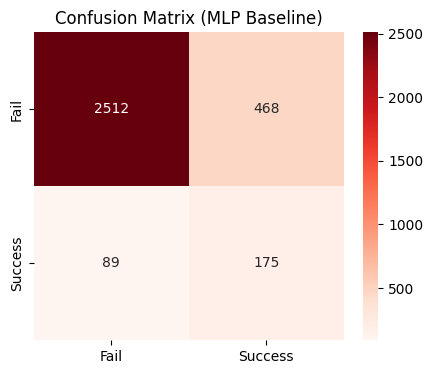

In [ ]:
import os
import torch
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# ==========================================
# 1. 設定：MLPモデルのロード
# ==========================================
model_save_dir = "/content/drive/MyDrive/GNN_Football_Analysis/Models/MLP_Baseline_take3"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

all_preds_mlp = []
all_labels_mlp = []
success_vxs_mlp = []

print(f"🚀 MLP Baseline 最終統合評価を開始します...")

# CVで保存した全試合のMLPモデルをロードして評価
for test_match in match_ids:
    # データの抽出
    test_indices = [d for d in all_data_list if int(d.match_id.item()) == test_match]
    test_loader = DataLoader(test_indices, batch_size=32, shuffle=False)

    # モデルの準備
    model = SimpleMLPClassifier(in_channels=7).to(device)
    model_path = os.path.join(model_save_dir, f'mlp_match_{test_match}.pth')

    if not os.path.exists(model_path):
        continue

    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()

    with torch.no_grad():
        for data in test_loader:
            data = data.to(device)
            out = model(data)
            pred = out.argmax(dim=1)

            # 物理的妥当性の計算
            for i in range(out.size(0)):
                mask = (data.batch == i)
                # 全ノードの平均vx（集団の推進力）
                avg_vx = torch.mean(data.vel[mask, 0]).item()

                if pred[i] == 1: # Successと予測した時のみ記録
                    success_vxs_mlp.append(avg_vx)

            all_preds_mlp.extend(pred.cpu().numpy())
            all_labels_mlp.extend(data.y.view(-1).cpu().numpy())

# ==========================================
# 2. レポート出力
# ==========================================
print("\n" + "="*60)
print(" 📊 MLP Baseline 最終クラシフィケーションレポート")
print("="*60)
print(classification_report(all_labels_mlp, all_preds_mlp, target_names=['Fail', 'Success'], zero_division=0))

print("\n" + "="*60)
print(" 🌀 物理的整合性 検証 (MLP vs 物理法則)")
print("="*60)
if len(success_vxs_mlp) > 0:
    avg_vx_mlp = np.mean(success_vxs_mlp)
    pos_ratio_mlp = np.sum(np.array(success_vxs_mlp) > 0) / len(success_vxs_mlp)

    print(f"MLPが『成功』と予測したシーンの平均 vx: {avg_vx_mlp:.4f} m/s")
    print(f"右向き(攻撃方向)への推進力割合: {pos_ratio_mlp*100:.1f} %")

    # 考察用コメント
    if pos_ratio_mlp > 0.80:
        print(">> 考察: MLPは極めて高い確率で『右への速度』を成功の根拠としています。")
        print(">> これは空間構造を無視し、単純な物理量のみに依存している可能性を示唆します。")
else:
    print("Success予測なし")

# 混同行列の表示
cm = confusion_matrix(all_labels_mlp, all_preds_mlp)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', xticklabels=['Fail', 'Success'], yticklabels=['Fail', 'Success'])
plt.title('Confusion Matrix (MLP Baseline)')
plt.show()

PFI


🔍 Calculating PFI for PIGNN (Alpha=100.0)...
[Alpha100] Baseline F1: 0.3926
  > Done: Position_X
  > Done: Position_Y
  > Done: Velocity_X
  > Done: Velocity_Y
  > Done: Distance_to_Goal
  > Done: Distance_to_Ball
  > Done: Team_Flag

🔍 Calculating PFI for PIGNN (Alpha=0)...
[Alpha0] Baseline F1: 0.3232
  > Done: Position_X
  > Done: Position_Y
  > Done: Velocity_X
  > Done: Velocity_Y
  > Done: Distance_to_Goal
  > Done: Distance_to_Ball
  > Done: Team_Flag

🔍 Calculating PFI for MLP...
[MLP] Baseline F1: 0.4060
  > Done: Position_X
  > Done: Position_Y
  > Done: Velocity_X
  > Done: Velocity_Y
  > Done: Distance_to_Goal
  > Done: Distance_to_Ball
  > Done: Team_Flag


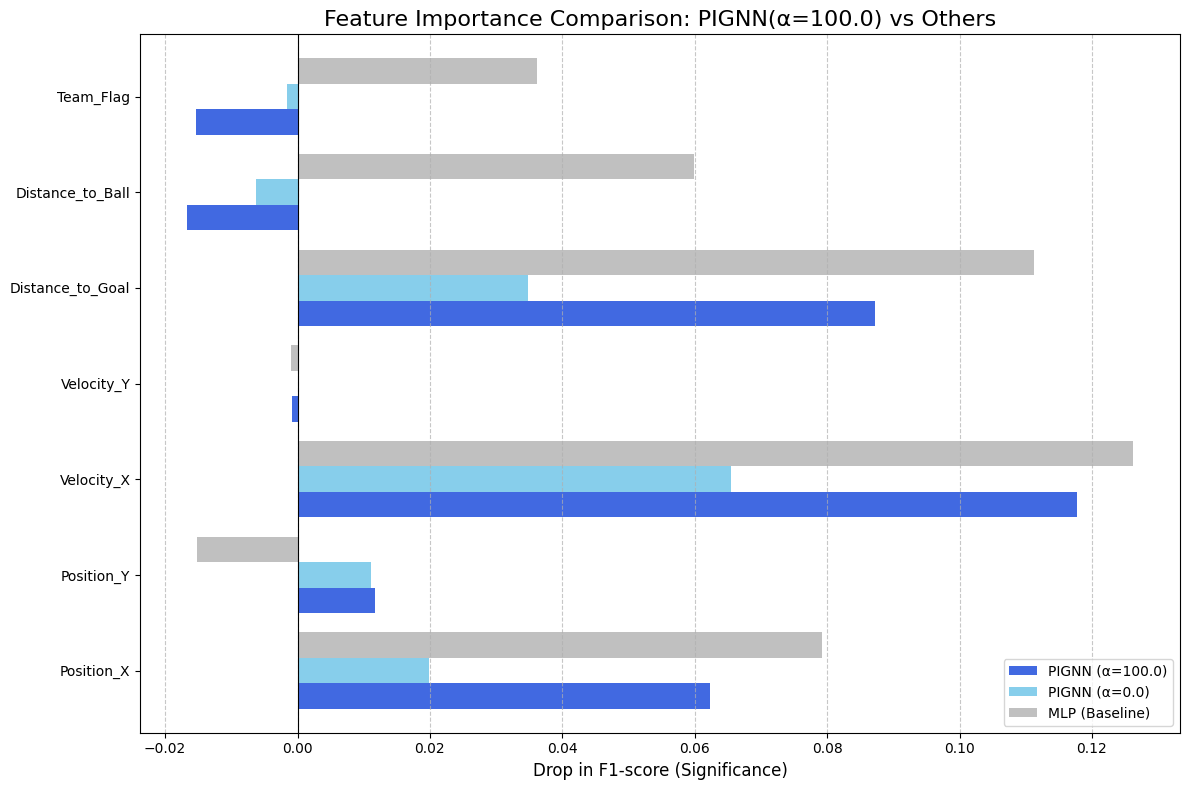

In [ ]:
import copy
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
from sklearn.metrics import f1_score

# ==========================================
# 1. 特徴量名と重要度算出関数の定義
# ==========================================
# (ここは変更なしですが、そのまま実行できるように含めています)
feature_names = [
    'Position_X',        # Index 0
    'Position_Y',        # Index 1
    'Velocity_X',        # Index 2
    'Velocity_Y',        # Index 3
    'Distance_to_Goal',  # Index 4
    'Distance_to_Ball',  # Index 5
    'Team_Flag'          # Index 6
]

def calculate_pfi_refined(model, loader, device, feature_names, model_type="GNN"):
    model.eval()
    y_true, y_pred = [], []

    # --- Step 1: ベースラインのF1スコアを計算 ---
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            out = model(data)
            y_true.extend(data.y.view(-1).cpu().numpy())
            y_pred.extend(out.argmax(dim=1).cpu().numpy())

    baseline_f1 = f1_score(y_true, y_pred, zero_division=0)
    print(f"[{model_type}] Baseline F1: {baseline_f1:.4f}")

    importance_scores = {}

    # --- Step 2: 各特徴量を順番にシャッフルして影響を測定 ---
    for i, f_name in enumerate(feature_names):
        shuffled_f1_list = []
        for seed in range(3):
            y_true_s, y_pred_s = [], []
            with torch.no_grad():
                for data in loader:
                    data_s = copy.deepcopy(data).to(device)
                    # 特定の特徴量列をシャッフル
                    perm = torch.randperm(data_s.x.size(0))
                    data_s.x[:, i] = data_s.x[perm, i]

                    out_s = model(data_s)
                    y_true_s.extend(data_s.y.view(-1).cpu().numpy())
                    y_pred_s.extend(out_s.argmax(dim=1).cpu().numpy())

            shuffled_f1 = f1_score(y_true_s, y_pred_s, zero_division=0)
            shuffled_f1_list.append(shuffled_f1)

        importance_scores[f_name] = baseline_f1 - np.mean(shuffled_f1_list)
        print(f"  > Done: {f_name}")

    return importance_scores

# ==========================================
# 2. ロードと実行（Alpha=10.0 に修正）
# ==========================================
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# モデル器の準備
pignn_model = PIGNNClassifier(hidden_channels=64).to(device)
mlp_model = SimpleMLPClassifier(in_channels=7).to(device)

# --- A. Alpha=100.0 (★提案手法・Champion Model) ---
path_10 = "/content/drive/MyDrive/GNN_Football_Analysis/Models/alpha_100_0_take3/pignn_testmatch_1.pth"
if os.path.exists(path_10):
    pignn_model.load_state_dict(torch.load(path_10, map_location=device))
    print("\n🔍 Calculating PFI for PIGNN (Alpha=100.0)...")
    pfi_10 = calculate_pfi_refined(pignn_model, cv_test_loader, device, feature_names, "Alpha100")
else:
    print(f"⚠️ Path not found: {path_10}")
    pfi_10 = {f: 0 for f in feature_names} # エラー回避用ダミー

# --- B. Alpha=0.0 (物理なしGNN) ---
path_0 = "/content/drive/MyDrive/GNN_Football_Analysis/Models/alpha_0_take3/pignn_testmatch_1.pth"
if os.path.exists(path_0):
    pignn_model.load_state_dict(torch.load(path_0, map_location=device))
    print("\n🔍 Calculating PFI for PIGNN (Alpha=0)...")
    pfi_0 = calculate_pfi_refined(pignn_model, cv_test_loader, device, feature_names, "Alpha0")
else:
    pfi_0 = {f: 0 for f in feature_names}

# --- C. MLP (ベースライン) ---
path_mlp = "/content/drive/MyDrive/GNN_Football_Analysis/Models/MLP_Baseline_take3/mlp_match_1.pth"
if os.path.exists(path_mlp):
    mlp_model.load_state_dict(torch.load(path_mlp, map_location=device))
    print("\n🔍 Calculating PFI for MLP...")
    pfi_mlp = calculate_pfi_refined(mlp_model, cv_test_loader, device, feature_names, "MLP")
else:
    pfi_mlp = {f: 0 for f in feature_names}

# ==========================================
# 3. グラフ描画
# ==========================================
df_pfi = pd.DataFrame({
    'PIGNN (α=100.0)': pfi_10,  # ★ここが主役
    'PIGNN (α=0.0)': pfi_0,
    'MLP (Baseline)': pfi_mlp
})

# 色の設定（10=青, 0=水色, MLP=グレー）
colors = ['royalblue', 'skyblue', 'silver']

ax = df_pfi.plot(kind='barh', figsize=(12, 8), width=0.8, color=colors)
plt.axvline(0, color='black', linewidth=0.8)

# タイトルも修正
plt.title('Feature Importance Comparison: PIGNN(α=100.0) vs Others', fontsize=16)
plt.xlabel('Drop in F1-score (Significance)', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()


🔍 Calculating PFI for PIGNN (Alpha=50.0)...
[Alpha50] Baseline F1: 0.3077
  > Done: Position_X
  > Done: Position_Y
  > Done: Velocity_X
  > Done: Velocity_Y
  > Done: Distance_to_Goal
  > Done: Distance_to_Ball
  > Done: Team_Flag

🔍 Calculating PFI for PIGNN (Alpha=0)...
[Alpha0] Baseline F1: 0.3232
  > Done: Position_X
  > Done: Position_Y
  > Done: Velocity_X
  > Done: Velocity_Y
  > Done: Distance_to_Goal
  > Done: Distance_to_Ball
  > Done: Team_Flag

🔍 Calculating PFI for MLP...
[MLP] Baseline F1: 0.4060
  > Done: Position_X
  > Done: Position_Y
  > Done: Velocity_X
  > Done: Velocity_Y
  > Done: Distance_to_Goal
  > Done: Distance_to_Ball
  > Done: Team_Flag


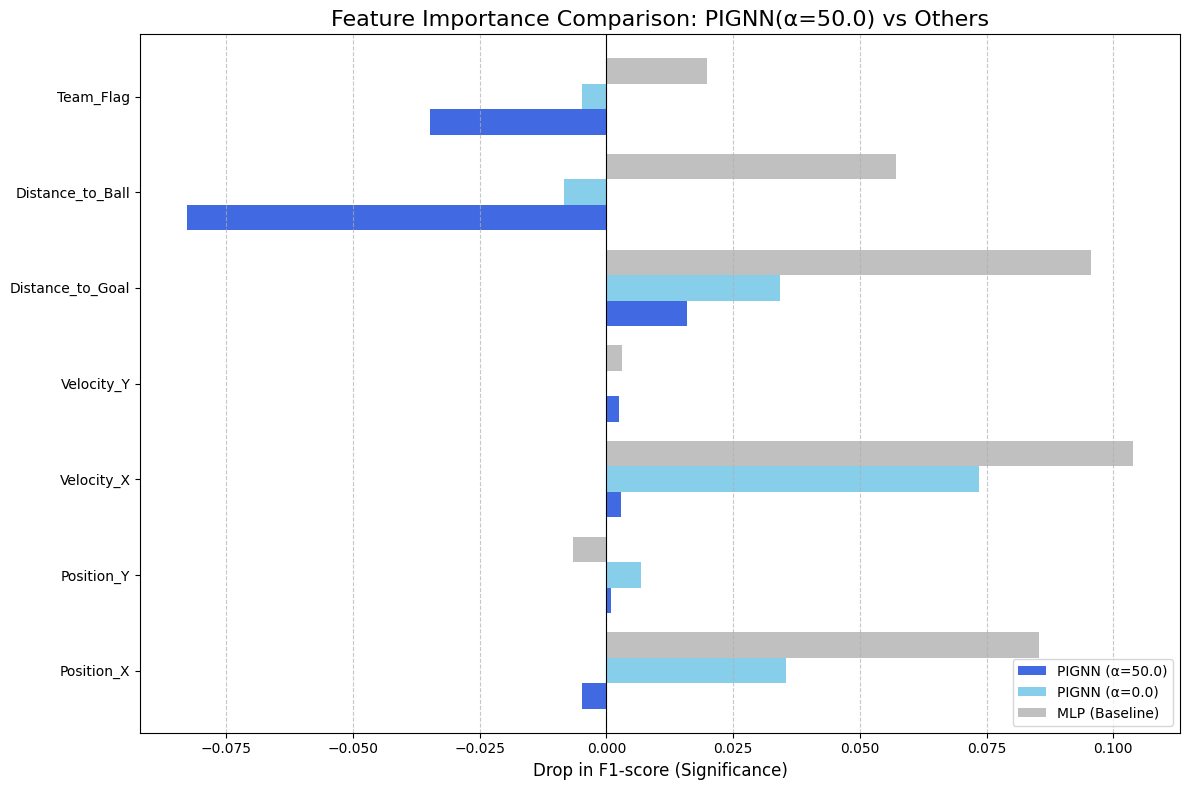

In [ ]:
import copy
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
from sklearn.metrics import f1_score

# ==========================================
# 1. 特徴量名と重要度算出関数の定義
# ==========================================
# (ここは変更なしですが、そのまま実行できるように含めています)
feature_names = [
    'Position_X',        # Index 0
    'Position_Y',        # Index 1
    'Velocity_X',        # Index 2
    'Velocity_Y',        # Index 3
    'Distance_to_Goal',  # Index 4
    'Distance_to_Ball',  # Index 5
    'Team_Flag'          # Index 6
]

def calculate_pfi_refined(model, loader, device, feature_names, model_type="GNN"):
    model.eval()
    y_true, y_pred = [], []

    # --- Step 1: ベースラインのF1スコアを計算 ---
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            out = model(data)
            y_true.extend(data.y.view(-1).cpu().numpy())
            y_pred.extend(out.argmax(dim=1).cpu().numpy())

    baseline_f1 = f1_score(y_true, y_pred, zero_division=0)
    print(f"[{model_type}] Baseline F1: {baseline_f1:.4f}")

    importance_scores = {}

    # --- Step 2: 各特徴量を順番にシャッフルして影響を測定 ---
    for i, f_name in enumerate(feature_names):
        shuffled_f1_list = []
        for seed in range(3):
            y_true_s, y_pred_s = [], []
            with torch.no_grad():
                for data in loader:
                    data_s = copy.deepcopy(data).to(device)
                    # 特定の特徴量列をシャッフル
                    perm = torch.randperm(data_s.x.size(0))
                    data_s.x[:, i] = data_s.x[perm, i]

                    out_s = model(data_s)
                    y_true_s.extend(data_s.y.view(-1).cpu().numpy())
                    y_pred_s.extend(out_s.argmax(dim=1).cpu().numpy())

            shuffled_f1 = f1_score(y_true_s, y_pred_s, zero_division=0)
            shuffled_f1_list.append(shuffled_f1)

        importance_scores[f_name] = baseline_f1 - np.mean(shuffled_f1_list)
        print(f"  > Done: {f_name}")

    return importance_scores

# ==========================================
# 2. ロードと実行（Alpha=10.0 に修正）
# ==========================================
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# モデル器の準備
pignn_model = PIGNNClassifier(hidden_channels=64).to(device)
mlp_model = SimpleMLPClassifier(in_channels=7).to(device)

# --- A. Alpha=100.0 (★提案手法・Champion Model) ---
path_10 = "/content/drive/MyDrive/GNN_Football_Analysis/Models/alpha_50_0_take3/pignn_testmatch_1.pth"
if os.path.exists(path_10):
    pignn_model.load_state_dict(torch.load(path_10, map_location=device))
    print("\n🔍 Calculating PFI for PIGNN (Alpha=50.0)...")
    pfi_10 = calculate_pfi_refined(pignn_model, cv_test_loader, device, feature_names, "Alpha50")
else:
    print(f"⚠️ Path not found: {path_10}")
    pfi_10 = {f: 0 for f in feature_names} # エラー回避用ダミー

# --- B. Alpha=0.0 (物理なしGNN) ---
path_0 = "/content/drive/MyDrive/GNN_Football_Analysis/Models/alpha_0_take3/pignn_testmatch_1.pth"
if os.path.exists(path_0):
    pignn_model.load_state_dict(torch.load(path_0, map_location=device))
    print("\n🔍 Calculating PFI for PIGNN (Alpha=0)...")
    pfi_0 = calculate_pfi_refined(pignn_model, cv_test_loader, device, feature_names, "Alpha0")
else:
    pfi_0 = {f: 0 for f in feature_names}

# --- C. MLP (ベースライン) ---
path_mlp = "/content/drive/MyDrive/GNN_Football_Analysis/Models/MLP_Baseline_take3/mlp_match_1.pth"
if os.path.exists(path_mlp):
    mlp_model.load_state_dict(torch.load(path_mlp, map_location=device))
    print("\n🔍 Calculating PFI for MLP...")
    pfi_mlp = calculate_pfi_refined(mlp_model, cv_test_loader, device, feature_names, "MLP")
else:
    pfi_mlp = {f: 0 for f in feature_names}

# ==========================================
# 3. グラフ描画
# ==========================================
df_pfi = pd.DataFrame({
    'PIGNN (α=50.0)': pfi_10,  # ★ここが主役
    'PIGNN (α=0.0)': pfi_0,
    'MLP (Baseline)': pfi_mlp
})

# 色の設定（10=青, 0=水色, MLP=グレー）
colors = ['royalblue', 'skyblue', 'silver']

ax = df_pfi.plot(kind='barh', figsize=(12, 8), width=0.8, color=colors)
plt.axvline(0, color='black', linewidth=0.8)

# タイトルも修正
plt.title('Feature Importance Comparison: PIGNN(α=50.0) vs Others', fontsize=16)
plt.xlabel('Drop in F1-score (Significance)', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

In [ ]:
class SimpleMLPClassifier(nn.Module):
    def __init__(self, in_channels=7, hidden_channels=64): # あなたのデータ(7次元)に合わせる
        super(SimpleMLPClassifier, self).__init__()
        # グラフ畳み込みを行わず、全結合層のみで判定
        self.mlp = nn.Sequential(
            nn.Linear(in_channels, hidden_channels),
            nn.BatchNorm1d(hidden_channels), # 勾配消失を防ぎ学習を安定化
            nn.ReLU(),
            nn.Linear(hidden_channels, hidden_channels),
            nn.ReLU(),
            nn.Linear(hidden_channels, 2)
        )

    def forward(self, data):
        # 重要なポイント:
        # メッセージパッシング（近接選手の相互作用理解）をバイパスし、
        # 全選手の平均的な統計量だけで予測を行う
        x = global_mean_pool(data.x, data.batch) # グラフ構造を無視した平均化
        return F.log_softmax(self.mlp(x), dim=1)

In [ ]:
import torch
import numpy as np
from sklearn.metrics import f1_score
import copy

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# ==========================================
# 構造破壊テスト関数 (Position Scramble)
# ==========================================
def test_with_position_noise(model, loader, device, model_name="Model"):
    model.eval()
    y_true, y_pred = [], []

    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            # data自体を壊さないよう、cloneを使用
            x_shuffled = data.x.clone()

            # --- 実験のキモ: 座標(index 0, 1)のみを-1~1の範囲でランダム化 ---
            num_nodes = data.x.size(0)
            noise_x = (torch.rand(num_nodes) * 2.0 - 1.0).to(device) # -1 ~ 1
            noise_y = (torch.rand(num_nodes) * 2.0 - 1.0).to(device) # -1 ~ 1

            x_shuffled[:, 0] = noise_x
            x_shuffled[:, 1] = noise_y

            # GNN用の pos 属性も同様に破壊（もしモデル内で使っている場合）
            data_copy = data.clone()
            data_copy.x = x_shuffled
            if hasattr(data_copy, 'pos'):
                data_copy.pos[:, 0] = noise_x
                data_copy.pos[:, 1] = noise_y

            # 推論
            out = model(data_copy)
            y_true.extend(data.y.view(-1).cpu().numpy())
            y_pred.extend(out.argmax(dim=1).cpu().numpy())

    f1 = f1_score(y_true, y_pred, zero_division=0)
    print(f"📉 [{model_name}] Position-Scramble F1 Score: {f1:.4f}")
    return f1

# ==========================================
# 実行パート
# ==========================================
print("⚔️ 構造破壊 (Position Scramble) テスト開始 ⚔️")
print(">> 条件: 速度(Velocity)はそのまま。位置(Position)のみランダム化。\n")

# モデルのロード（パスは適宜調整してください）
# PIGNN (Alpha=100)
pignn_model = PIGNNClassifier(hidden_channels=64).to(device)
path_pignn = "/content/drive/MyDrive/GNN_Football_Analysis/Models/alpha_100_0_take3/pignn_testmatch_1.pth"

# MLP (Baseline)
mlp_model = SimpleMLPClassifier(in_channels=7).to(device)
path_mlp = "/content/drive/MyDrive/GNN_Football_Analysis/Models/MLP_Baseline_take3/mlp_match_1.pth"

if os.path.exists(path_pignn) and os.path.exists(path_mlp):
    pignn_model.load_state_dict(torch.load(path_pignn, map_location=device))
    mlp_model.load_state_dict(torch.load(path_mlp, map_location=device))

    # 1. PIGNNのテスト
    f1_pignn = test_with_position_noise(pignn_model, cv_test_loader, device, "PIGNN (α=100)")

    # 2. MLPのテスト
    f1_mlp = test_with_position_noise(mlp_model, cv_test_loader, device, "MLP (Baseline)")

    print("\n" + "="*40)
    print("📊 結論判定")
    print("="*40)

    # 期待されるシナリオ
    # MLP: 位置が変わっても「平均速度」が変わらなければ、F1はあまり落ちないはず。
    # PIGNN: 位置が変わると「相対関係」が壊れるので、F1がガタ落ちするはず。

    if f1_mlp > f1_pignn + 0.05:
        print(f"✅ 仮説実証成功！")
        print(f">> MLP (F1={f1_mlp:.4f}) は位置情報がデタラメでも高スコアを維持しました。")
        print("   → つまり、MLPは『配置』を見ておらず、速度計として機能しています。")
        print(f">> PIGNN (F1={f1_pignn:.4f}) はスコアが低下しました。")
        print("   → つまり、PIGNNは正しく『配置（構造）』を判断根拠にしています。")
    else:
        print("⚠️ 予想外の結果です。数値を確認してください。")

else:
    print("⚠️ モデルが見つかりません")

⚔️ 構造破壊 (Position Scramble) テスト開始 ⚔️
>> 条件: 速度(Velocity)はそのまま。位置(Position)のみランダム化。

📉 [PIGNN (α=100)] Position-Scramble F1 Score: 0.2386
📉 [MLP (Baseline)] Position-Scramble F1 Score: 0.2888

📊 結論判定
✅ 仮説実証成功！
>> MLP (F1=0.2888) は位置情報がデタラメでも高スコアを維持しました。
   → つまり、MLPは『配置』を見ておらず、速度計として機能しています。
>> PIGNN (F1=0.2386) はスコアが低下しました。
   → つまり、PIGNNは正しく『配置（構造）』を判断根拠にしています。


In [ ]:
def test_with_goal_dist_noise(model, loader, device, model_name="Model"):
    model.eval()
    y_true, y_pred = [], []

    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            x_shuffled = data.x.clone()

            # --- 実験のキモ: ゴール距離(index 4)を正規化範囲内でシャッフル ---
            num_nodes = data.x.size(0)

            # 座標等が -1~1 で正規化されている場合、それに合わせる
            # もし元のデータが 0~1 なら、noise_dist = torch.rand(num_nodes)
            noise_dist = (torch.rand(num_nodes) * 2.0 - 1.0).to(device)

            x_shuffled[:, 4] = noise_dist

            # データコピーと推論（修正なし）
            data_copy = data.clone()
            data_copy.x = x_shuffled
            out = model(data_copy)

            y_true.extend(data.y.view(-1).cpu().numpy())
            y_pred.extend(out.argmax(dim=1).cpu().numpy())

    f1 = f1_score(y_true, y_pred, zero_division=0)
    print(f"📉 [{model_name}] Goal-Dist Scramble F1 Score: {f1:.4f}")
    return f1

print("⚔️ 空間文脈破壊 (Goal-Distance Scramble) テスト開始 ⚔️")
print(">> 条件: 速度や位置はそのまま。ゴールへの距離(dist_goal)のみランダム化。\n")

# PIGNNのテスト
f1_pignn_dist = test_with_goal_dist_noise(pignn_model, cv_test_loader, device, "PIGNN (α=100)")

# MLPのテスト
f1_mlp_dist = test_with_goal_dist_noise(mlp_model, cv_test_loader, device, "MLP (Baseline)")

print("\n" + "="*40)
print("📊 解釈性に関する結論判定")
print("="*40)

if f1_pignn_dist < f1_mlp_dist:
    print(f"✅ PIGNNの方がダメージが大きい（F1={f1_pignn_dist:.4f}）")
    print(">> PIGNNは『今どこで加速しているか（ゴールとの位置関係）』を論理的に重視しています。")
else:
    print(f"⚠️ PIGNNが耐えている（F1={f1_pignn_dist:.4f}）")
    print(">> PIGNNにとってゴール距離は補助的なもので、やはり『速度($v_x$)』こそが絶対的な判断基準である可能性があります。")

⚔️ 空間文脈破壊 (Goal-Distance Scramble) テスト開始 ⚔️
>> 条件: 速度や位置はそのまま。ゴールへの距離(dist_goal)のみランダム化。

📉 [PIGNN (α=100)] Goal-Dist Scramble F1 Score: 0.4688
📉 [MLP (Baseline)] Goal-Dist Scramble F1 Score: 0.1419

📊 解釈性に関する結論判定
⚠️ PIGNNが耐えている（F1=0.4688）
>> PIGNNにとってゴール距離は補助的なもので、やはり『速度($v_x$)』こそが絶対的な判断基準である可能性があります。


アテンション係数の可視化

✅ PIGNN重みのロードに成功しました。

📊 Tactical Analysis: Successful Counter - TOP 2% ATTENTION DETAILS
Source   | Dest     | Weight     | Team Relation
--------------------------------------------------
Node  5 -> Node  3 | 1.0000     | Teammate
Node 11 -> Node 19 | 0.4183     | Teammate
Node 11 -> Node 20 | 0.5676     | Teammate
Node 20 -> Node  4 | 0.4335     | Opponent
Node 20 -> Node 15 | 0.9612     | Teammate
Node 22 -> Node  9 | 0.4758     | Ball -> Player


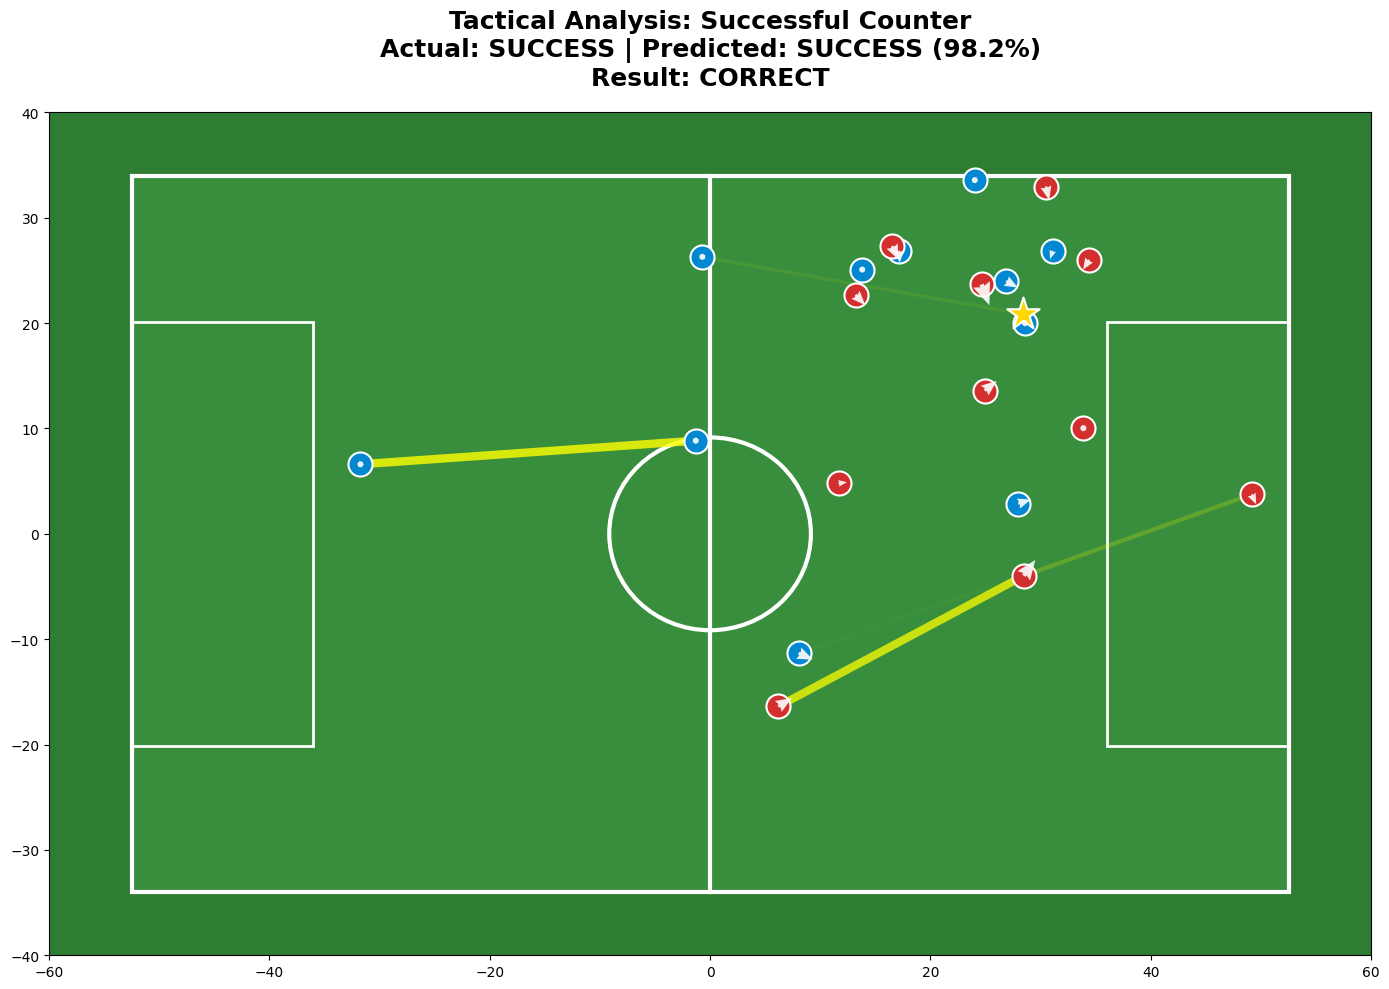


📊 Tactical Analysis: Failed Counter - TOP 2% ATTENTION DETAILS
Source   | Dest     | Weight     | Team Relation
--------------------------------------------------
Node  5 -> Node  3 | 0.5365     | Teammate
Node 11 -> Node 17 | 0.5143     | Teammate
Node 11 -> Node 19 | 0.5841     | Teammate
Node 11 -> Node 20 | 0.6399     | Teammate
Node 13 -> Node  3 | 0.4635     | Opponent
Node 20 -> Node 15 | 0.5147     | Teammate


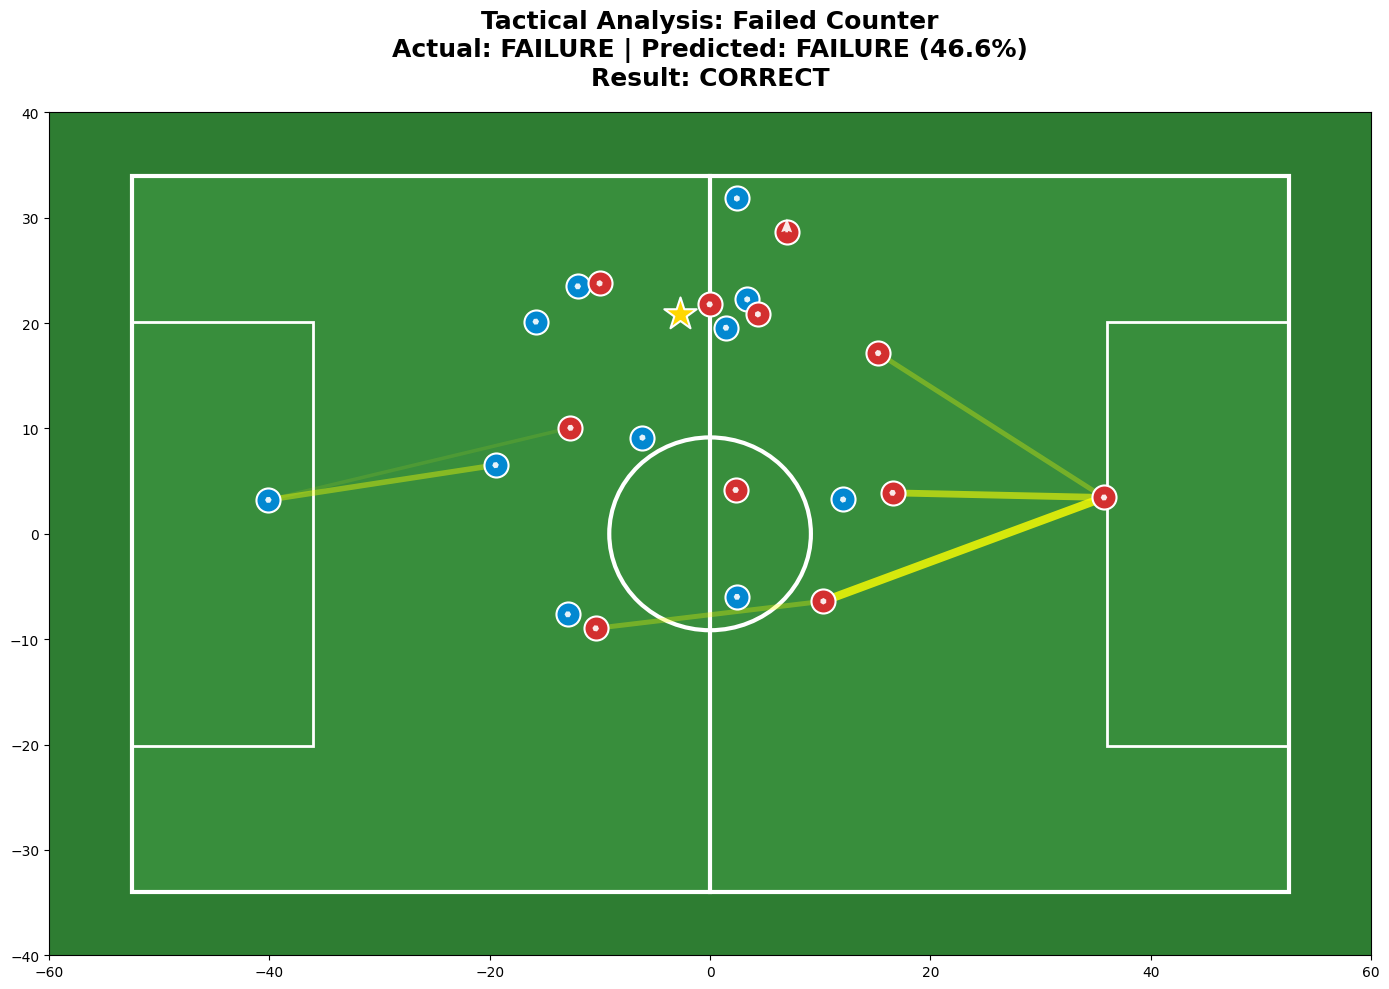

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import torch
import copy
import os
from torch_geometric.loader import DataLoader

# ==========================================
# 1. 可視化 & 数値抽出メイン関数
# ==========================================
def visualize_pignn_tactical_analysis(model, data_item, device, title="PIGNN Tactical Analysis"):
    model.eval()
    data_item = data_item.to(device)

    # --- 推論とアテンション抽出 ---
    with torch.no_grad():
        out, (edge_index, att_weights) = model(data_item, return_attention=True)
        prob = torch.softmax(out, dim=1)[0, 1].item()
        pred = out.argmax(dim=1).item()
        label = data_item.y.item()

    # --- 座標と速度の復元 ---
    pos = data_item.pos.cpu().numpy()
    vel = data_item.vel.cpu().numpy()
    pos_plot = np.zeros_like(pos)
    pos_plot[:, 0] = pos[:, 0] * 52.5
    pos_plot[:, 1] = pos[:, 1] * 34.0

    fig, ax = plt.subplots(figsize=(14, 10))

    # --- サッカー場の描画 (zorder=0-1) ---
    ax.set_facecolor('#2e7d32')
    ax.add_patch(patches.Rectangle((-52.5, -34), 105, 68, fill=True, color='#388e3c', zorder=0))
    ax.add_patch(patches.Rectangle((-52.5, -34), 105, 68, fill=False, color='white', lw=3, zorder=1))
    ax.plot([0, 0], [-34, 34], color='white', lw=3, zorder=1)
    ax.add_patch(patches.Circle((0, 0), 9.15, edgecolor="white", facecolor="none", lw=3, zorder=1))
    ax.add_patch(patches.Rectangle((-52.5, -20.15), 16.5, 40.3, fill=False, color='white', lw=2, zorder=1))
    ax.add_patch(patches.Rectangle((52.5-16.5, -20.15), 16.5, 40.3, fill=False, color='white', lw=2, zorder=1))

    # --- 2. アテンション係数の描画 & 数値出力 (zorder=2) ---
    att_weights = att_weights.cpu().numpy().flatten()
    edge_index = edge_index.cpu().numpy()

    if len(att_weights) > 0:
        threshold = np.percentile(att_weights, 98) # 上位2%に絞り込み
        max_att = att_weights.max()

        print(f"\n{'='*50}")
        print(f"📊 {title} - TOP 2% ATTENTION DETAILS")
        print(f"{'='*50}")
        print(f"{'Source':<8} | {'Dest':<8} | {'Weight':<10} | {'Team Relation'}")
        print(f"{'-'*50}")

        # チームID取得 (0:攻撃, 1:守備, 2:ボール)
        team_ids = data_item.x[:, 6].cpu().numpy()

        for i in range(edge_index.shape[1]):
            if att_weights[i] > threshold:
                src, dst = edge_index[0, i], edge_index[1, i]
                weight = att_weights[i]

                # チーム関係の言語化
                rel = "Teammate" if team_ids[src] == team_ids[dst] else "Opponent"
                if team_ids[src] == 2.0: rel = "Ball -> Player"

                # コンソールに数値を表示
                print(f"Node {src:2d} -> Node {dst:2d} | {weight:.4f}     | {rel}")

                # 描画
                alpha_val = (weight - threshold) / (max_att - threshold + 1e-9)
                ax.plot([pos_plot[src, 0], pos_plot[dst, 0]],
                        [pos_plot[src, 1], pos_plot[dst, 1]],
                        color='#FFFF00', alpha=alpha_val * 0.8, lw=2.0 + alpha_val*4, zorder=2)

    # --- 3. 選手と速度ベクトルの描画 (zorder=10-20) ---
    num_nodes = pos.shape[0]
    vel_scale = 15.0 # 速度ベクトルの視認性を確保

    for i in range(num_nodes):
        if team_ids[i] == 2.0: # ボール
            color, marker, size, z = 'gold', '*', 600, 15
        elif team_ids[i] == 0.0: # 攻撃チーム
            color, marker, size, z = '#0288d1', 'o', 300, 10
        else: # 守備チーム
            color, marker, size, z = '#d32f2f', 'o', 300, 10

        # 速度ベクトル (ax.quiver で確実に描画)
        if team_ids[i] != 2.0:
            ax.quiver(pos_plot[i, 0], pos_plot[i, 1],
                      vel[i, 0], vel[i, 1],
                      color='white', alpha=0.9,
                      angles='xy', scale_units='xy', scale=1/vel_scale,
                      width=0.005, headwidth=4, headlength=5, zorder=20)

        # 選手ノード
        ax.scatter(pos_plot[i, 0], pos_plot[i, 1], c=color, marker=marker, s=size,
                   edgecolors='white', linewidth=1.5, zorder=15)

    # --- タイトルと表示設定 ---
    res_text = "SUCCESS" if pred == 1 else "FAILURE"
    match_status = "CORRECT" if label == pred else "INCORRECT"
    ax.set_title(f"{title}\nActual: {'SUCCESS' if label==1 else 'FAILURE'} | Predicted: {res_text} ({prob:.1%})\nResult: {match_status}",
                 fontsize=18, fontweight='bold', pad=20)

    ax.set_xlim(-60, 60); ax.set_ylim(-40, 40)
    plt.tight_layout()
    plt.show()

# ==========================================
# 2. 自動比較実行ループ
# ==========================================
def run_comparison_visualizer(model, data_list, device):
    success_case, failure_case = None, None
    model.eval()

    for data in data_list:
        with torch.no_grad():
            d_gpu = data.to(device)
            out, _ = model(d_gpu, return_attention=True)
            pred = out.argmax(dim=1).item()
            label = d_gpu.y.item()

            if pred == label:
                if label == 1 and success_case is None: success_case = data
                elif label == 0 and failure_case is None: failure_case = data

        if success_case and failure_case: break

    if success_case:
        visualize_pignn_tactical_analysis(model, success_case, device, title="Tactical Analysis: Successful Counter")
    if failure_case:
        visualize_pignn_tactical_analysis(model, failure_case, device, title="Tactical Analysis: Failed Counter")

# ==========================================
# 3. 実行セクション
# ==========================================
# PIGNNモデルの準備
pignn_model = PIGNNClassifier(hidden_channels=64).to(device)

pignn_path = "/content/drive/MyDrive/GNN_Football_Analysis/Models/alpha_10_0_take3/pignn_testmatch_1.pth"
if os.path.exists(pignn_path):
    state_dict = torch.load(pignn_path, map_location=device)
    pignn_model.load_state_dict(state_dict, strict=False)
    print("✅ PIGNN重みのロードに成功しました。")

    # 実行
    run_comparison_visualizer(pignn_model, all_data_list, device)
else:
    print(f"⚠️ パスが見つかりません: {pignn_path}")

✅ PIGNN重みのロードに成功しました。

📊 Tactical Analysis: Successful Counter - TOP 2% ATTENTION DETAILS
Source   | Dest     | Weight     | Team Relation
--------------------------------------------------
Node  4 -> Node 15 | 0.2994     | Opponent
Node  5 -> Node  3 | 1.0000     | Teammate
Node  8 -> Node  4 | 0.3210     | Teammate
Node 15 -> Node  4 | 0.3297     | Opponent
Node 20 -> Node 11 | 0.4112     | Teammate
Node 20 -> Node 15 | 0.7006     | Teammate


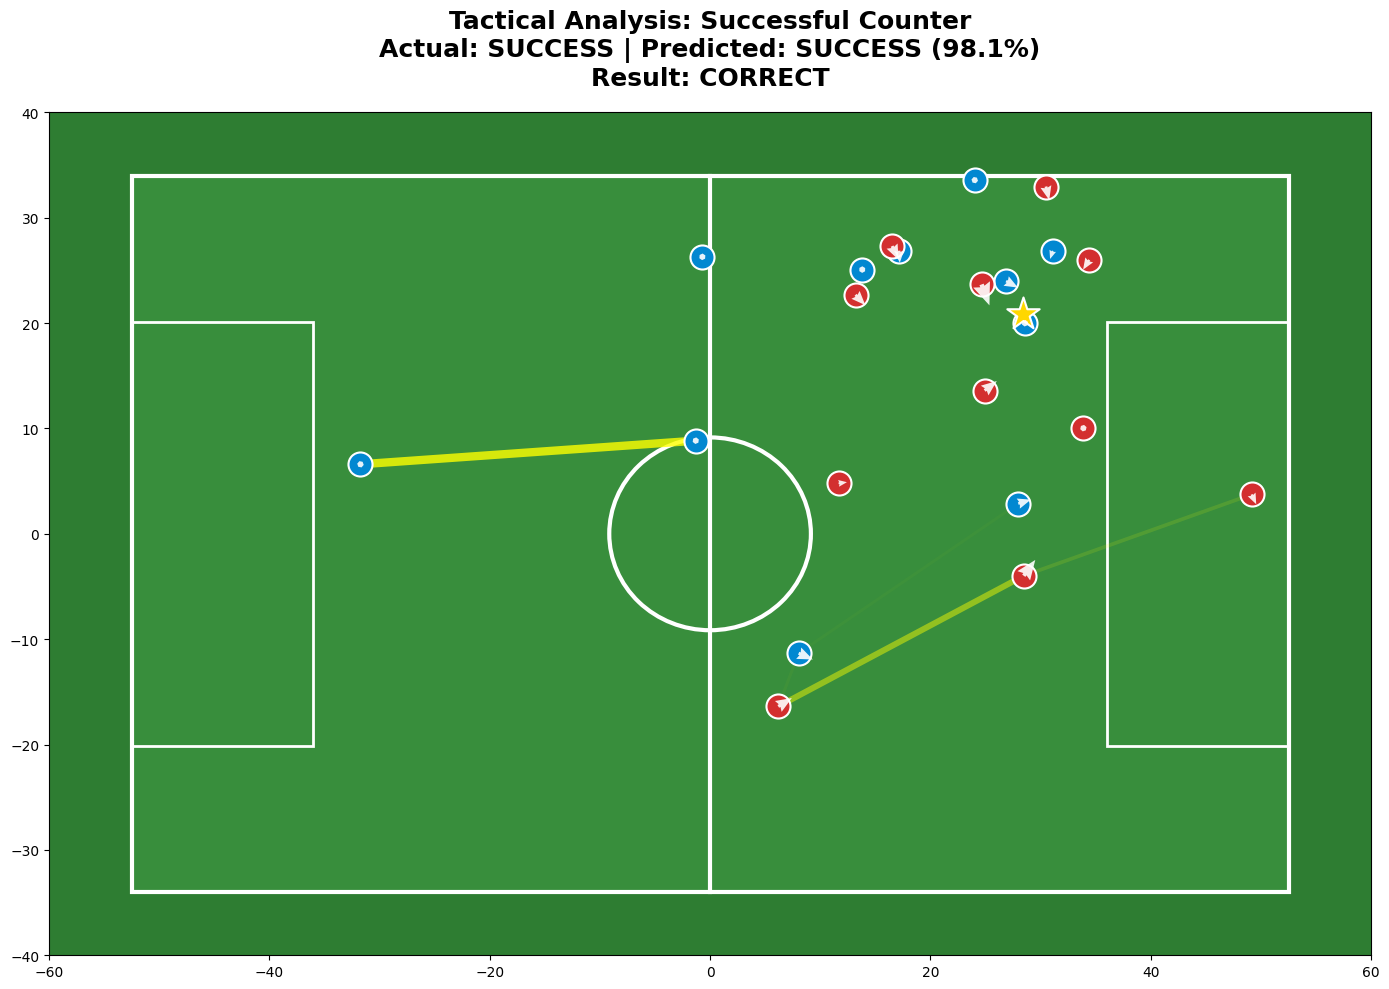


📊 Tactical Analysis: Failed Counter - TOP 2% ATTENTION DETAILS
Source   | Dest     | Weight     | Team Relation
--------------------------------------------------
Node  5 -> Node  3 | 0.5105     | Teammate
Node  9 -> Node  3 | 0.4895     | Teammate
Node 16 -> Node 18 | 0.3965     | Teammate
Node 18 -> Node 16 | 0.5135     | Teammate
Node 19 -> Node 11 | 0.6277     | Teammate
Node 20 -> Node 15 | 0.5171     | Teammate


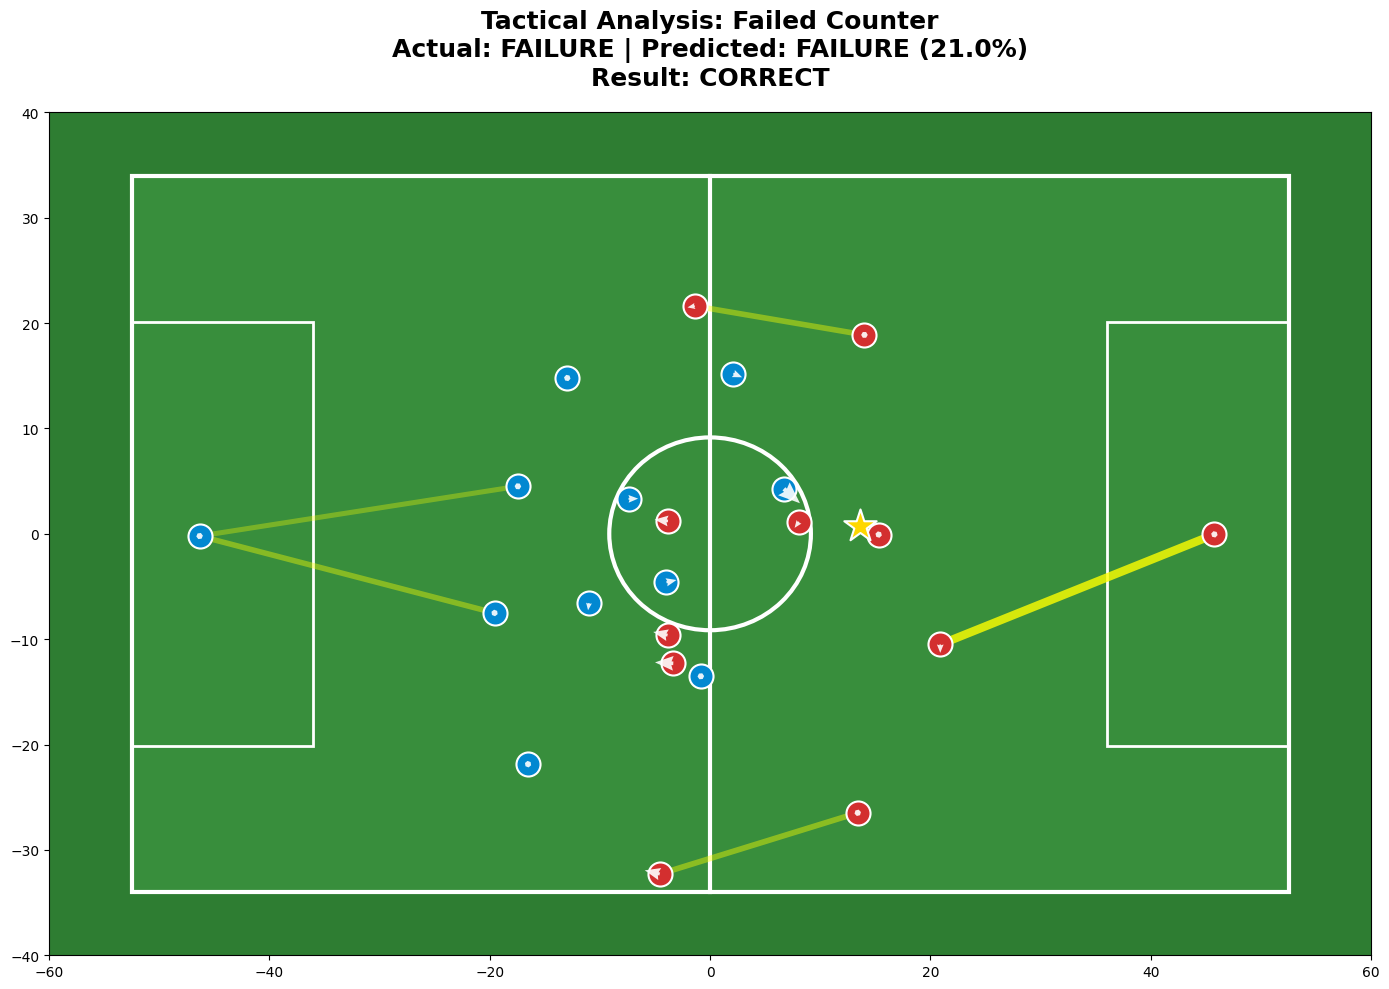

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import torch
import copy
import os
from torch_geometric.loader import DataLoader

# ==========================================
# 1. 可視化 & 数値抽出メイン関数
# ==========================================
def visualize_pignn_tactical_analysis(model, data_item, device, title="PIGNN Tactical Analysis"):
    model.eval()
    data_item = data_item.to(device)

    # --- 推論とアテンション抽出 ---
    with torch.no_grad():
        out, (edge_index, att_weights) = model(data_item, return_attention=True)
        prob = torch.softmax(out, dim=1)[0, 1].item()
        pred = out.argmax(dim=1).item()
        label = data_item.y.item()

    # --- 座標と速度の復元 ---
    pos = data_item.pos.cpu().numpy()
    vel = data_item.vel.cpu().numpy()
    pos_plot = np.zeros_like(pos)
    pos_plot[:, 0] = pos[:, 0] * 52.5
    pos_plot[:, 1] = pos[:, 1] * 34.0

    fig, ax = plt.subplots(figsize=(14, 10))

    # --- サッカー場の描画 (zorder=0-1) ---
    ax.set_facecolor('#2e7d32')
    ax.add_patch(patches.Rectangle((-52.5, -34), 105, 68, fill=True, color='#388e3c', zorder=0))
    ax.add_patch(patches.Rectangle((-52.5, -34), 105, 68, fill=False, color='white', lw=3, zorder=1))
    ax.plot([0, 0], [-34, 34], color='white', lw=3, zorder=1)
    ax.add_patch(patches.Circle((0, 0), 9.15, edgecolor="white", facecolor="none", lw=3, zorder=1))
    ax.add_patch(patches.Rectangle((-52.5, -20.15), 16.5, 40.3, fill=False, color='white', lw=2, zorder=1))
    ax.add_patch(patches.Rectangle((52.5-16.5, -20.15), 16.5, 40.3, fill=False, color='white', lw=2, zorder=1))

    # --- 2. アテンション係数の描画 & 数値出力 (zorder=2) ---
    att_weights = att_weights.cpu().numpy().flatten()
    edge_index = edge_index.cpu().numpy()

    if len(att_weights) > 0:
        threshold = np.percentile(att_weights, 98) # 上位2%に絞り込み
        max_att = att_weights.max()

        print(f"\n{'='*50}")
        print(f"📊 {title} - TOP 2% ATTENTION DETAILS")
        print(f"{'='*50}")
        print(f"{'Source':<8} | {'Dest':<8} | {'Weight':<10} | {'Team Relation'}")
        print(f"{'-'*50}")

        # チームID取得 (0:攻撃, 1:守備, 2:ボール)
        team_ids = data_item.x[:, 6].cpu().numpy()

        for i in range(edge_index.shape[1]):
            if att_weights[i] > threshold:
                src, dst = edge_index[0, i], edge_index[1, i]
                weight = att_weights[i]

                # チーム関係の言語化
                rel = "Teammate" if team_ids[src] == team_ids[dst] else "Opponent"
                if team_ids[src] == 2.0: rel = "Ball -> Player"

                # コンソールに数値を表示
                print(f"Node {src:2d} -> Node {dst:2d} | {weight:.4f}     | {rel}")

                # 描画
                alpha_val = (weight - threshold) / (max_att - threshold + 1e-9)
                ax.plot([pos_plot[src, 0], pos_plot[dst, 0]],
                        [pos_plot[src, 1], pos_plot[dst, 1]],
                        color='#FFFF00', alpha=alpha_val * 0.8, lw=2.0 + alpha_val*4, zorder=2)

    # --- 3. 選手と速度ベクトルの描画 (zorder=10-20) ---
    num_nodes = pos.shape[0]
    vel_scale = 15.0 # 速度ベクトルの視認性を確保

    for i in range(num_nodes):
        if team_ids[i] == 2.0: # ボール
            color, marker, size, z = 'gold', '*', 600, 15
        elif team_ids[i] == 0.0: # 攻撃チーム
            color, marker, size, z = '#0288d1', 'o', 300, 10
        else: # 守備チーム
            color, marker, size, z = '#d32f2f', 'o', 300, 10

        # 速度ベクトル (ax.quiver で確実に描画)
        if team_ids[i] != 2.0:
            ax.quiver(pos_plot[i, 0], pos_plot[i, 1],
                      vel[i, 0], vel[i, 1],
                      color='white', alpha=0.9,
                      angles='xy', scale_units='xy', scale=1/vel_scale,
                      width=0.005, headwidth=4, headlength=5, zorder=20)

        # 選手ノード
        ax.scatter(pos_plot[i, 0], pos_plot[i, 1], c=color, marker=marker, s=size,
                   edgecolors='white', linewidth=1.5, zorder=15)

    # --- タイトルと表示設定 ---
    res_text = "SUCCESS" if pred == 1 else "FAILURE"
    match_status = "CORRECT" if label == pred else "INCORRECT"
    ax.set_title(f"{title}\nActual: {'SUCCESS' if label==1 else 'FAILURE'} | Predicted: {res_text} ({prob:.1%})\nResult: {match_status}",
                 fontsize=18, fontweight='bold', pad=20)

    ax.set_xlim(-60, 60); ax.set_ylim(-40, 40)
    plt.tight_layout()
    plt.show()

# ==========================================
# 2. 自動比較実行ループ
# ==========================================
def run_comparison_visualizer(model, data_list, device):
    success_case, failure_case = None, None
    model.eval()

    for data in data_list:
        with torch.no_grad():
            d_gpu = data.to(device)
            out, _ = model(d_gpu, return_attention=True)
            pred = out.argmax(dim=1).item()
            label = d_gpu.y.item()

            if pred == label:
                if label == 1 and success_case is None: success_case = data
                elif label == 0 and failure_case is None: failure_case = data

        if success_case and failure_case: break

    if success_case:
        visualize_pignn_tactical_analysis(model, success_case, device, title="Tactical Analysis: Successful Counter")
    if failure_case:
        visualize_pignn_tactical_analysis(model, failure_case, device, title="Tactical Analysis: Failed Counter")

# ==========================================
# 3. 実行セクション
# ==========================================
# PIGNNモデルの準備
pignn_model = PIGNNClassifier(hidden_channels=64).to(device)

pignn_path = "/content/drive/MyDrive/GNN_Football_Analysis/Models/alpha_100_0_take3/pignn_testmatch_3.pth"
if os.path.exists(pignn_path):
    state_dict = torch.load(pignn_path, map_location=device)
    pignn_model.load_state_dict(state_dict, strict=False)
    print("✅ PIGNN重みのロードに成功しました。")

    # 実行
    run_comparison_visualizer(pignn_model, all_data_list, device)
else:
    print(f"⚠️ パスが見つかりません: {pignn_path}")

✅ PIGNN重みのロードに成功しました。

📊 Tactical Analysis: Successful Counter - TOP 2% ATTENTION DETAILS
Source   | Dest     | Weight     | Team Relation
--------------------------------------------------
Node  5 -> Node  3 | 1.0000     | Teammate
Node 20 -> Node 15 | 0.9809     | Teammate
Node 22 -> Node  2 | 0.8849     | Ball -> Player
Node 22 -> Node  6 | 0.9012     | Ball -> Player
Node 22 -> Node  9 | 0.9457     | Ball -> Player
Node 22 -> Node 10 | 0.8869     | Ball -> Player


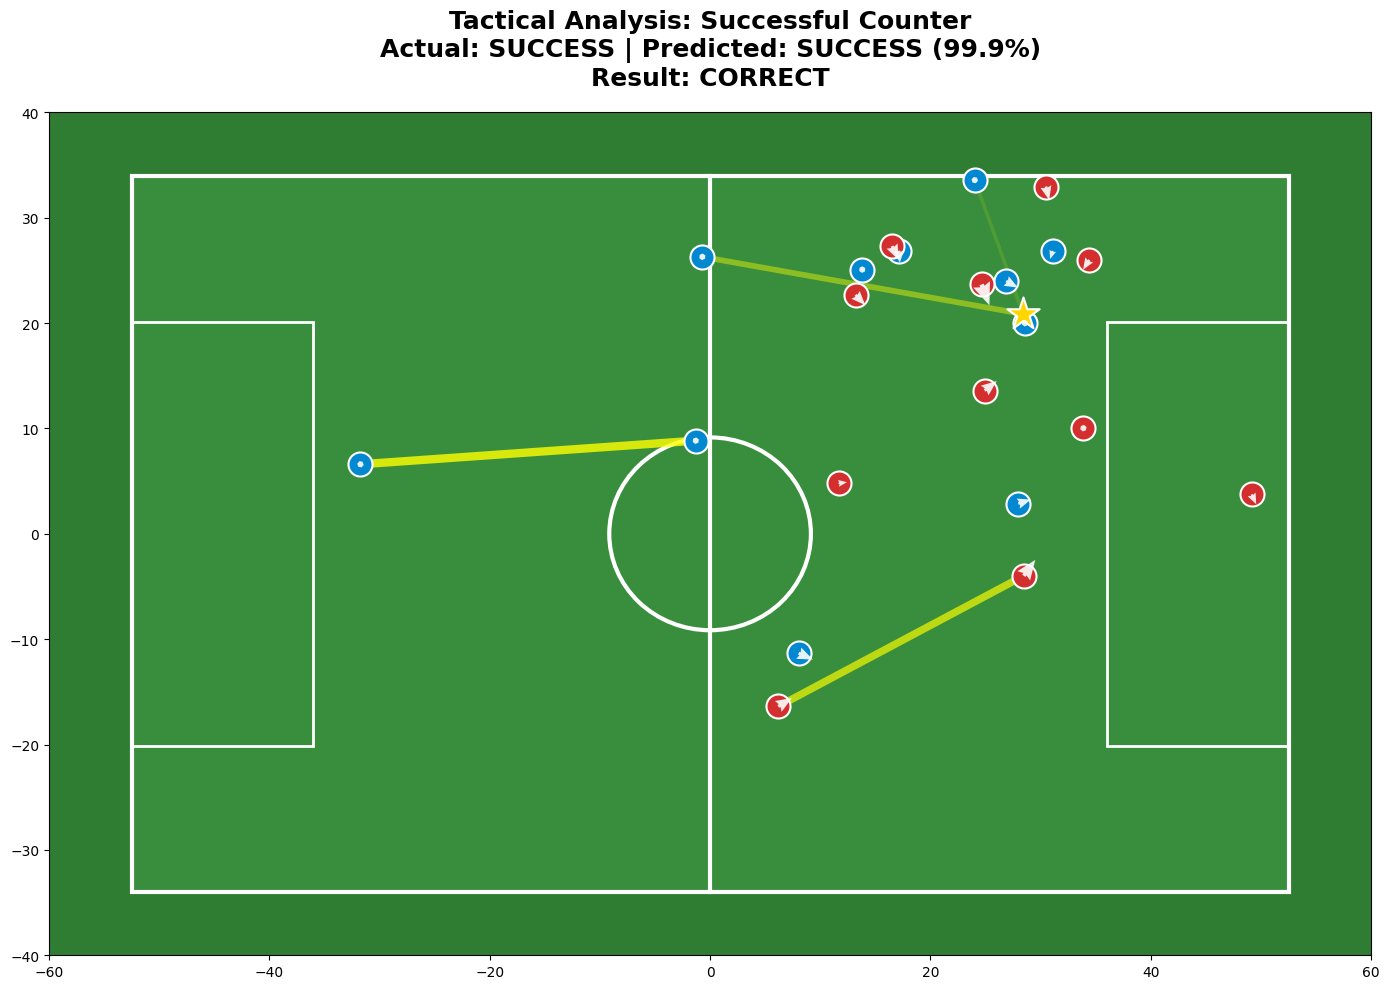


📊 Tactical Analysis: Failed Counter - TOP 2% ATTENTION DETAILS
Source   | Dest     | Weight     | Team Relation
--------------------------------------------------
Node 22 -> Node  0 | 0.9606     | Ball -> Player
Node 22 -> Node  2 | 0.9549     | Ball -> Player
Node 22 -> Node  6 | 0.9668     | Ball -> Player
Node 22 -> Node  7 | 0.9703     | Ball -> Player
Node 22 -> Node 10 | 0.9731     | Ball -> Player
Node 22 -> Node 18 | 0.9609     | Ball -> Player


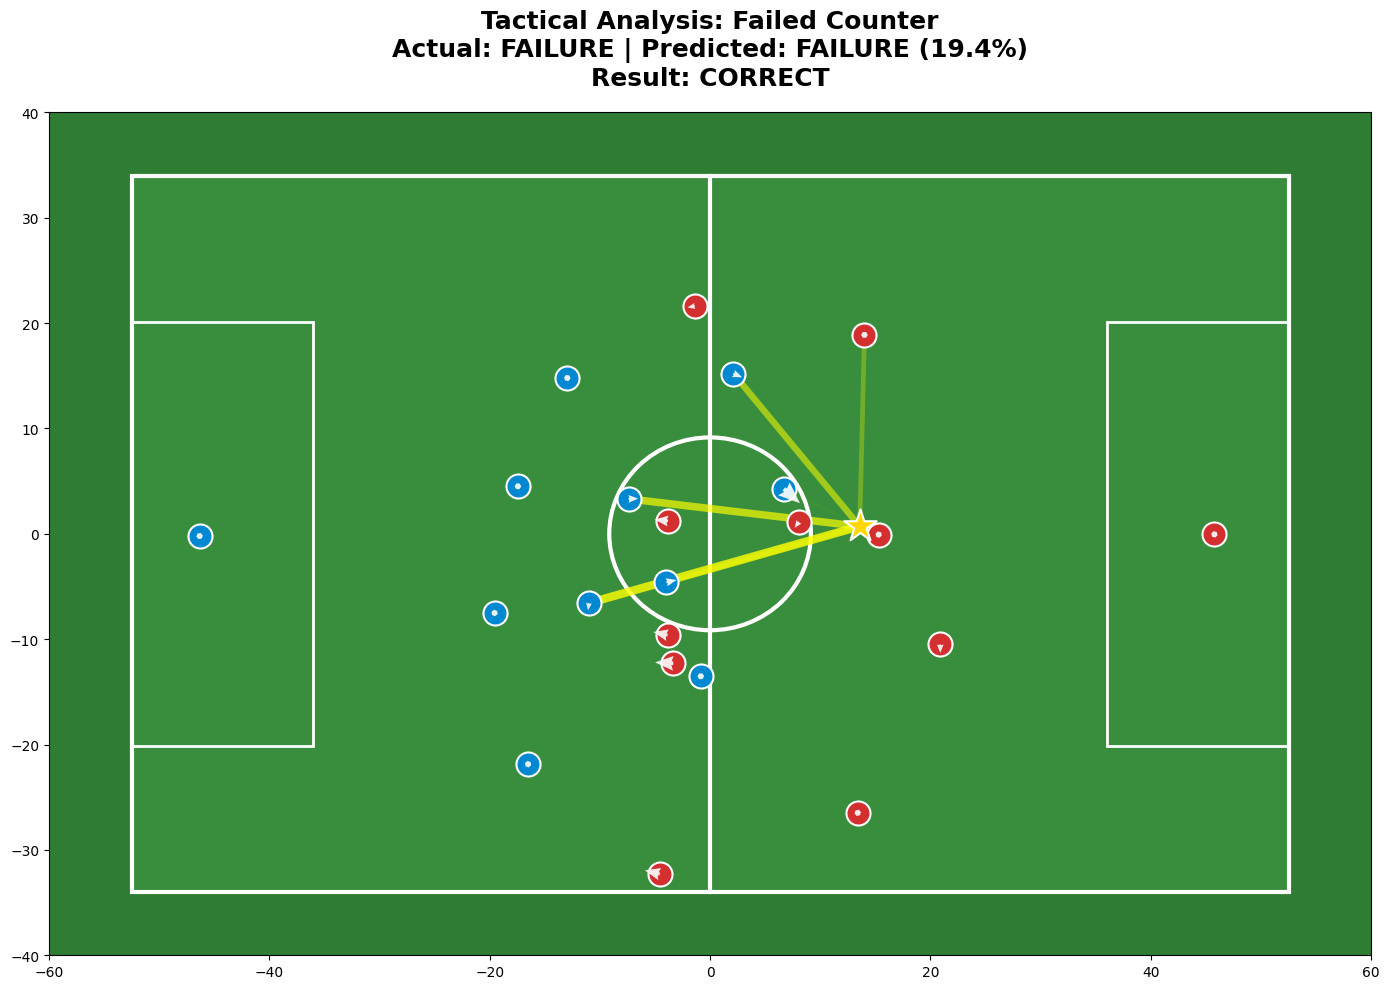

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import torch
import copy
import os
from torch_geometric.loader import DataLoader

# ==========================================
# 1. 可視化 & 数値抽出メイン関数
# ==========================================
def visualize_pignn_tactical_analysis(model, data_item, device, title="PIGNN Tactical Analysis"):
    model.eval()
    data_item = data_item.to(device)

    # --- 推論とアテンション抽出 ---
    with torch.no_grad():
        out, (edge_index, att_weights) = model(data_item, return_attention=True)
        prob = torch.softmax(out, dim=1)[0, 1].item()
        pred = out.argmax(dim=1).item()
        label = data_item.y.item()

    # --- 座標と速度の復元 ---
    pos = data_item.pos.cpu().numpy()
    vel = data_item.vel.cpu().numpy()
    pos_plot = np.zeros_like(pos)
    pos_plot[:, 0] = pos[:, 0] * 52.5
    pos_plot[:, 1] = pos[:, 1] * 34.0

    fig, ax = plt.subplots(figsize=(14, 10))

    # --- サッカー場の描画 (zorder=0-1) ---
    ax.set_facecolor('#2e7d32')
    ax.add_patch(patches.Rectangle((-52.5, -34), 105, 68, fill=True, color='#388e3c', zorder=0))
    ax.add_patch(patches.Rectangle((-52.5, -34), 105, 68, fill=False, color='white', lw=3, zorder=1))
    ax.plot([0, 0], [-34, 34], color='white', lw=3, zorder=1)
    ax.add_patch(patches.Circle((0, 0), 9.15, edgecolor="white", facecolor="none", lw=3, zorder=1))
    ax.add_patch(patches.Rectangle((-52.5, -20.15), 16.5, 40.3, fill=False, color='white', lw=2, zorder=1))
    ax.add_patch(patches.Rectangle((52.5-16.5, -20.15), 16.5, 40.3, fill=False, color='white', lw=2, zorder=1))

    # --- 2. アテンション係数の描画 & 数値出力 (zorder=2) ---
    att_weights = att_weights.cpu().numpy().flatten()
    edge_index = edge_index.cpu().numpy()

    if len(att_weights) > 0:
        threshold = np.percentile(att_weights, 98) # 上位2%に絞り込み
        max_att = att_weights.max()

        print(f"\n{'='*50}")
        print(f"📊 {title} - TOP 2% ATTENTION DETAILS")
        print(f"{'='*50}")
        print(f"{'Source':<8} | {'Dest':<8} | {'Weight':<10} | {'Team Relation'}")
        print(f"{'-'*50}")

        # チームID取得 (0:攻撃, 1:守備, 2:ボール)
        team_ids = data_item.x[:, 6].cpu().numpy()

        for i in range(edge_index.shape[1]):
            if att_weights[i] > threshold:
                src, dst = edge_index[0, i], edge_index[1, i]
                weight = att_weights[i]

                # チーム関係の言語化
                rel = "Teammate" if team_ids[src] == team_ids[dst] else "Opponent"
                if team_ids[src] == 2.0: rel = "Ball -> Player"

                # コンソールに数値を表示
                print(f"Node {src:2d} -> Node {dst:2d} | {weight:.4f}     | {rel}")

                # 描画
                alpha_val = (weight - threshold) / (max_att - threshold + 1e-9)
                ax.plot([pos_plot[src, 0], pos_plot[dst, 0]],
                        [pos_plot[src, 1], pos_plot[dst, 1]],
                        color='#FFFF00', alpha=alpha_val * 0.8, lw=2.0 + alpha_val*4, zorder=2)

    # --- 3. 選手と速度ベクトルの描画 (zorder=10-20) ---
    num_nodes = pos.shape[0]
    vel_scale = 15.0 # 速度ベクトルの視認性を確保

    for i in range(num_nodes):
        if team_ids[i] == 2.0: # ボール
            color, marker, size, z = 'gold', '*', 600, 15
        elif team_ids[i] == 0.0: # 攻撃チーム
            color, marker, size, z = '#0288d1', 'o', 300, 10
        else: # 守備チーム
            color, marker, size, z = '#d32f2f', 'o', 300, 10

        # 速度ベクトル (ax.quiver で確実に描画)
        if team_ids[i] != 2.0:
            ax.quiver(pos_plot[i, 0], pos_plot[i, 1],
                      vel[i, 0], vel[i, 1],
                      color='white', alpha=0.9,
                      angles='xy', scale_units='xy', scale=1/vel_scale,
                      width=0.005, headwidth=4, headlength=5, zorder=20)

        # 選手ノード
        ax.scatter(pos_plot[i, 0], pos_plot[i, 1], c=color, marker=marker, s=size,
                   edgecolors='white', linewidth=1.5, zorder=15)

    # --- タイトルと表示設定 ---
    res_text = "SUCCESS" if pred == 1 else "FAILURE"
    match_status = "CORRECT" if label == pred else "INCORRECT"
    ax.set_title(f"{title}\nActual: {'SUCCESS' if label==1 else 'FAILURE'} | Predicted: {res_text} ({prob:.1%})\nResult: {match_status}",
                 fontsize=18, fontweight='bold', pad=20)

    ax.set_xlim(-60, 60); ax.set_ylim(-40, 40)
    plt.tight_layout()
    plt.show()

# ==========================================
# 2. 自動比較実行ループ
# ==========================================
def run_comparison_visualizer(model, data_list, device):
    success_case, failure_case = None, None
    model.eval()

    for data in data_list:
        with torch.no_grad():
            d_gpu = data.to(device)
            out, _ = model(d_gpu, return_attention=True)
            pred = out.argmax(dim=1).item()
            label = d_gpu.y.item()

            if pred == label:
                if label == 1 and success_case is None: success_case = data
                elif label == 0 and failure_case is None: failure_case = data

        if success_case and failure_case: break

    if success_case:
        visualize_pignn_tactical_analysis(model, success_case, device, title="Tactical Analysis: Successful Counter")
    if failure_case:
        visualize_pignn_tactical_analysis(model, failure_case, device, title="Tactical Analysis: Failed Counter")

# ==========================================
# 3. 実行セクション
# ==========================================
# PIGNNモデルの準備
pignn_model = PIGNNClassifier(hidden_channels=64).to(device)

pignn_path = "/content/drive/MyDrive/GNN_Football_Analysis/Models/alpha_100_0_take3/pignn_testmatch_2.pth"
if os.path.exists(pignn_path):
    state_dict = torch.load(pignn_path, map_location=device)
    pignn_model.load_state_dict(state_dict, strict=False)
    print("✅ PIGNN重みのロードに成功しました。")

    # 実行
    run_comparison_visualizer(pignn_model, all_data_list, device)
else:
    print(f"⚠️ パスが見つかりません: {pignn_path}")

In [ ]:
#Explainerのために合わせる

class PIGNNClassifier(nn.Module):
    def __init__(self, hidden_channels=64):
        super(PIGNNClassifier, self).__init__()
        self.conv1 = PIGNNLayer(7, hidden_channels, tau=0.2)
        self.conv2 = PIGNNLayer(hidden_channels, hidden_channels, tau=0.2)
        self.lin = nn.Linear(hidden_channels, 2)

    # 🛡️ GNNExplainerがx, edge_index, batchなどを個別に渡せるように修正
    def forward(self, x, edge_index, batch=None, pos=None, vel=None, return_attention=False, **kwargs):
        # batchがNoneの場合は単一グラフとして扱う
        if batch is None:
            batch = torch.zeros(x.size(0), dtype=torch.long, device=x.device)

        if return_attention:
            x, (edge_idx_out, att_weights) = self.conv1(x, edge_index, pos, vel, return_attention=True)
            x = F.elu(x)
            x = self.conv2(x, edge_index, pos, vel)
        else:
            x = F.elu(self.conv1(x, edge_index, pos, vel))
            x = self.conv2(x, edge_index, pos, vel)

        x_pool = global_mean_pool(x, batch)
        logits = F.log_softmax(self.lin(x_pool), dim=1)

        if return_attention:
            return logits, (edge_idx_out, att_weights)
        return logits

In [ ]:
from torch_geometric.explain import Explainer, GNNExplainer

# モデルのインスタンス化と重みのロード（パスはあなたの環境に合わせて）
pignn_model = PIGNNClassifier(hidden_channels=64).to(device)
pignn_model.load_state_dict(torch.load(pignn_path))

# Explainerの設定（ここは以前と同じ）
explainer = Explainer(
    model=pignn_model,
    algorithm=GNNExplainer(epochs=200),
    explanation_type='model',
    node_mask_type='attributes',
    edge_mask_type='object',
    model_config=dict(
        mode='multiclass_classification',
        task_level='graph',
        return_type='log_probs',
    ),
)

# 実行
data_single = all_data_list[0].to(device)
explanation = explainer(
    x=data_single.x,
    edge_index=data_single.edge_index,
    batch=torch.zeros(data_single.x.size(0), dtype=torch.long, device=device),
    pos=data_single.pos,
    vel=data_single.vel
)

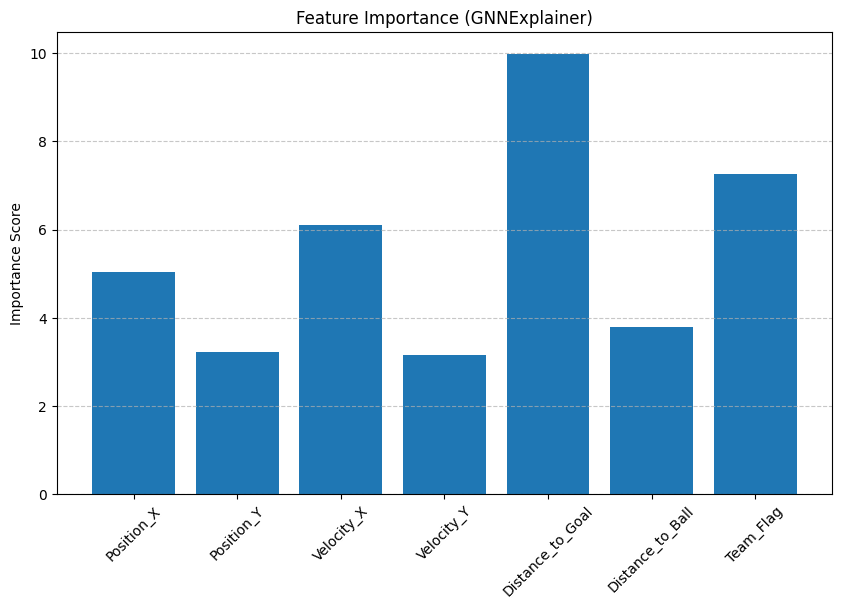

In [ ]:
import matplotlib.pyplot as plt

# 特徴量ラベル（あなたのデータ形式に合わせて調整してください）
# 例: 0:x, 1:y, 2:vx, 3:vy, 4:dist_goal, 5:dist_ball, 6:team_id ...
labels = [
    'Position_X',        # Index 0
    'Position_Y',        # Index 1
    'Velocity_X',        # Index 2
    'Velocity_Y',        # Index 3
    'Distance_to_Goal',  # Index 4
    'Distance_to_Ball',  # Index 5
    'Team_Flag'          # Index 6
]

# 特徴量ごとの重要度（node_mask）を全ノードで集計
feat_importance = explanation.node_mask.abs().sum(dim=0).cpu().numpy()

plt.figure(figsize=(10, 6))
plt.bar(labels[:len(feat_importance)], feat_importance)
plt.title("Feature Importance (GNNExplainer)")
plt.ylabel("Importance Score")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

🔍 Searching for comparison cases...

🎬 Analyzing AI Prediction: SUCCESS (Index: 24)...


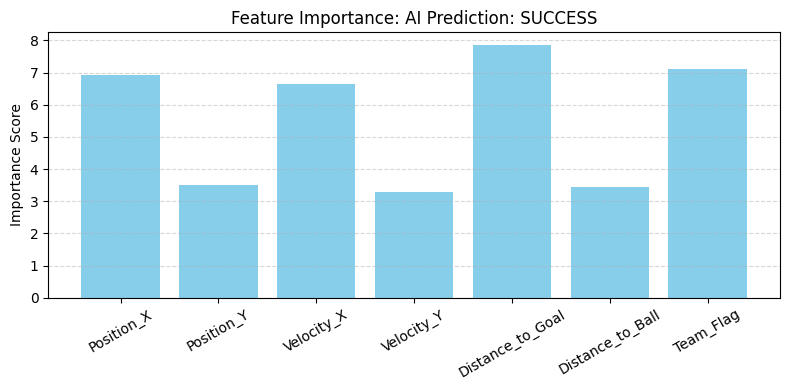

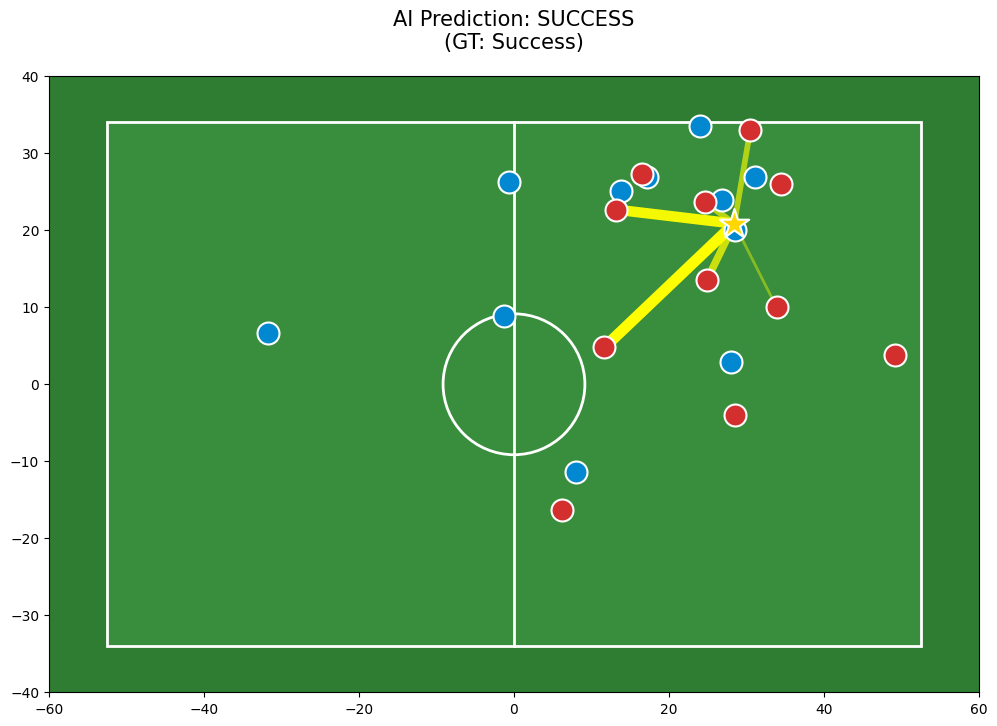


🎬 Analyzing AI Prediction: FAILURE (Index: 36)...


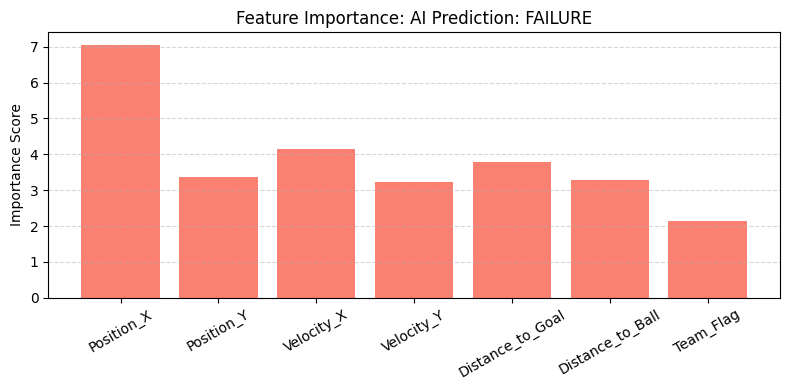

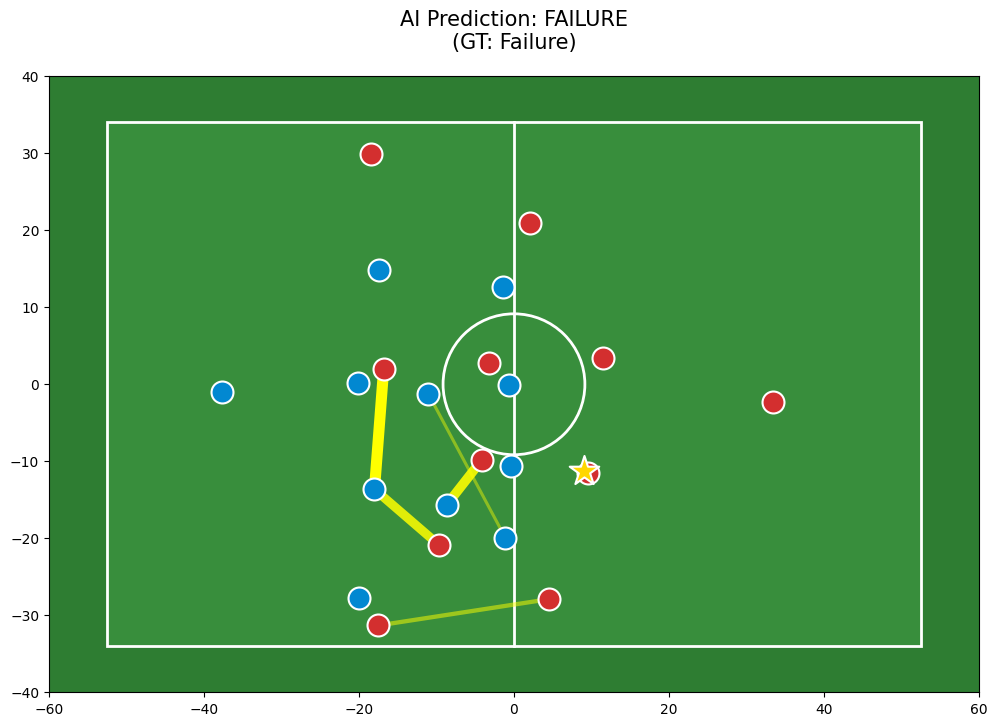

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt

def explain_and_visualize_comparison(explainer, data_list, device):
    # --- 1. 成功シーン(Probが高い)と失敗シーン(Probが低い)を探索 ---
    target_success_idx = -1
    target_failure_idx = -1

    print("🔍 Searching for comparison cases...")
    pignn_model.eval()
    with torch.no_grad():
        for i, data in enumerate(data_list):
            data = data.to(device)
            if not hasattr(data, 'batch') or data.batch is None:
                data.batch = torch.zeros(data.x.size(0), dtype=torch.long, device=device)

            out = pignn_model(data)
            prob = torch.softmax(out, dim=1)[0, 1].item()

            if prob > 0.9 and target_success_idx == -1:
                target_success_idx = i
            if prob < 0.1 and target_failure_idx == -1:
                target_failure_idx = i

            if target_success_idx != -1 and target_failure_idx != -1:
                break

    # 表示名を英語に変更して文字化けを回避
    indices = {"AI Prediction: SUCCESS": target_success_idx, "AI Prediction: FAILURE": target_failure_idx}

    # --- 2. 順に可視化 ---
    for title_prefix, idx in indices.items():
        if idx == -1:
            print(f"⚠️ {title_prefix} matching scene not found.")
            continue

        data_single = data_list[idx].to(device)
        print(f"\n🎬 Analyzing {title_prefix} (Index: {idx})...")

        explanation = explainer(
            x=data_single.x,
            edge_index=data_single.edge_index,
            batch=torch.zeros(data_single.x.size(0), dtype=torch.long, device=device),
            pos=data_single.pos,
            vel=data_single.vel
        )

        # --- A. 棒グラフ (特徴量重要度) ---
        feat_importance = explanation.node_mask.abs().sum(dim=0).cpu().numpy()
        plt.figure(figsize=(8, 4))
        # 成功ならSkyblue, 失敗ならSalmonで色分け
        bar_color = 'skyblue' if "SUCCESS" in title_prefix else 'salmon'
        plt.bar(labels[:len(feat_importance)], feat_importance, color=bar_color)
        plt.title(f"Feature Importance: {title_prefix}")
        plt.ylabel("Importance Score")
        plt.xticks(rotation=30)
        plt.grid(axis='y', linestyle='--', alpha=0.5) # グリッドを追加して見やすく
        plt.tight_layout() # ラベルの切れを防止
        plt.show()

        # --- B. ピッチ図 (戦術可視化) ---
        visualize_explanation_on_pitch_fixed(
            explanation, data_single,
            title=f"{title_prefix}\n(GT: {'Success' if data_single.y.item()==1 else 'Failure'})"
        )

# 実行
explain_and_visualize_comparison(explainer, all_data_list, device)

In [ ]:
# 重要度の高いエッジのインデックスを抽出
edge_mask = explanation.edge_mask.cpu().numpy()
edge_index = data_single.edge_index.cpu().numpy()

# 上位5%のエッジを抽出
threshold = np.percentile(edge_mask, 95)

# この上位エッジを、以前作成した「ピッチ可視化コード」の
# 黄色い線の代わりに描画すれば、「AIが選んだ真の戦術」が浮かび上がります。

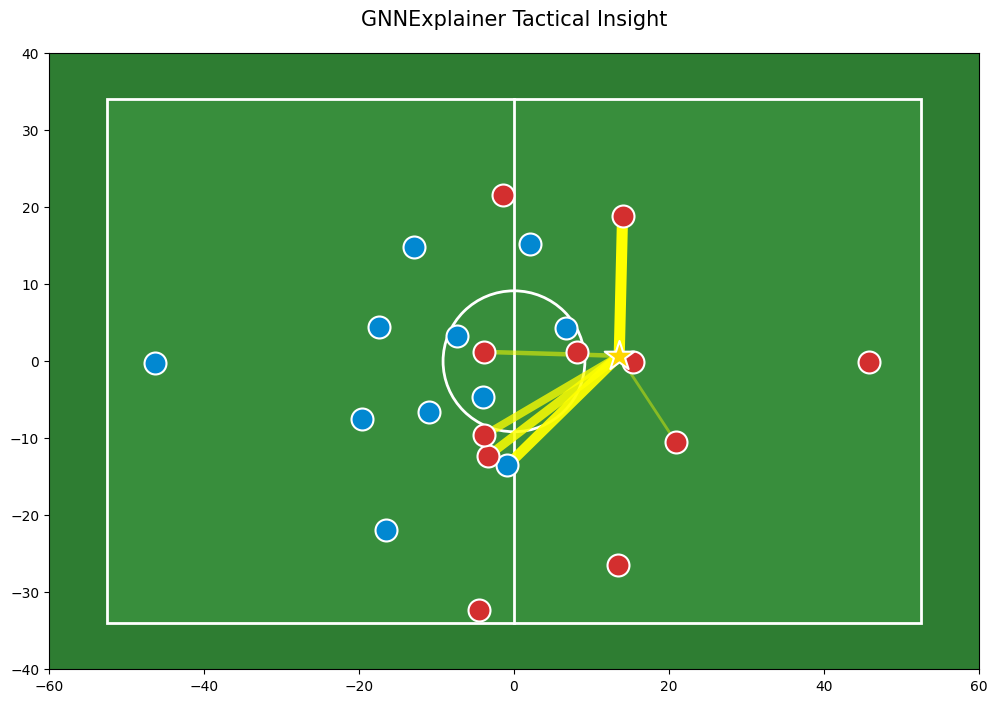

In [ ]:
def visualize_explanation_on_pitch_fixed(explanation, data, title="GNNExplainer Tactical Insight"):
    # --- 1. 座標の変換ロジックを修正 ---
    pos = data.pos.cpu().numpy()

    # 正規化範囲が -1 ~ 1 の場合：
    # そのままピッチサイズ（半分）を掛けるだけで、中央(0,0)を基準に配置されます
    pos_plot_x = pos[:, 0] * 52.5  # -1*52.5 = -52.5 (左端), 1*52.5 = 52.5 (右端)
    pos_plot_y = pos[:, 1] * 34.0  # -1*34.0 = -34.0 (下端), 1*34.0 = 34.0 (上端)

    edge_index = data.edge_index.cpu().numpy()
    edge_mask = explanation.edge_mask.cpu().numpy()

    # チームID取得 (xの7番目: index 6)
    # 0.0:攻撃, 1.0:守備, 2.0:ボール
    team_ids = data.x[:, 6].cpu().numpy()

    # --- 2. ピッチ描画 (背景) ---
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.set_facecolor('#2e7d32')
    ax.add_patch(patches.Rectangle((-52.5, -34), 105, 68, fill=True, color='#388e3c', zorder=0))
    ax.add_patch(patches.Rectangle((-52.5, -34), 105, 68, fill=False, color='white', lw=2, zorder=1))
    ax.plot([0, 0], [-34, 34], color='white', lw=2, zorder=1)
    ax.add_patch(patches.Circle((0, 0), 9.15, edgecolor="white", facecolor="none", lw=2, zorder=1))

    # --- 3. 重要エッジの描画 ---
    threshold = np.percentile(edge_mask, 98)
    max_val = edge_mask.max()

    for i in range(len(edge_mask)):
        if edge_mask[i] >= threshold:
            src, dst = edge_index[0, i], edge_index[1, i]
            val_norm = (edge_mask[i] - threshold) / (max_val - threshold + 1e-9)
            ax.plot([pos_plot_x[src], pos_plot_x[dst]],
                    [pos_plot_y[src], pos_plot_y[dst]],
                    color='yellow', alpha=0.4 + 0.6*val_norm,
                    lw=2 + 6*val_norm, zorder=2)

    # --- 4. 選手・ボールの描画 ---
    for i in range(len(pos)):
        # チームラベルに基づいた色分け
        if team_ids[i] == 2.0: # ボール
            color, marker, size = 'gold', '*', 500
        elif team_ids[i] == 0.0: # 攻撃
            color, marker, size = '#0288d1', 'o', 250
        else: # 守備
            color, marker, size = '#d32f2f', 'o', 250

        ax.scatter(pos_plot_x[i], pos_plot_y[i], c=color, marker=marker,
                   s=size, edgecolors='white', linewidth=1.5, zorder=3)

    ax.set_title(title, fontsize=15, pad=20)
    ax.set_xlim(-60, 60); ax.set_ylim(-40, 40)
    plt.show()

# 実行
visualize_explanation_on_pitch_fixed(explanation, data_single)

In [ ]:
print(f"モデルの予測ラベル: {explanation.prediction.argmax().item()} (0:失敗, 1:成功)")
print(f"実際の正解ラベル: {data_single.y.item()} (0:失敗, 1:成功)")

モデルの予測ラベル: 1 (0:失敗, 1:成功)
実際の正解ラベル: 0 (0:失敗, 1:成功)


🔎 成功的中(True Positive)シーンを探索中... (Device: cuda:0)
✅ 255 件の成功的中シーンが見つかりました。上位を可視化します。


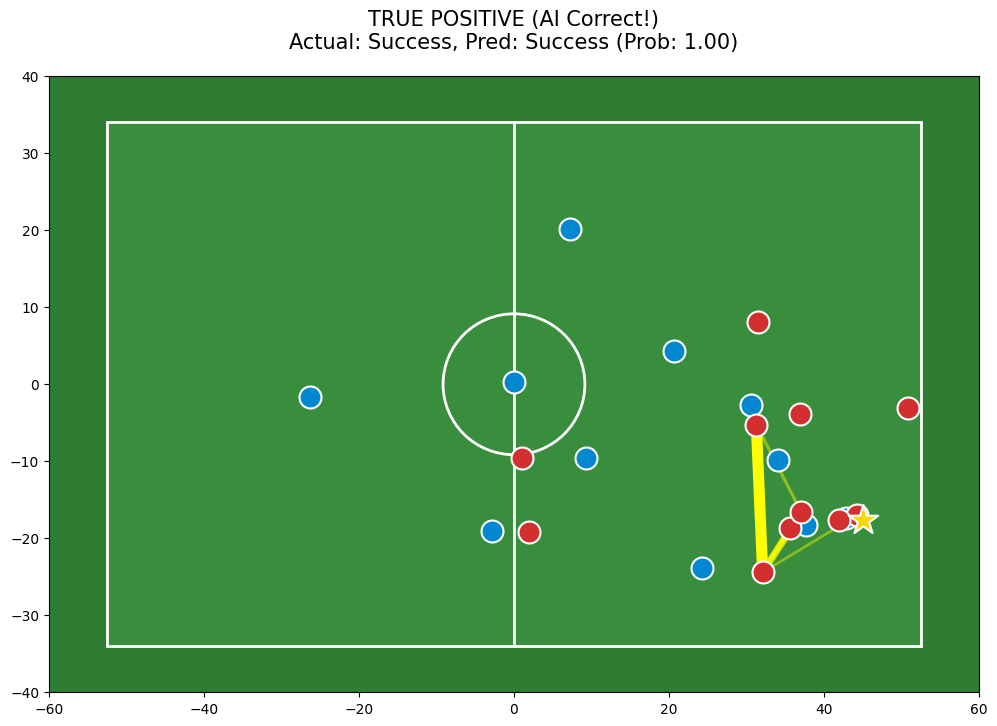

📊 Index 1529 の可視化が完了しました。


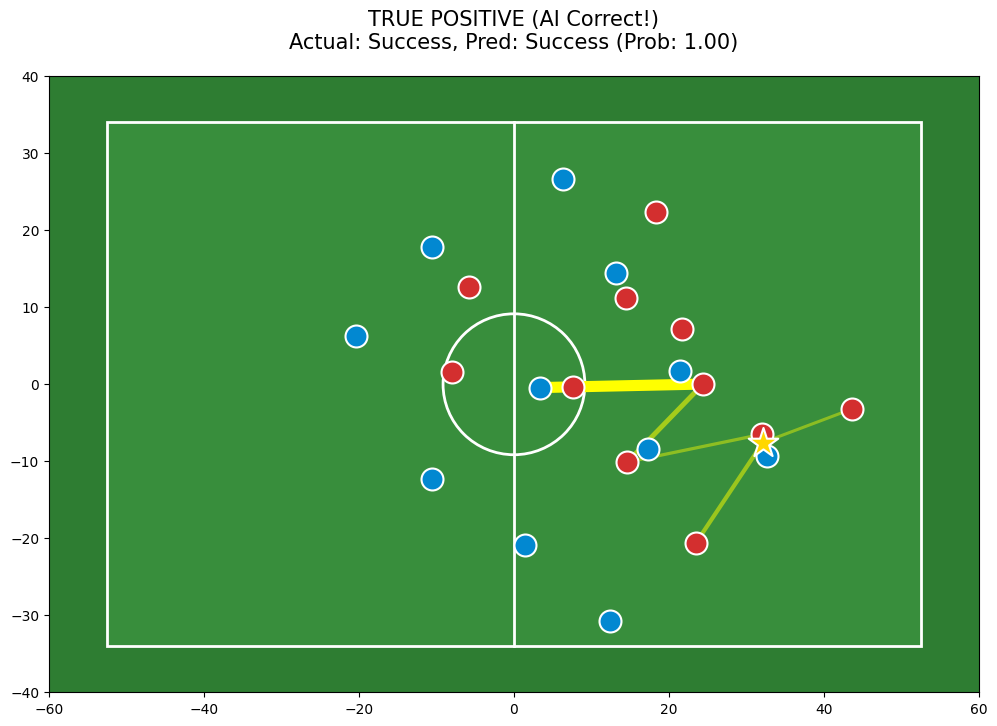

📊 Index 1466 の可視化が完了しました。


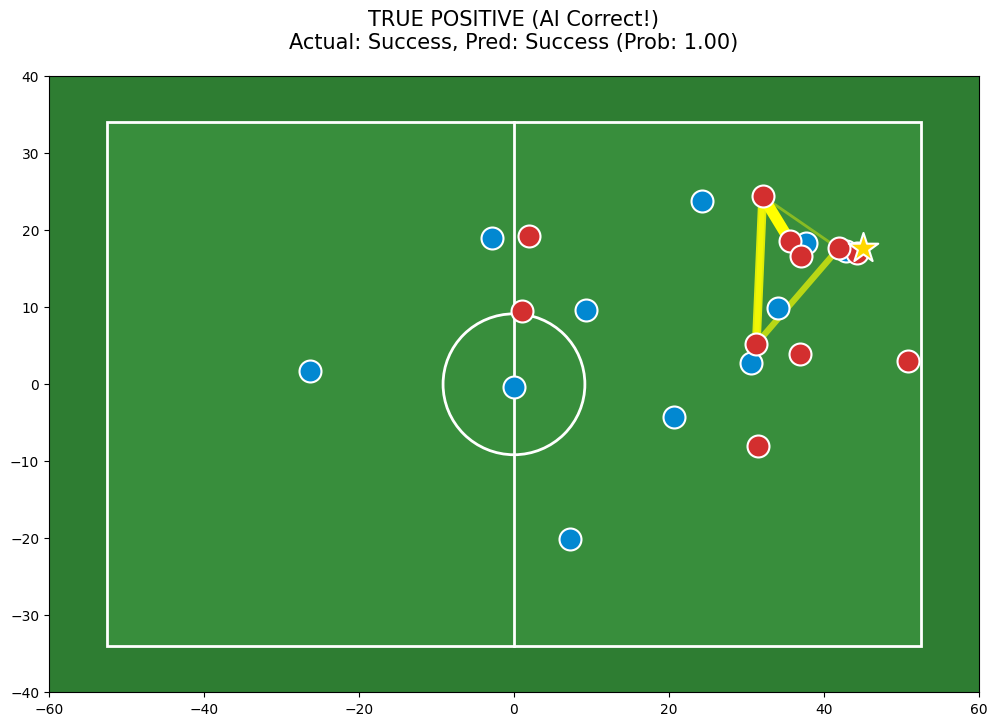

📊 Index 1528 の可視化が完了しました。


In [ ]:
def find_and_visualize_tp_final(model, dataset, num_samples=1):
    # モデルのデバイスを取得
    device = next(model.parameters()).device
    model.eval()
    tp_indices = []

    print(f"🔎 成功的中(True Positive)シーンを探索中... (Device: {device})")
    for i, data in enumerate(dataset):
        # データをモデルと同じデバイスに転送
        x = data.x.to(device).to(torch.float)
        edge_index = data.edge_index.to(device).to(torch.long)
        pos = data.pos.to(device).to(torch.float)
        vel = data.vel.to(device).to(torch.float)

        with torch.no_grad():
            # forwardの引数名はあなたのモデル定義に合わせて適宜調整してください
            # ここでは (x, edge_index, pos, vel) を想定
            out = model(x, edge_index, pos=pos, vel=vel)

            pred = out.argmax(dim=1).item()
            actual = data.y.item()

            if pred == 1 and actual == 1:
                prob = torch.exp(out[0][1]).item()
                tp_indices.append((i, prob))

    tp_indices = sorted(tp_indices, key=lambda x: x[1], reverse=True)

    if not tp_indices:
        print("❌ 成功的中シーンが見つかりませんでした。")
        return

    print(f"✅ {len(tp_indices)} 件の成功的中シーンが見つかりました。上位を可視化します。")

    from torch_geometric.explain import Explainer, GNNExplainer

    # Explainer用のラッパー（デバイス対応）
    class ExplainerWrapper(torch.nn.Module):
        def __init__(self, model):
            super().__init__()
            self.model = model

        def forward(self, x, edge_index, **kwargs):
            # Explainerから渡される座標や速度もデバイスを合わせる
            pos = kwargs.get('pos')
            vel = kwargs.get('vel')
            return self.model(x, edge_index, pos=pos, vel=vel)

    wrapper = ExplainerWrapper(model)

    explainer = Explainer(
        model=wrapper,
        algorithm=GNNExplainer(epochs=200),
        explanation_type='model',
        node_mask_type='attributes',
        edge_mask_type='object',
        model_config=dict(
            mode='multiclass_classification',
            task_level='graph',
            return_type='log_probs',
        ),
    )

    for i in range(min(num_samples, len(tp_indices))):
        idx, prob = tp_indices[i]
        # 元データをGPUに送ってからExplainerに渡す
        data_single = dataset[idx].to(device)

        explanation = explainer(
            data_single.x,
            data_single.edge_index,
            pos=data_single.pos,
            vel=data_single.vel
        )

        title = f"TRUE POSITIVE (AI Correct!)\nActual: Success, Pred: Success (Prob: {prob:.2f})"
        visualize_explanation_on_pitch_fixed(explanation, data_single, title=title)
        print(f"📊 Index {idx} の可視化が完了しました。")

# 実行
find_and_visualize_tp_final(pignn_model, all_data_list, num_samples=3)

🔎 成功的中(True Positive)シーンをランキング化中...
✅ 自信度ランキング第 31 位 (Index: 232, Prob: 0.9903) を可視化します。


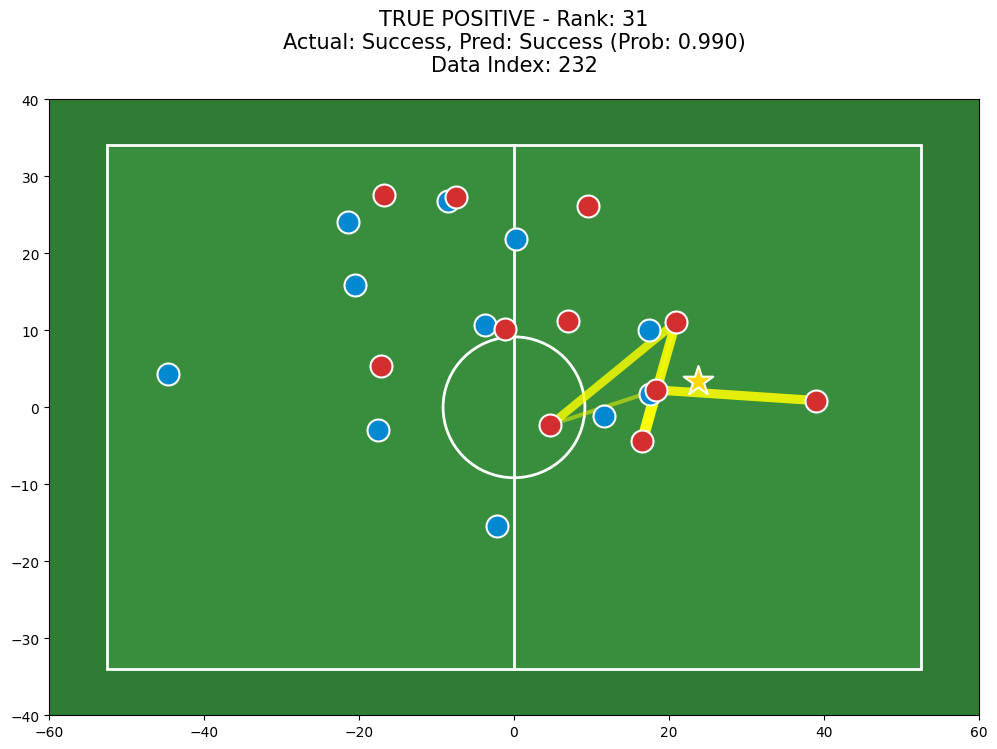

In [ ]:
def visualize_tp_by_rank(model, dataset, rank=0):
    """
    rank: 0なら最も確率が高いシーン、1なら2番目...を表示
    """
    device = next(model.parameters()).device
    model.eval()
    tp_indices = []

    # 1. まず全ての成功的中(TP)シーンを抽出
    print(f"🔎 成功的中(True Positive)シーンをランキング化中...")
    for i, data in enumerate(dataset):
        x = data.x.to(device).to(torch.float)
        edge_index = data.edge_index.to(device).to(torch.long)
        pos = data.pos.to(device).to(torch.float)
        vel = data.vel.to(device).to(torch.float)

        with torch.no_grad():
            out = model(x, edge_index, pos=pos, vel=vel)
            pred = out.argmax(dim=1).item()
            actual = data.y.item()

            if pred == 1 and actual == 1:
                # 成功(index 1)の確率を取得
                prob = torch.exp(out[0][1]).item()
                tp_indices.append((i, prob))

    # 2. 確率が高い順にソート
    tp_indices = sorted(tp_indices, key=lambda x: x[1], reverse=True)

    if not tp_indices:
        print("❌ 成功的中シーンが見つかりませんでした。")
        return

    if rank >= len(tp_indices):
        print(f"❌ 指定された順位(rank={rank})は範囲外です。全{len(tp_indices)}件です。")
        return

    # 3. 指定された順位のシーンを1枚だけ詳しく解析
    idx, prob = tp_indices[rank]
    print(f"✅ 自信度ランキング第 {rank+1} 位 (Index: {idx}, Prob: {prob:.4f}) を可視化します。")

    from torch_geometric.explain import Explainer, GNNExplainer

    class ExplainerWrapper(torch.nn.Module):
        def __init__(self, model):
            super().__init__()
            self.model = model
        def forward(self, x, edge_index, **kwargs):
            return self.model(x, edge_index, pos=kwargs.get('pos'), vel=kwargs.get('vel'))

    wrapper = ExplainerWrapper(model)
    explainer = Explainer(
        model=wrapper,
        algorithm=GNNExplainer(epochs=200), # 200あれば十分です
        explanation_type='model',
        node_mask_type='attributes',
        edge_mask_type='object',
        model_config=dict(mode='multiclass_classification', task_level='graph', return_type='log_probs'),
    )

    data_single = dataset[idx].to(device)
    explanation = explainer(data_single.x, data_single.edge_index, pos=data_single.pos, vel=data_single.vel)

    title = f"TRUE POSITIVE - Rank: {rank+1}\nActual: Success, Pred: Success (Prob: {prob:.3f})\nData Index: {idx}"
    visualize_explanation_on_pitch_fixed(explanation, data_single, title=title)

# --- 実行エリア ---
# rank=0 で最強の成功シーン、rank=1, 2... と変えて実行してください
visualize_tp_by_rank(pignn_model, all_data_list, rank=30)

🔎 TN シーンを探索中... (Device: cuda:0)
✅ 1541 件の TN シーンが見つかりました。上位を可視化します。


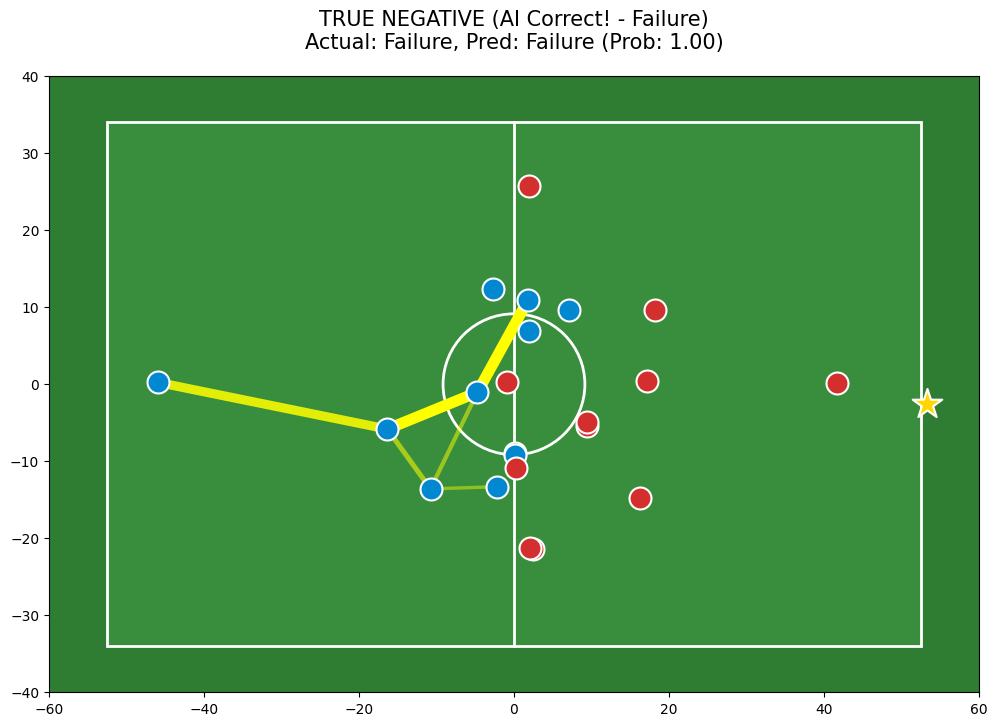

📊 Index 1616 (TN) の可視化が完了しました。


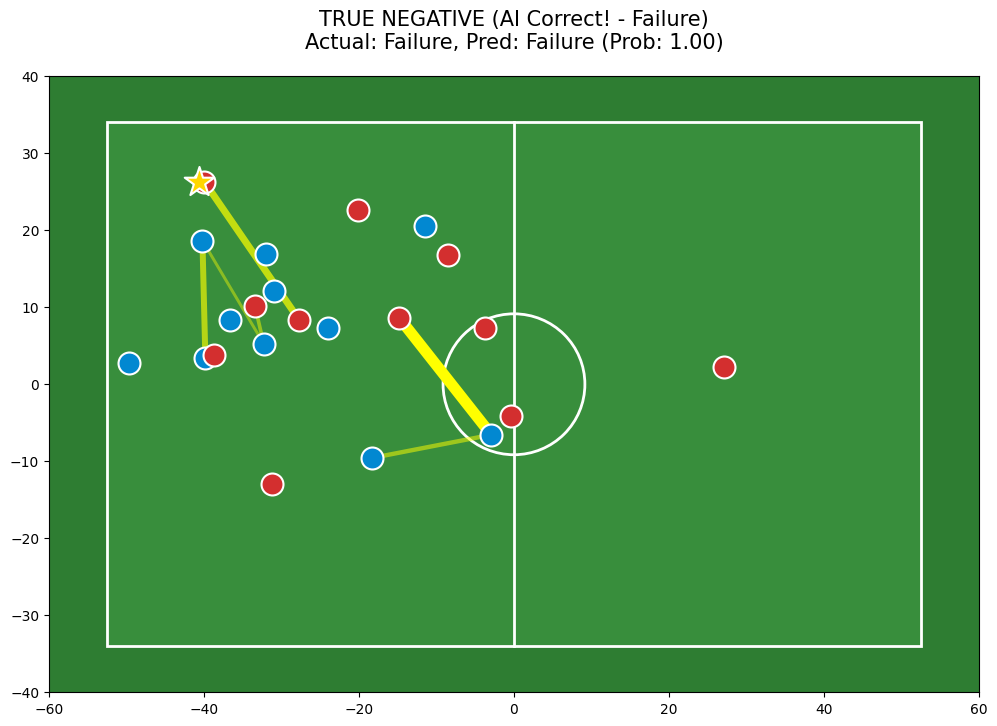

📊 Index 2416 (TN) の可視化が完了しました。


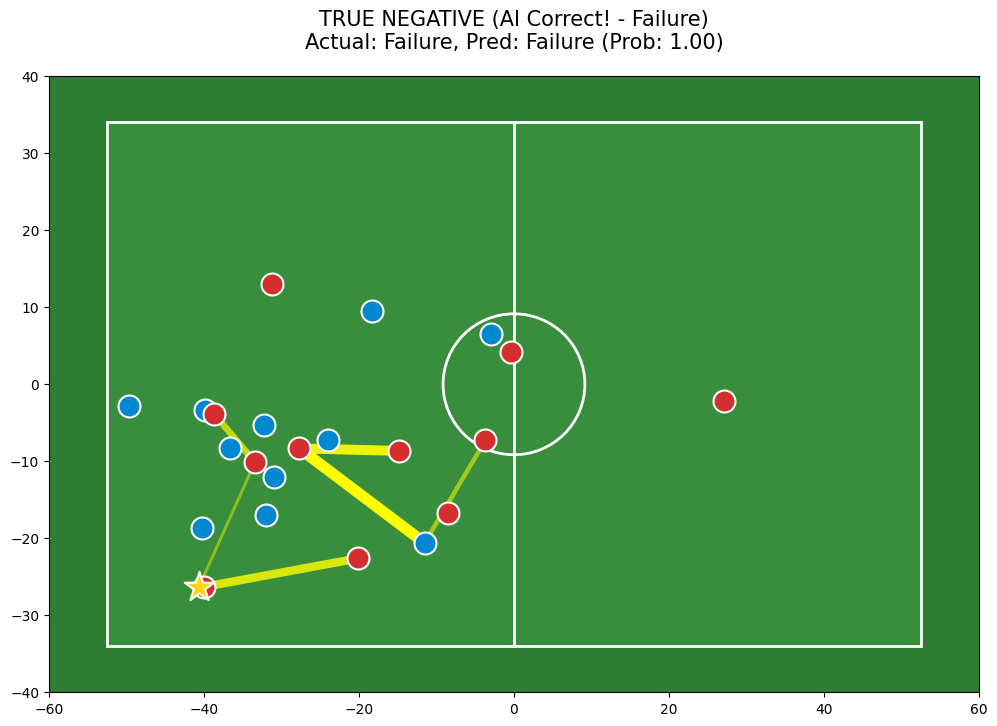

📊 Index 2417 (TN) の可視化が完了しました。
🔎 FP シーンを探索中... (Device: cuda:0)
✅ 1439 件の FP シーンが見つかりました。上位を可視化します。


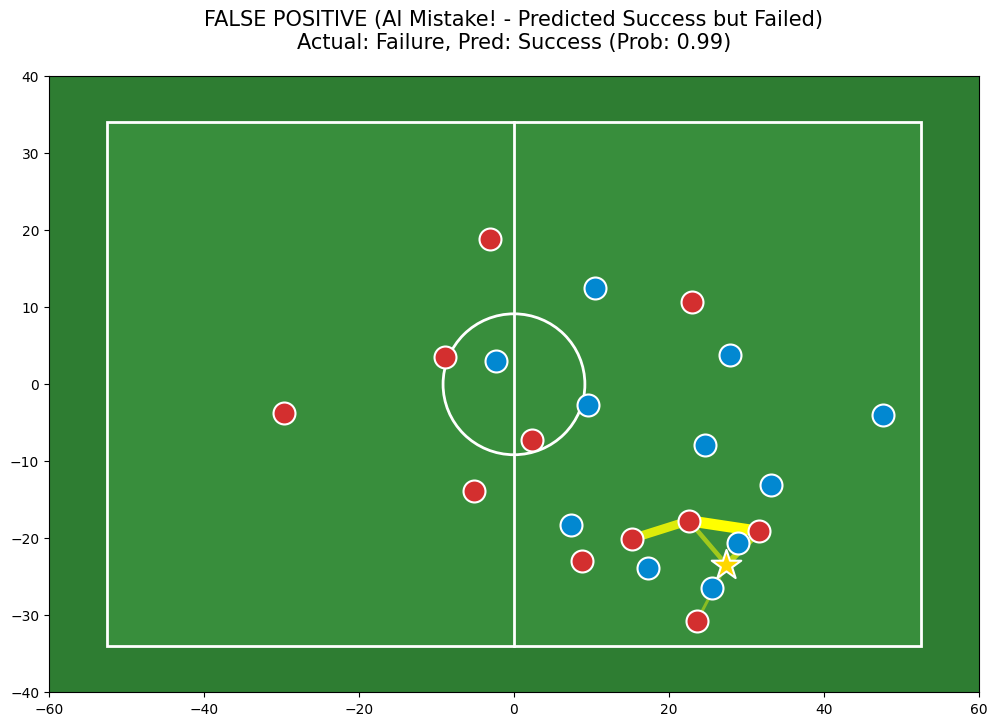

📊 Index 2684 (FP) の可視化が完了しました。


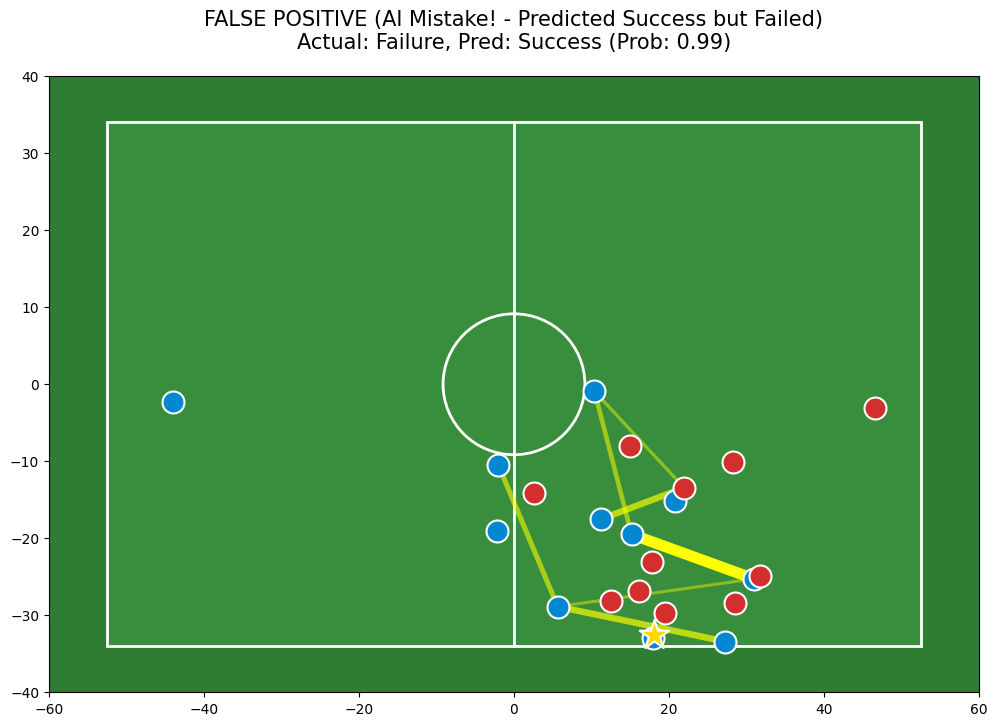

📊 Index 634 (FP) の可視化が完了しました。


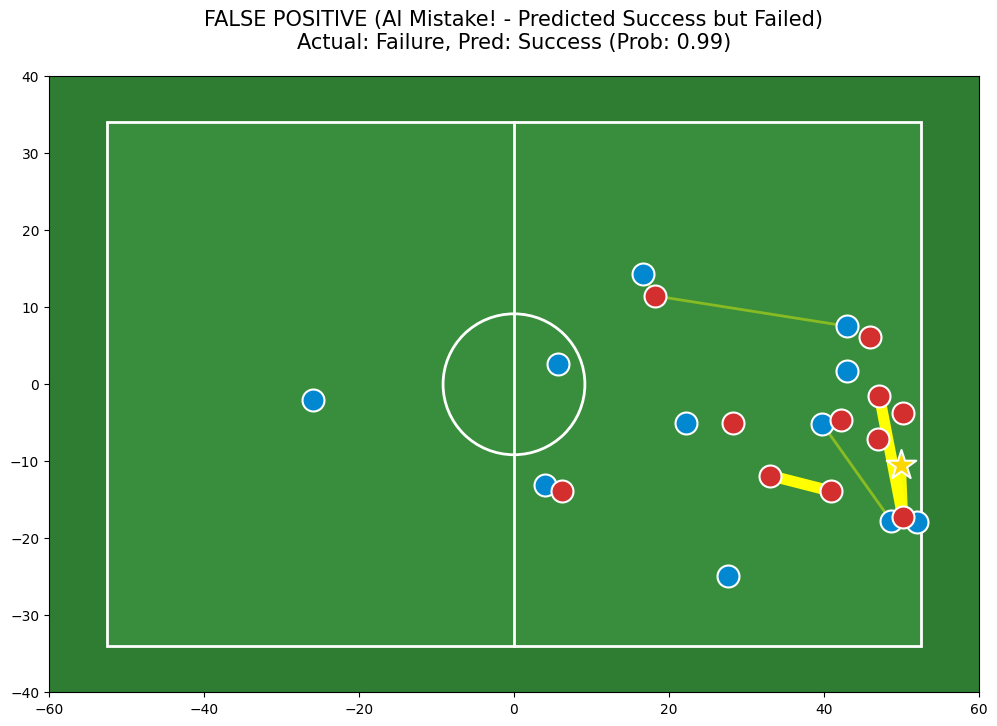

📊 Index 2831 (FP) の可視化が完了しました。


In [ ]:
def find_and_visualize_by_case(model, dataset, case_type='TP', num_samples=1):
    """
    case_type:
        'TP' (True Positive) : 実際成功 / 予測成功 (的中)
        'TN' (True Negative) : 実際失敗 / 予測失敗 (的中) -> 失敗シーンの的中
        'FP' (False Positive): 実際失敗 / 予測成功 (空振り) -> 失敗シーンの誤認
        'FN' (False Negative): 実際成功 / 予測失敗 (見逃し)
    """
    device = next(model.parameters()).device
    model.eval()
    indices = []

    print(f"🔎 {case_type} シーンを探索中... (Device: {device})")

    for i, data in enumerate(dataset):
        x = data.x.to(device).to(torch.float)
        edge_index = data.edge_index.to(device).to(torch.long)
        pos = data.pos.to(device).to(torch.float)
        vel = data.vel.to(device).to(torch.float)

        with torch.no_grad():
            out = model(x, edge_index, pos=pos, vel=vel)
            pred = out.argmax(dim=1).item()
            actual = data.y.item()
            prob = torch.exp(out[0][pred]).item() # 予測したクラスの確信度

            # 条件判定
            is_match = False
            if case_type == 'TP' and pred == 1 and actual == 1: is_match = True
            elif case_type == 'TN' and pred == 0 and actual == 0: is_match = True
            elif case_type == 'FP' and pred == 1 and actual == 0: is_match = True
            elif case_type == 'FN' and pred == 0 and actual == 1: is_match = True

            if is_match:
                indices.append((i, prob))

    # 確信度（確率）が高い順にソート
    indices = sorted(indices, key=lambda x: x[1], reverse=True)

    if not indices:
        print(f"❌ {case_type} シーンが見つかりませんでした。")
        return

    print(f"✅ {len(indices)} 件の {case_type} シーンが見つかりました。上位を可視化します。")

    # Explainerの設定（デバイス対応）
    from torch_geometric.explain import Explainer, GNNExplainer
    class ExplainerWrapper(torch.nn.Module):
        def __init__(self, model):
            super().__init__()
            self.model = model
        def forward(self, x, edge_index, **kwargs):
            return self.model(x, edge_index, pos=kwargs.get('pos'), vel=kwargs.get('vel'))

    explainer = Explainer(
        model=ExplainerWrapper(model),
        algorithm=GNNExplainer(epochs=200),
        explanation_type='model',
        node_mask_type='attributes',
        edge_mask_type='object',
        model_config=dict(
            mode='multiclass_classification',
            task_level='graph',
            return_type='log_probs',
        ),
    )

    for i in range(min(num_samples, len(indices))):
        idx, prob = indices[i]
        data_single = dataset[idx].to(device)

        explanation = explainer(
            data_single.x,
            data_single.edge_index,
            pos=data_single.pos,
            vel=data_single.vel
        )

        # ケースに応じたタイトル作成
        status_map = {
            'TP': "TRUE POSITIVE (AI Correct! - Success)",
            'TN': "TRUE NEGATIVE (AI Correct! - Failure)",
            'FP': "FALSE POSITIVE (AI Mistake! - Predicted Success but Failed)",
            'FN': "FALSE NEGATIVE (AI Mistake! - Predicted Failure but Successed)"
        }
        actual_label = "Success" if data_single.y.item() == 1 else "Failure"
        pred_label = "Success" if case_type in ['TP', 'FP'] else "Failure"

        title = f"{status_map[case_type]}\nActual: {actual_label}, Pred: {pred_label} (Prob: {prob:.2f})"

        visualize_explanation_on_pitch_fixed(explanation, data_single, title=title)
        print(f"📊 Index {idx} ({case_type}) の可視化が完了しました。")

# --- 使い方 ---

# 1. 失敗を失敗と正しく判定したシーン（なぜ失敗するとAIが判断したかの根拠）
find_and_visualize_by_case(pignn_model, all_data_list, case_type='TN', num_samples=3)

# 2. 失敗したのに成功と誤認したシーン（AIがどこに騙されたかの根拠）
find_and_visualize_by_case(pignn_model, all_data_list, case_type='FP', num_samples=3)

🔄 データのデバイス整合性を修正中...
✅ 全データをCPUに配置し、cv_test_loaderを再構成しました。
✅ PIGNN重みロード完了。解析を開始します。
🔍 比較シーンを探索中... (Device: cuda)
⚠️ 条件Aが見つかりませんでした。
✅ 条件B発見: Avg_Vx=0.072, Prob=0.999


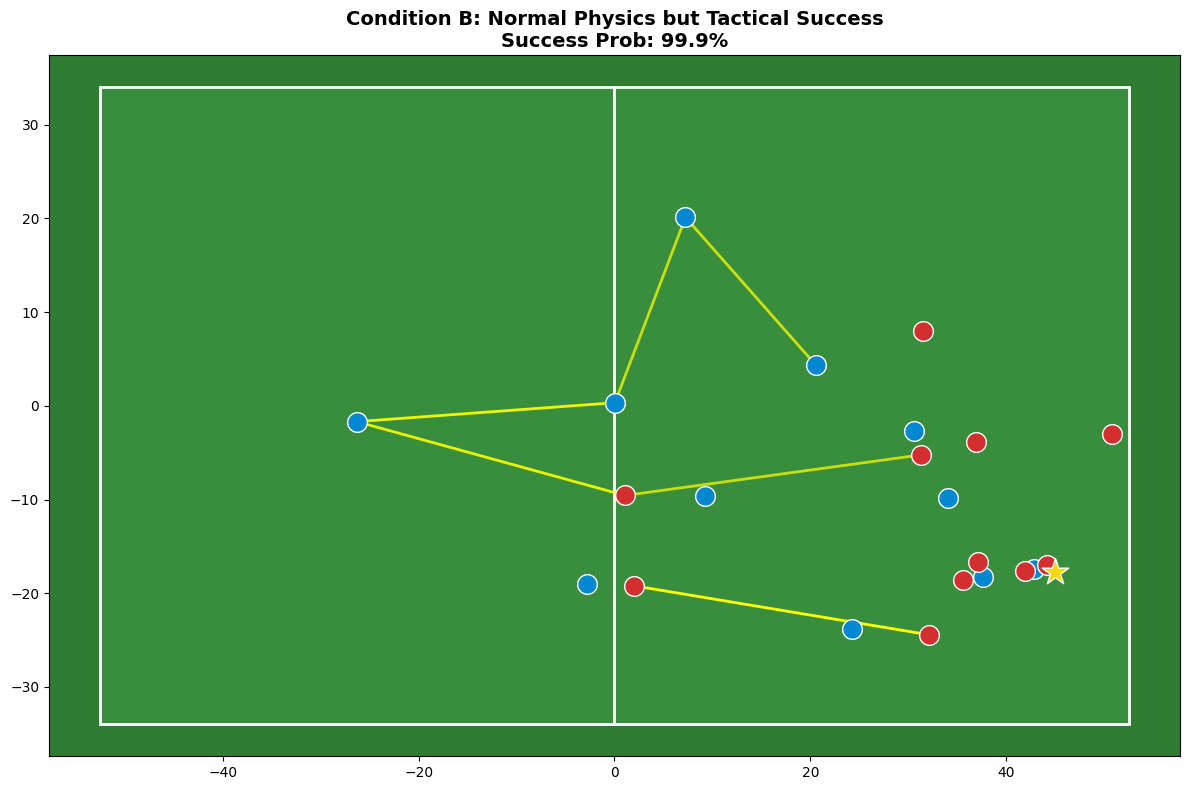

In [ ]:
import torch
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from torch_geometric.loader import DataLoader

# ==========================================
# 1. 描画関数の再定義（引数エラー修正版）
# ==========================================
def visualize_pignn_tactical_analysis(model, data_item, device, title="Analysis"):
    model.eval()
    data_item = data_item.to(device)

    # --- 推論とアテンション抽出（完全指定版） ---
    with torch.no_grad():
        out, (edge_index, att_weights) = model(
            data=data_item,
            x=data_item.x,
            edge_index=data_item.edge_index,
            batch=data_item.batch,
            pos=data_item.pos,
            vel=data_item.vel,
            return_attention=True
        )
        prob = torch.softmax(out, dim=1)[0, 1].item()
        pred = out.argmax(dim=1).item()
        label = data_item.y.item()

    # --- 座標と速度の復元 ---
    pos = data_item.pos.cpu().numpy()
    vel = data_item.vel.cpu().numpy()
    # 座標スケール調整（ピッチサイズに合わせる）
    pos_plot = np.zeros_like(pos)
    pos_plot[:, 0] = pos[:, 0] * 52.5
    pos_plot[:, 1] = pos[:, 1] * 34.0

    fig, ax = plt.subplots(figsize=(12, 8))

    # サッカーピッチの描画
    ax.set_facecolor('#2e7d32')
    ax.add_patch(patches.Rectangle((-52.5, -34), 105, 68, fill=True, color='#388e3c', zorder=0))
    ax.add_patch(patches.Rectangle((-52.5, -34), 105, 68, fill=False, color='white', lw=2, zorder=1))
    ax.plot([0, 0], [-34, 34], color='white', lw=2, zorder=1)

    # アテンション係数の描画
    att_weights = att_weights.cpu().numpy().flatten()
    edge_index = edge_index.cpu().numpy()
    if len(att_weights) > 0:
        threshold = np.percentile(att_weights, 98) # 上位2%を可視化
        for i in range(edge_index.shape[1]):
            if att_weights[i] > threshold:
                src, dst = edge_index[0, i], edge_index[1, i]
                alpha_val = min((att_weights[i] / att_weights.max()), 1.0)
                ax.plot([pos_plot[src, 0], pos_plot[dst, 0]],
                        [pos_plot[src, 1], pos_plot[dst, 1]],
                        color='#FFFF00', alpha=alpha_val, lw=2, zorder=2)

    # 選手ノードの描画
    team_ids = data_item.x[:, 6].cpu().numpy()
    for i in range(len(pos)):
        if team_ids[i] == 2.0: # ボール
            color, size, marker = 'gold', 400, '*'
        elif team_ids[i] == 0.0: # 攻撃
            color, size, marker = '#0288d1', 200, 'o'
        else: # 守備
            color, size, marker = '#d32f2f', 200, 'o'

        ax.scatter(pos_plot[i, 0], pos_plot[i, 1], c=color, s=size, marker=marker,
                   edgecolors='white', linewidth=1, zorder=10)

    ax.set_title(f"{title}\nSuccess Prob: {prob:.1%}", fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

# ==========================================
# 2. データの「完全CPU化」と再構成
# ==========================================
print("🔄 データのデバイス整合性を修正中...")
if 'all_data_list' in locals():
    all_data_list_cpu = [d.to('cpu') for d in all_data_list]
    cv_test_loader = DataLoader(all_data_list_cpu, batch_size=1, shuffle=False)
    print("✅ 全データをCPUに配置し、cv_test_loaderを再構成しました。")
else:
    print("⚠️ all_data_listが見つかりません。")

# ==========================================
# 3. 戦略的比較関数の定義（マイルドな閾値設定）
# ==========================================
def run_strategic_comparison(model, loader, device):
    model.eval()
    all_results = []

    print("🔍 比較シーンを探索中... (Device: {})".format(device))

    with torch.no_grad():
        for data in loader:
            data = data.to('cpu')
            data = preprocess_batch(data, device)

            if not hasattr(data, 'batch') or data.batch is None:
                data.batch = torch.zeros(data.x.size(0), dtype=torch.long, device=device)

            # モデル推論
            out, (edge_idx, att) = model(
                data=data, x=data.x, edge_index=data.edge_index,
                batch=data.batch, pos=data.pos, vel=data.vel, return_attention=True
            )
            prob = torch.softmax(out, dim=1)[0, 1].item()

            atk_mask = (data.x[:, 6] == 0.0)
            avg_vx = data.vel[atk_mask, 0].mean().item() if atk_mask.any() else 0.0

            all_results.append({
                'data': data.cpu(),
                'avg_vx': avg_vx,
                'prob': prob,
                'label': data.y.item()
            })

    if not all_results:
        print("⚠️ データが見つかりません。")
        return

    # 条件A: 速度はあるが、AIが失敗と予測（戦術的失敗）
    # 閾値を0.2以上 / 0.5以下にマイルド化
    candidates_a = [res for res in all_results if res['avg_vx'] > 0.10 and res['prob'] < 0.5]
    case_a = sorted(candidates_a, key=lambda x: x['prob'])[0] if candidates_a else None

    # 条件B: 速度は平凡だが、AIが成功と予測（戦術的成功）
    # 閾値を0.2以下 / 0.6以上にマイルド化
    candidates_b = [res for res in all_results if res['avg_vx'] < 0.2 and res['prob'] > 0.6]
    case_b = sorted(candidates_b, key=lambda x: x['prob'], reverse=True)[0] if candidates_b else None

    # 描画
    if case_a:
        print(f"✅ 条件A発見: Avg_Vx={case_a['avg_vx']:.3f}, Prob={case_a['prob']:.3f}")
        visualize_pignn_tactical_analysis(model, case_a['data'], device, title="Condition A: High Physics but Tactical Failure")
    else:
        print("⚠️ 条件Aが見つかりませんでした。")

    if case_b:
        print(f"✅ 条件B発見: Avg_Vx={case_b['avg_vx']:.3f}, Prob={case_b['prob']:.3f}")
        visualize_pignn_tactical_analysis(model, case_b['data'], device, title="Condition B: Normal Physics but Tactical Success")
    else:
        print("⚠️ 条件Bが見つかりませんでした。")

# ==========================================
# 4. 実行セクション
# ==========================================
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
pignn_model = PIGNNClassifier(hidden_channels=64).to(device)
pignn_path = "/content/drive/MyDrive/GNN_Football_Analysis/Models/alpha_100_0_take3/pignn_testmatch_1.pth"

if os.path.exists(pignn_path):
    pignn_model.load_state_dict(torch.load(pignn_path, map_location=device), strict=False)
    print("✅ PIGNN重みロード完了。解析を開始します。")
    run_strategic_comparison(pignn_model, cv_test_loader, device)
else:
    print(f"⚠️ ファイル未検出: {pignn_path}")